# **Predicting the Price of Resale Flats in Singapore**

# **1. Motivation**

### **Problem Statement**  
The Housing & Development Board (HDB) flats are a key part of Singapore’s real estate market, with thousands of resale transactions happening annually. Understanding the factors influencing HDB resale prices can benefit homebuyers, policymakers, and real estate professionals.  

For this project, we used the **HDB Resale Price Dataset** from 2017 to 17 March 2025, which includes over 200,000 entries of data with various attributes of resale transactions such as:  
- **Town**
- **Flat Type**
- **Storey Range**
- **Floor Area**
- **Remaining Lease**
- **Flat Model** 
- **Resale Price** *(Dependent Variable)*  

### **Objective**  
Our goal is to construct a model that will help us in determining the resale price over the years based on relevant features of a resale flat, and determinine a fair price that should be paid for the flat  

### **Research Question**  
Can we 
1. Develop a data-driven model to predict HDB resale prices based on relevant features 
And
2. Classify if the resale price people pay is fair or unfair
 

This project will provide insights into which features have the most impact on pricing, potentially helping stakeholders make informed decisions.  


In [2]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
data = pd.read_csv('data.csv')

data.head()


month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.0  
4      265000.0

In [4]:
print(data.dtypes)
print()
print("Data dimensions: ", data.shape)

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

Data dimensions:  (202399, 11)


# 2. Data Extraction & Cleaning
To prepare the dataset for analysis and modeling, we performed the following data cleaning and transformation steps:

### 1. Dropping Irrelevant Columns
We removed certain columns that were not directly relevant to resale price prediction:
- `blk`: Block number is too specific and does not generalize well across towns or contribute meaningfully to price prediction.
- `street_name`: Street name is also too specific, does not really tell us much about prediction since we already have town
- `lease_commence_date`: We used the more interpretable and numeric variable, `remaining_lease_years` instead.

### 2. Converting Remaining Lease to Years to The Nearest Float Value
The `remaining_lease` column was originally in a string format (e.g., "93 years 10 months").  
We converted it into a single numeric value representing the number of remaining lease years, rounded down to the nearest float value.

**Reason:**  
Whole-year lease values are easier to interpret and are more aligned with how buyers and policies typically evaluate lease duration.  
It also ensures compatibility with regression-based models, which expect numeric inputs.

### 3. Creating a New Variable: Price per square Meter
We engineered a new feature called `price_per_sqm`, calculated as:
$$
\text{price\_per\_sqm} = \frac{\text{resale\_price}}{\text{floor\_area\_sqm}}
$$

**Purpose:**  
This allows us to normalize price across flats of different sizes.  
It is useful for comparing the value of flats across towns and flat types by measuring how much is paid per unit of floor area.

### 4. Preparing Categorical Variables for Modeling (One-Hot Encoding)
Some categorical variables, such as `flat_type`, `storey_range`, and `town`, will need to be transformed before they can be used in regression models.

**One-Hot Encoding** is a method for converting categorical variables into a binary (0 or 1) format.  
Each unique category becomes a new column, with a 1 indicating the presence of that category in a row.

**Purpose:**  
Most machine learning models, including Linear Regression, cannot directly interpret categorical data. One-Hot Encoding ensures these features can be numerically represented and effectively used in model training.

This encoding process will be applied later during the linear regression modeling stage to ensure the features are in the correct format for training and evaluation.

In [6]:
data = data.drop(columns=['block', 'street_name', 'lease_commence_date'])

import re
def convert_lease_to_years(lease_str):
    if pd.isna(lease_str):  # Handle missing values
        return None
    # Use regex to extract all numbers from the string
    numbers = re.findall(r'\d+', lease_str)
    if not numbers:
        return None  # or you can return 0 or a default value
    # If only one number is found, assume it's years
    if len(numbers) == 1:
        return int(numbers[0])
    # Assume the first number is years and the second is months
    years = int(numbers[0])
    months = int(numbers[1])
    return years + (months / 12)

# Apply the function correctly to the column
data['remaining_lease_years'] = data['remaining_lease'].apply(convert_lease_to_years)

# Drop the original column if no longer needed
data.drop(columns=['remaining_lease'], inplace=True)

# Display the transformed dataframe
print(data.head())
print("\nUpdated data types:\n", data.dtypes)


     month        town flat_type storey_range  floor_area_sqm      flat_model  \
0  2017-01  ANG MO KIO    2 ROOM     10 TO 12            44.0        Improved   
1  2017-01  ANG MO KIO    3 ROOM     01 TO 03            67.0  New Generation   
2  2017-01  ANG MO KIO    3 ROOM     01 TO 03            67.0  New Generation   
3  2017-01  ANG MO KIO    3 ROOM     04 TO 06            68.0  New Generation   
4  2017-01  ANG MO KIO    3 ROOM     01 TO 03            67.0  New Generation   

   resale_price  remaining_lease_years  
0      232000.0              61.333333  
1      250000.0              60.583333  
2      262000.0              62.416667  
3      265000.0              62.083333  
4      265000.0              62.416667  

Updated data types:
 month                     object
town                      object
flat_type                 object
storey_range              object
floor_area_sqm           float64
flat_model                object
resale_price             float64
remaining_leas

In [8]:
# Add Price per Square Meter (PSM) column
data['psm'] = data['resale_price'] / data['floor_area_sqm']

# Preview to confirm
print(data[['resale_price', 'floor_area_sqm', 'psm']].head())

   resale_price  floor_area_sqm          psm
0      232000.0            44.0  5272.727273
1      250000.0            67.0  3731.343284
2      262000.0            67.0  3910.447761
3      265000.0            68.0  3897.058824
4      265000.0            67.0  3955.223881


# 3. Exploratory Data Analysis (EDA)

Before applying any machine learning models, it is essential to first understand the structure, distribution, and relationships within the dataset. Exploratory Data Analysis (EDA) helps us achieve this by visually and statistically summarizing the data.

### Why EDA is Important for This Project:

- To **understand the spread and distribution** of key features such as flat types, towns, and lease years
- To **detect missing, inconsistent, or extreme values** that could negatively affect model performance
- To **identify patterns and trends** in resale prices across different time periods, towns, and flat attributes
- To **inform feature selection** by showing which variables may have strong or weak influence on the target variable (`resale_price`)
- To ensure that the data is **clean and suitable for modeling**, reducing the risk of biased or misleading results

Overall, EDA provides the foundational insights needed to build an effective and reliable machine learning model for predicting HDB resale prices.


## 3.1 Overview of Resale Flat Distribution

To better understand the composition of our dataset, we performed exploratory data analysis by examining the **frequency distribution** of each key variable.

This analysis helps identify the most common values or categories for each feature, detect any data imbalance, and provide a clearer picture of how the dataset is structured.

The variables analyzed include:

- **month**: Shows how many resale transactions occurred each month.
- **town**: Displays the number of transactions across different HDB towns.
- **flat_type**: Reveals the frequency of each flat type (e.g., 3-Room, 4-Room).
- **storey_range**: Highlights the most common storey ranges in resale flats.
- **floor_area_sqm**: Shows the distribution of flat sizes (binned or continuous).
- **flat_model**: Indicates how frequently each HDB flat model appears.
- **remaining_lease_years**: Displays the distribution of remaining lease years.
- **resale_price**: Provides a frequency plot to observe pricing trends and detect skewness.

These frequency-based visualizations form the basis for further analysis and help guide which features may require transformation, encoding, or deeper investigation.


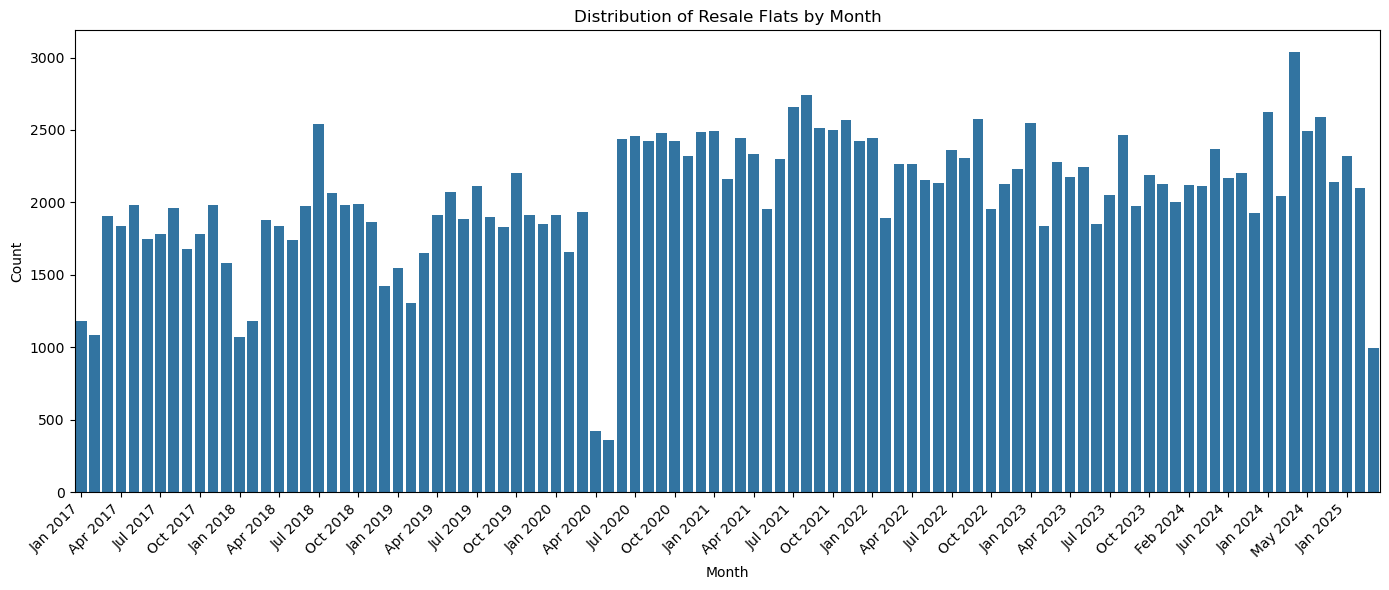

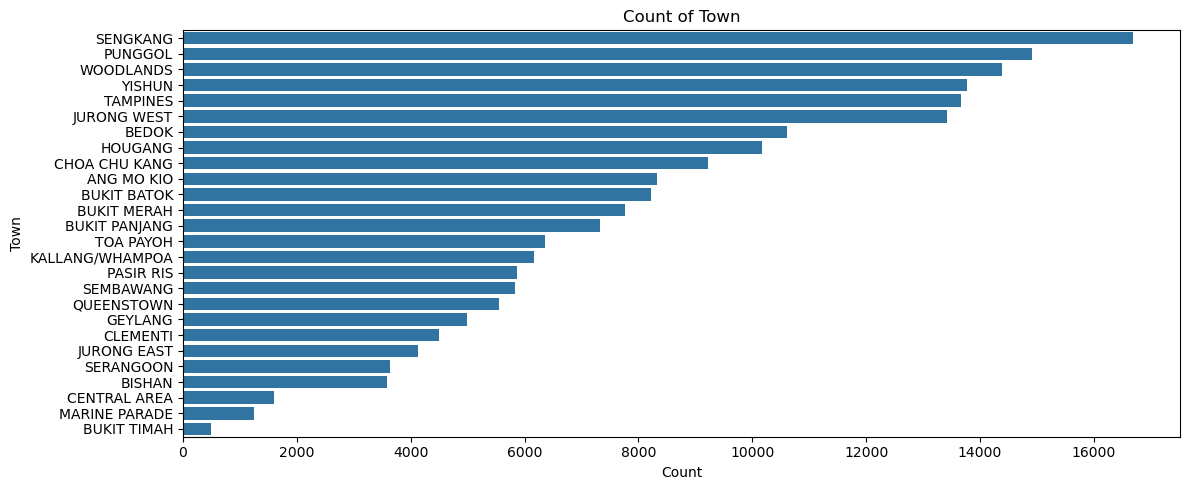

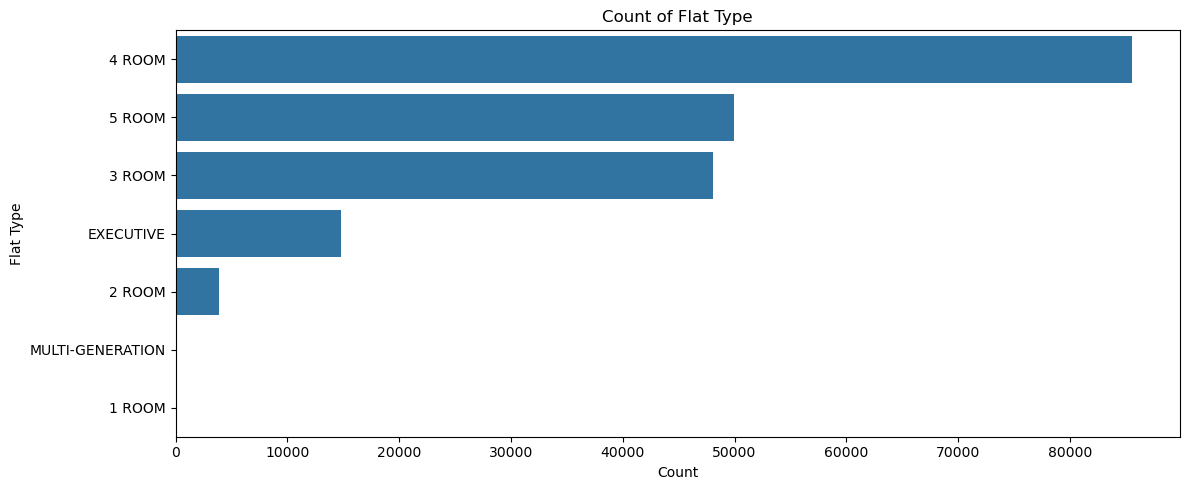

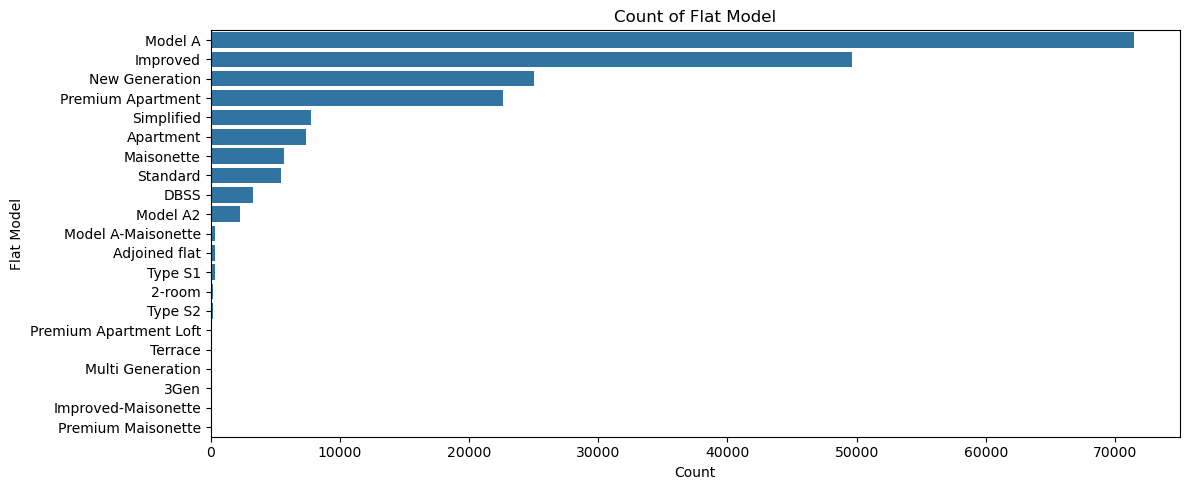

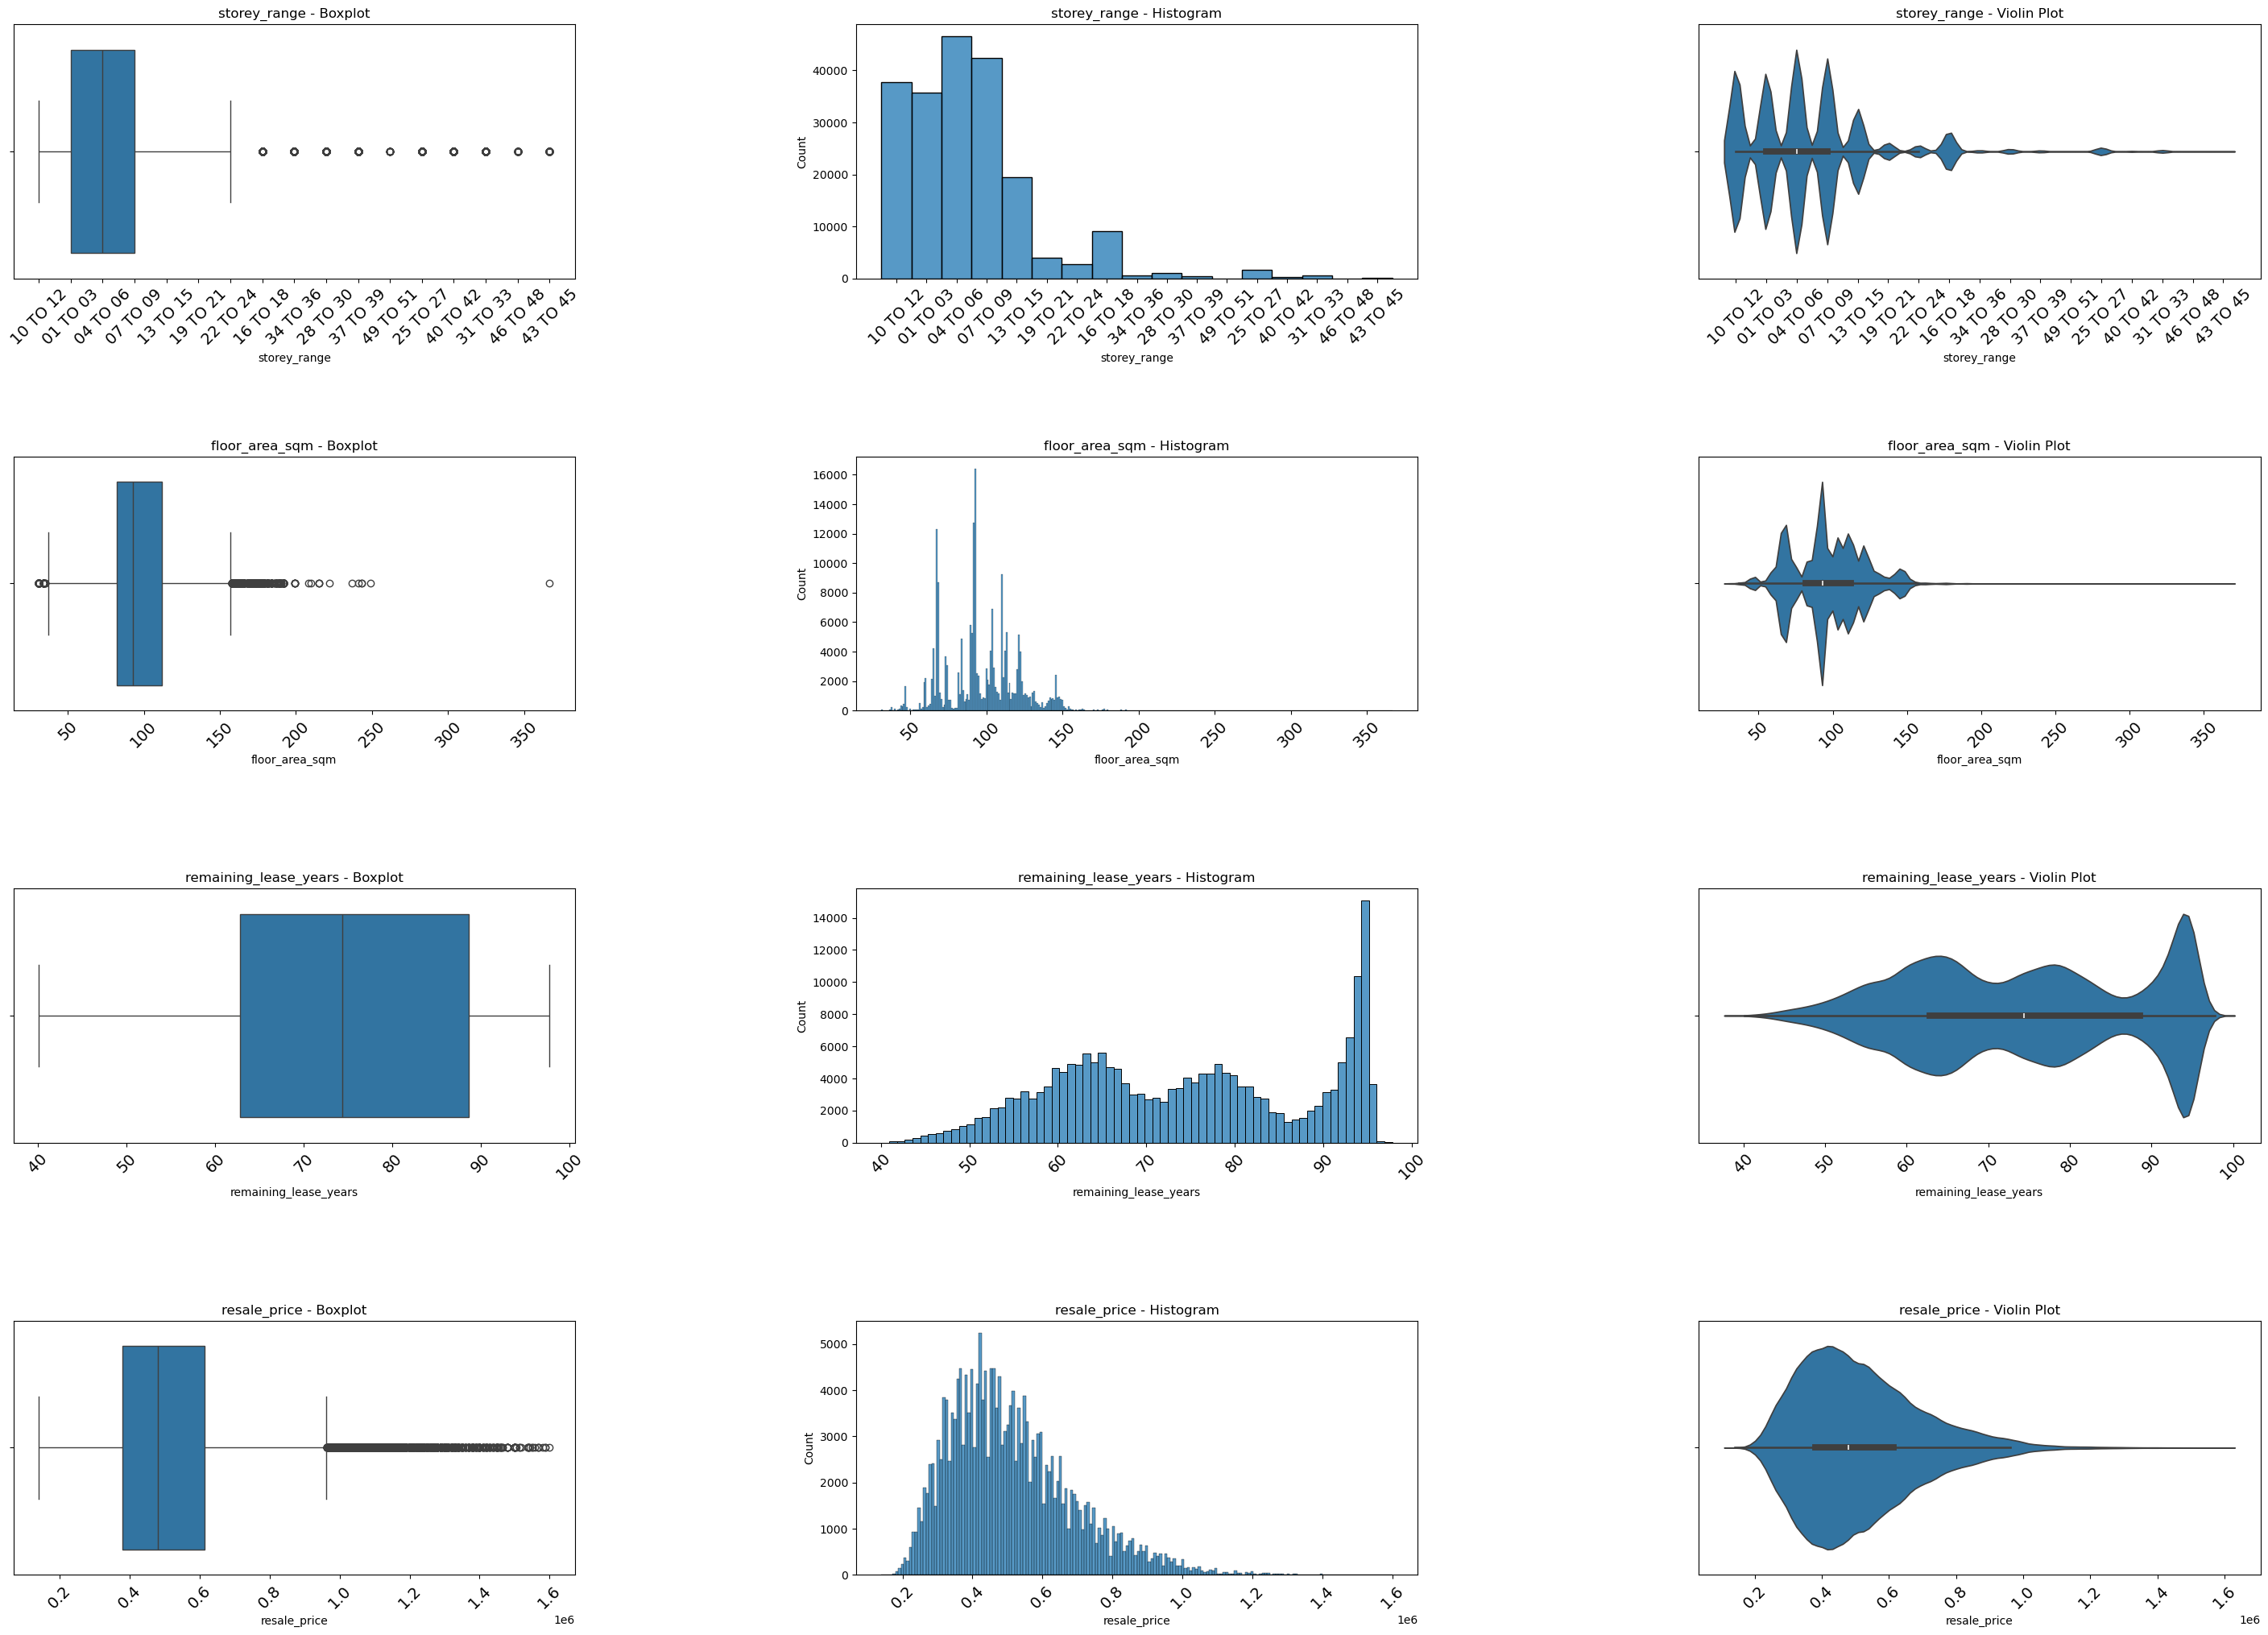

In [15]:
# Convert month to datetime
data["month"] = pd.to_datetime(data["month"])

# Month plot (count plot)
plt.figure(figsize=(14, 6))
sb.countplot(data=data, x="month")
plt.title("Distribution of Resale Flats by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(ticks=plt.xticks()[0][::3], 
           labels=[d.strftime("%b %Y") for d in data["month"].unique()[::3]],
           rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

# Set up features for different types of plotting
categorical_only = ["town", "flat_type", "flat_model"]
multi_plot = ["storey_range", "floor_area_sqm", "remaining_lease_years", "resale_price"]

# Plot categorical variables with bar charts
for col in categorical_only:
    plt.figure(figsize=(12, 5))
    sb.countplot(data=data, y=col, order=data[col].value_counts().index)
    plt.title(f"Count of {col.replace('_', ' ').title()}")
    plt.xlabel("Count")
    plt.ylabel(col.replace("_", " ").title())
    plt.tight_layout()
    plt.show()

# Now do the 3-plot layout for the rest
f, axes = plt.subplots(len(multi_plot), 3, figsize=(36, 25))
plt.subplots_adjust(hspace=0.7, wspace=0.5)

for idx, column in enumerate(multi_plot):
    sb.boxplot(data=data[column], orient="h", ax=axes[idx, 0])
    sb.histplot(data=data[column], ax=axes[idx, 1])
    sb.violinplot(data=data[column], orient="h", ax=axes[idx, 2])
    
    # Label axes for clarity
    axes[idx, 0].set_title(f"{column} - Boxplot")
    axes[idx, 1].set_title(f"{column} - Histogram")
    axes[idx, 2].set_title(f"{column} - Violin Plot")

    for ax in axes[idx]:
        ax.tick_params(axis='x', rotation=45, labelsize=14)

plt.show()

### Distribution of Resale Flats by Month

The bar chart above shows the frequency of HDB resale transactions from January 2017 to March 2025.

**Observations:**
- Transaction volume remains relatively consistent across the years, typically ranging between 1,500 and 2,500 per month.
- There is a noticeable dip in transactions around early 2020, likely due to the impact of the COVID-19 pandemic and related restrictions.
- Post-2020, the volume of transactions recovered and remained relatively stable with periodic spikes, potentially influenced by policy changes or market sentiment.
- A significant increase in activity is observed in certain months (e.g., late 2024), which may correspond to seasonal patterns, government grants, or market-driven behavior.
- Recent months (early 2025) show a slight drop, possibly due to incomplete data
  
**Conclusion:**
Understanding the distribution of resale activity over time provides useful context for identifying temporal trends, policy impacts, and seasonal effects in the HDB resale market. This also helps validate the temporal consistency of the dataset for modeling resale prices. We will not be cleaning the removing anomalies during the Covid-19 period as this is part of fluctuations in the economy and is valuable to training our model for future price rises.

### Distribution of Resale Transactions by Town

The horizontal bar chart above shows the total number of HDB resale transactions in each town from January 2017 to March 2025.

**Observations:**
- **Sengkang and Punggol** recorded the highest number of transactions, each with over 13,000 resale deals, could be due to both being relatively new neighbourhoods.
- Towns like **Woodlands, Yishun, and Jurong West** also show consistently high resale volumes, reflecting their large flat populations and mature estates.
- **Bukit Timah, Marine Parade, and Central Area** have the fewest resale transactions, likely due to their smaller public housing stock or higher private property presence.
- The top towns are largely located in non-central, residential-heavy areas where larger HDB developments are concentrated.

**Conclusion:**
This distribution highlights that the resale market is most active in newer and densely developed towns such as Sengkang and Punggol. Town-level analysis is crucial in modeling and interpreting price trends, as location remains one of the most significant factors affecting resale value.

### Distribution of Flat Models

The chart above shows the frequency of each flat model type in the dataset.

- Most common models are **Model A**, **Improved**, and **New Generation**, which together make up the majority of transactions.
- Less common models like **Maisonette**, **DBSS**, and **Terrace** appear far less frequently.
- Several rare flat models exist but occur in very low numbers.

This analysis helps us understand which flat models dominate the resale market and informs which ones may have limited data for modeling. But because Flat Model can be closely related to Flat Type, we may drop this category

### Distribution of Numerical and Ordinal Variables

The histograms, box plots and violin plots above show the distribution of other key numeric and ordinal variables:

- **storey_range**: Most resale flats fall within the lower storey ranges (10 to 18 floors).
- **floor_area_sqm**: Flat sizes are concentrated around common HDB layouts (e.g., 60–110 sqm).
- **remaining_lease_years**: Lease values range widely, with a noticeable spike near the 99-year mark and gradual tapering toward lower lease durations.
- **resale_price**: Most transactions are priced between `$300,000` and `$600,000`, with the peak around `$400,000`. The distribution is right-skewed due to a smaller number of high-value transactions above `$1 million`.

These distributions help us understand the typical configurations and pricing of flats in the resale market, guiding preprocessing decisions and model selection.


---



## 3.2 Univariate Analysis with Respect to Resale Price

In this section, we analyze the relationship between each individual variable and the `resale_price` to understand their standalone impact. This helps identify which features may have stronger influence on pricing and guides feature selection for modeling.

The variables examined include:

- **month**: To observe trends or fluctuations in resale prices over time.
- **town**: To compare average resale prices across different towns.
- **flat_type**: To assess how flat type affects resale pricing.
- **storey_range**: To examine whether the floor level range influences resale price.
- **floor_area_sqm**: To evaluate how floor area correlates with resale price.
- **flat_model**: To explore price variation across different HDB flat models.
- **remaining_lease_years**: To understand the effect of remaining lease on resale price.
- **resale_price**: Distribution analysis to detect skewness, outliers, and overall range.

Each variable is independently visualized or summarized against resale price to reveal patterns or correlations before any multivariate modeling is performed.



## 3.3 Resale Price for Each Month from 2017 - 2025

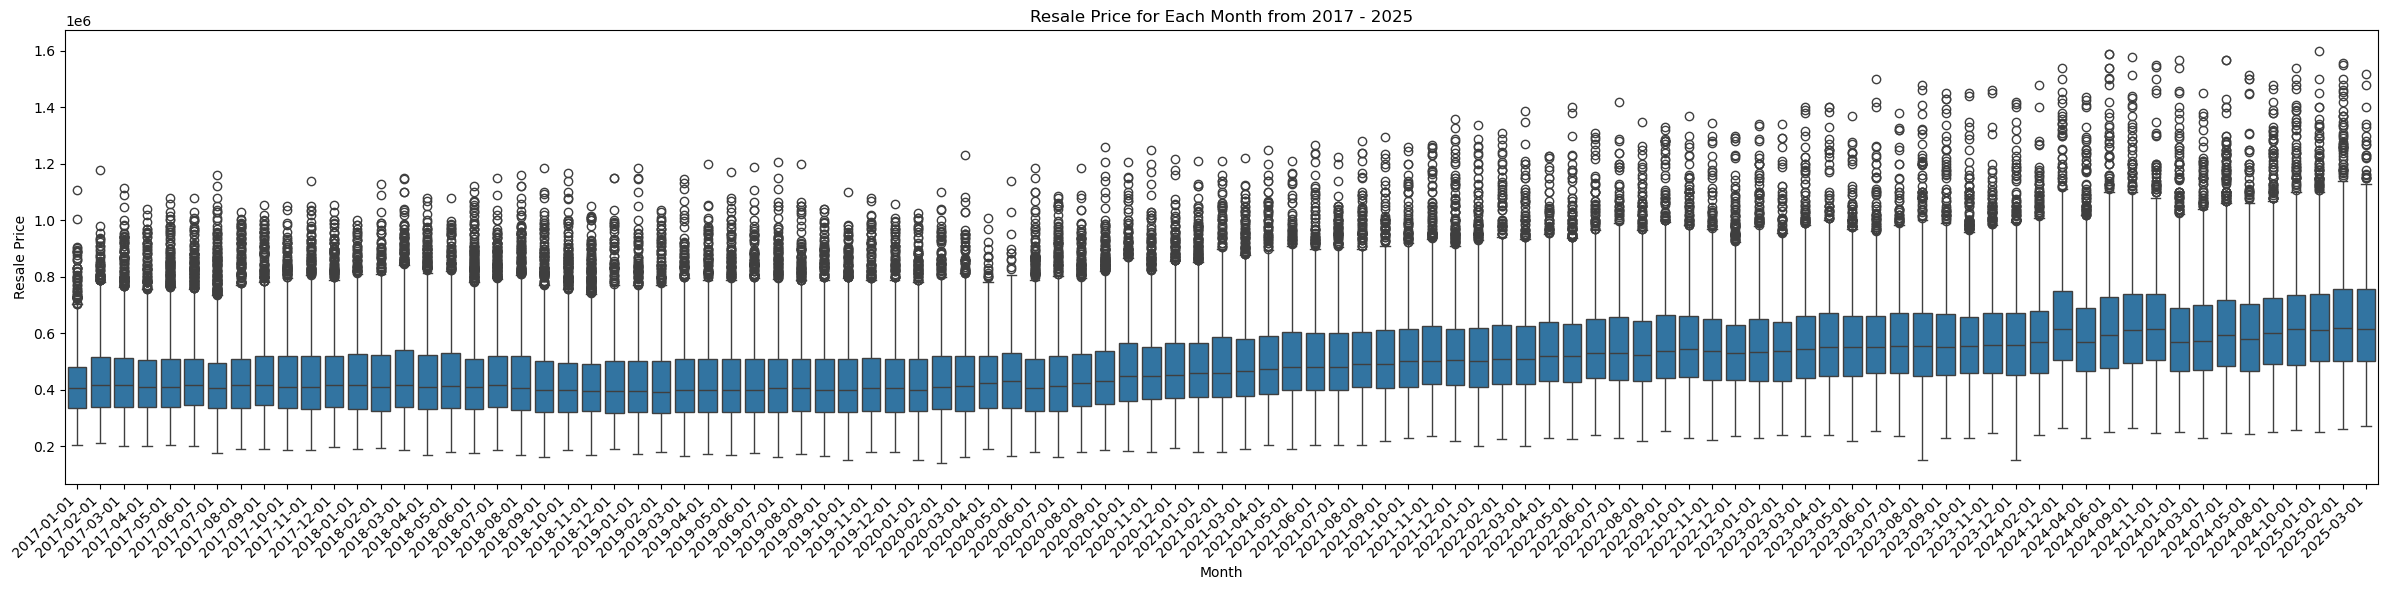

In [19]:
plt.figure(figsize=(24, 6))

# Create boxplot
sb.boxplot(x="month", y="resale_price", data=data)

# Format x-axis
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.xlabel("Month")
plt.ylabel("Resale Price")
plt.title("Resale Price for Each Month from 2017 - 2025")
plt.tight_layout()

plt.show()

#### Resale Price for Each Month from 2017 - 2025

The boxplot above shows the monthly distribution of resale prices from 2017 to early 2025.

- There is a **clear upward trend** in median resale prices over the years.
- The **price range has widened**, indicating increased variability in the market.

This suggests a general **appreciation of HDB resale prices over time**, possibly influenced by market demand, policy shifts, or economic recovery.


In [21]:
month_plus_resaleprice = pd.concat([data["month"], data["resale_price"]] , axis = 1).reindex(data["month"].index)
month_plus_resaleprice

month  resale_price
0      2017-01-01      232000.0
1      2017-01-01      250000.0
2      2017-01-01      262000.0
3      2017-01-01      265000.0
4      2017-01-01      265000.0
...           ...           ...
202394 2025-02-01      830000.0
202395 2025-02-01      818888.0
202396 2025-01-01      960000.0
202397 2025-02-01      868888.0
202398 2025-02-01     1100888.0

[202399 rows x 2 columns]

/var/folders/th/hhm7jwtd2t9g83v7l2pkm3f80000gp/T/ipykernel_2181/1148789234.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax_joint.set_xticklabels(


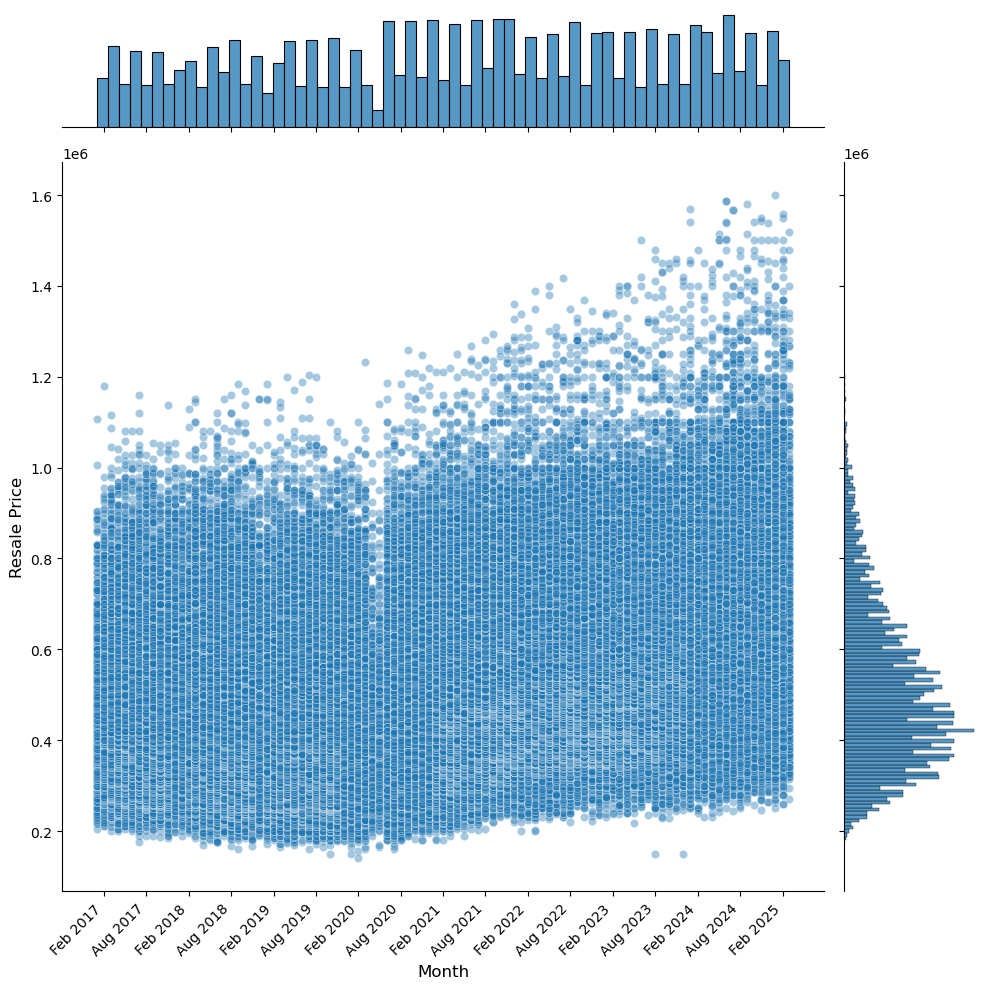

In [22]:
# Create figure and axes
g = sb.jointplot(
    data=month_plus_resaleprice,
    x="month",
    y="resale_price",
    kind="scatter",
    height=10,
    alpha=0.4  # transparency to reduce overplotting
)

# Format x-axis labels
g.ax_joint.set_xticklabels(
    g.ax_joint.get_xticklabels(),
    rotation=45,
    ha="right",
    fontsize=10
)

# Format x-axis ticks (e.g., every 3 months)
g.ax_joint.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.ax_joint.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Axis labels and title
g.set_axis_labels("Month", "Resale Price", fontsize=12)
plt.tight_layout()
plt.show()

#### Scatter Plot of Resale Price for Each Month from 2017 - 2025

The scatter plot shows the individual resale transactions from 2017 to 2025.

- A **gradual upward trend** in resale prices is clearly observed over the years.
- The **density of higher-priced transactions** increases significantly after 2020, with more units crossing the $1 million mark.
- The data distribution also becomes **wider over time**, indicating increased price dispersion.

This plot further supports the trend of **rising HDB resale prices**, along with growing variability in the market.

## 3.4 Annual Resale Price Distribution (2017–2025)

<Axes: xlabel='year', ylabel='resale_price'>

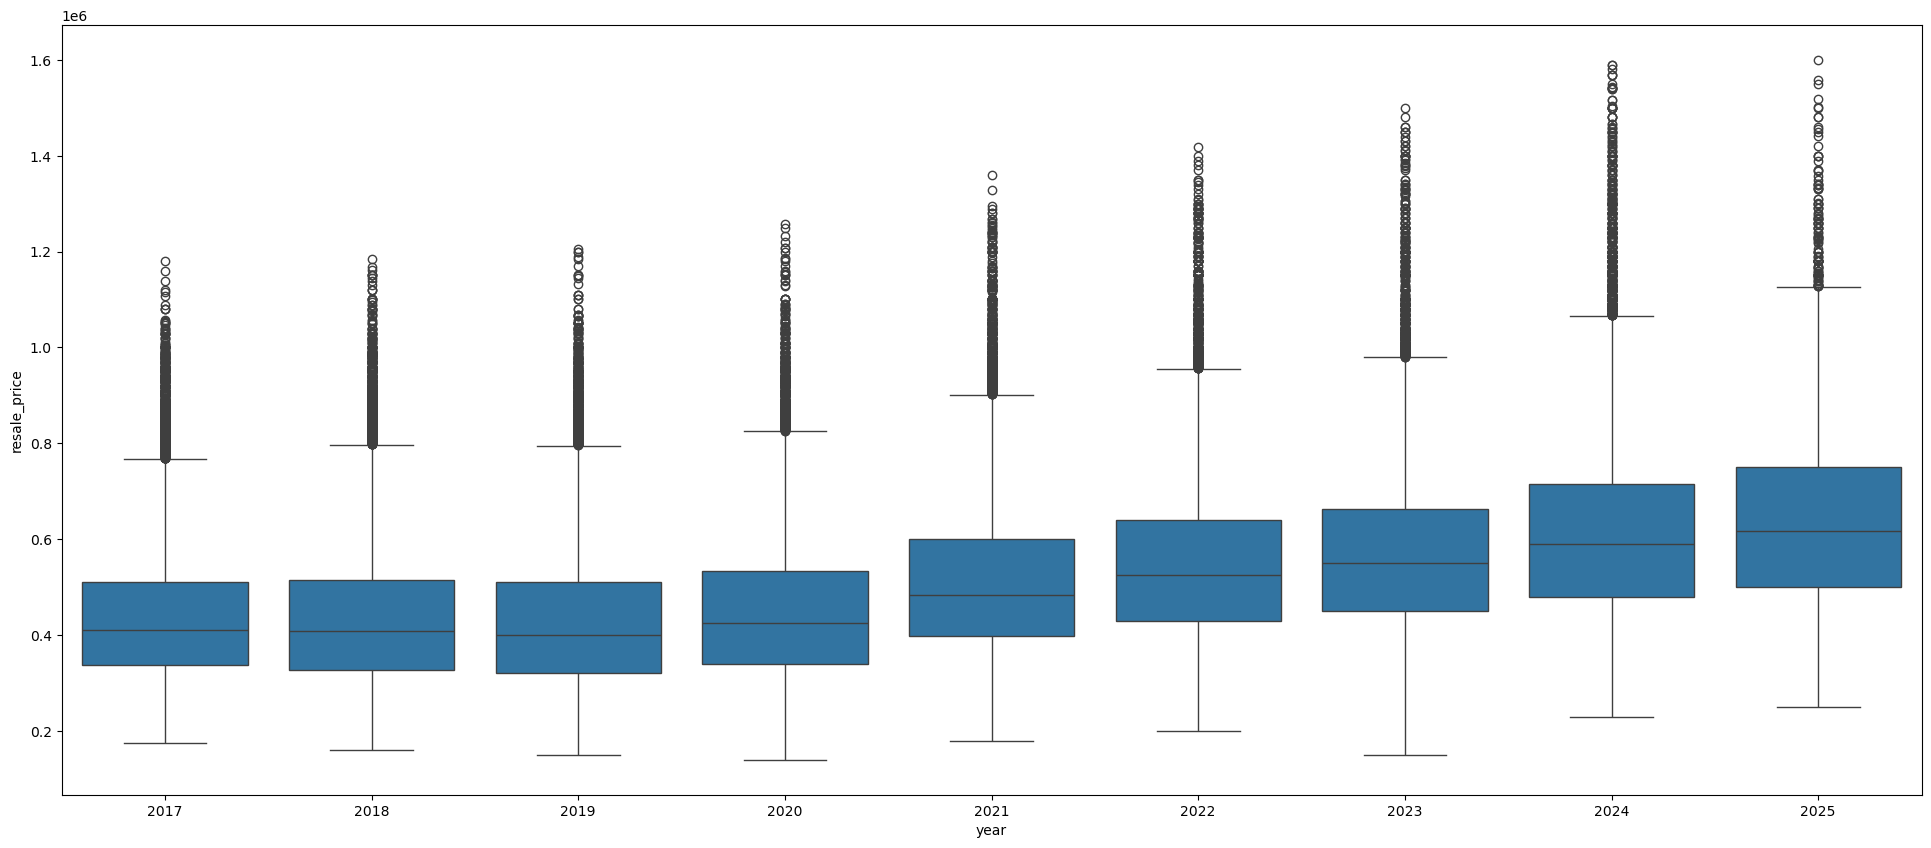

In [25]:
data['year'] = data['month'].astype(str).str[:4]

f = plt.figure(figsize = (24,10))
sb.boxplot(x = "year", y = "resale_price", data = data)

#### Annual Resale Price Distribution (2017–2025)

The boxplot above shows the distribution of resale prices for each year from 2017 to 2025.

- There is a **clear upward shift** in median resale prices year over year.
- The **spread of prices** also increases over time, indicating a broader price range in recent years.

This reinforces the trend of **steady price appreciation** in the HDB resale market over the past decade.

### Resale Prices in 2024

<Axes: xlabel='month', ylabel='resale_price'>

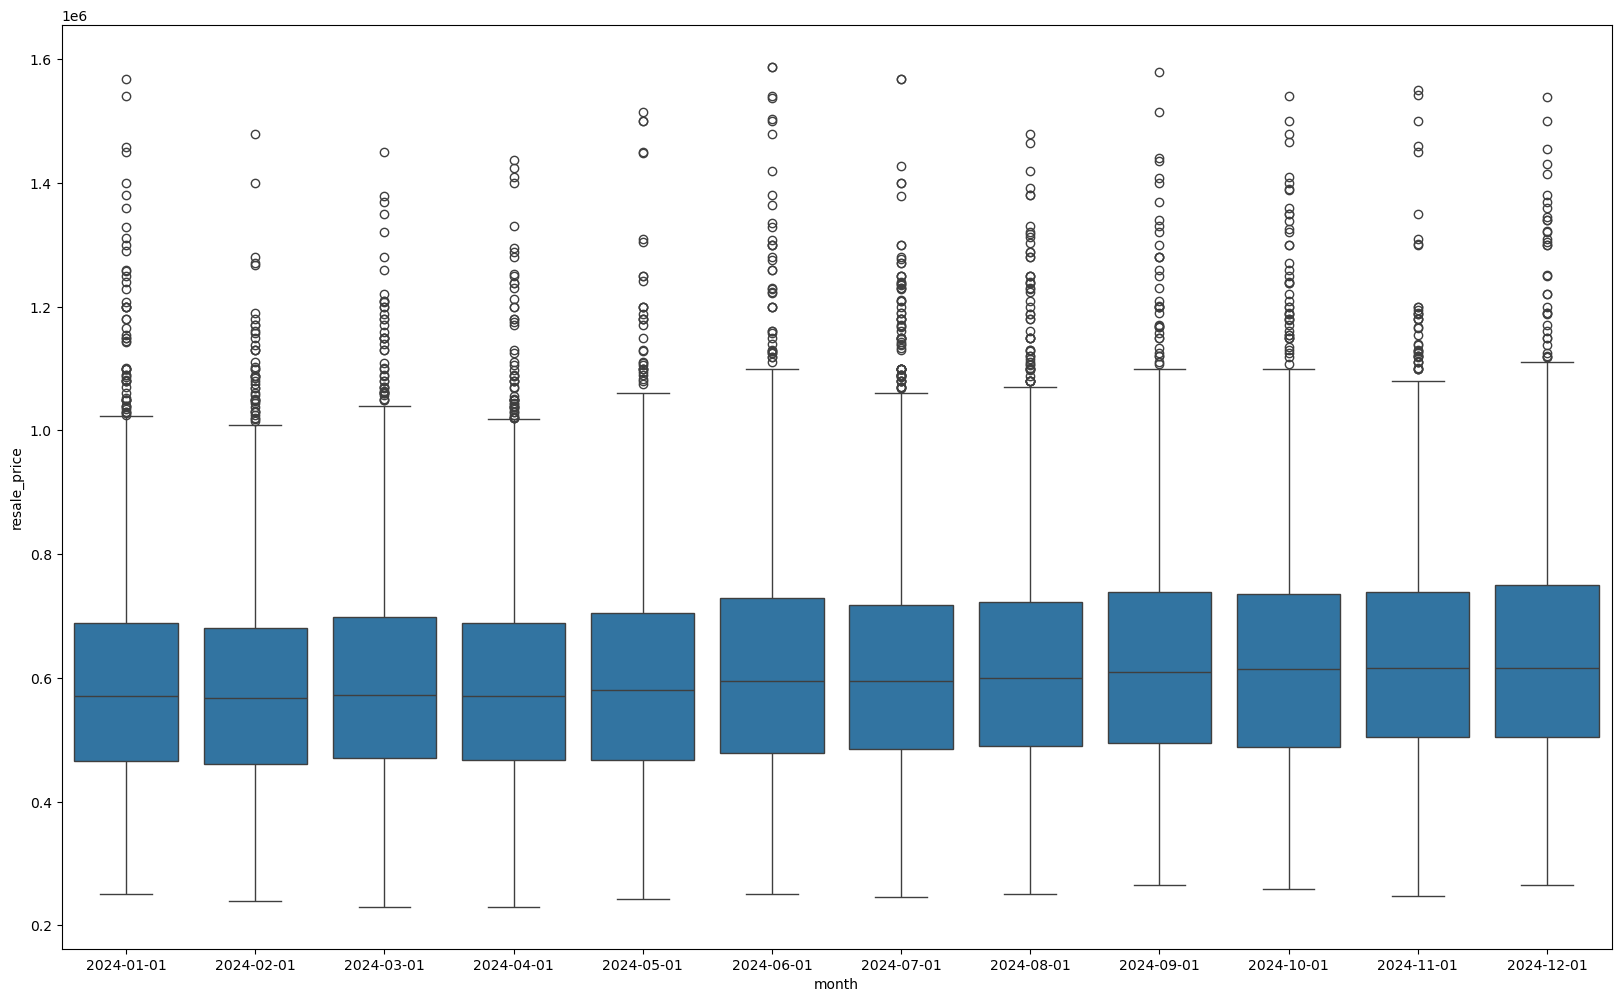

In [28]:
data_2024 = data[data['year'] == '2024']
order = sorted(data_2024['month'].unique())


f = plt.figure(figsize=(20, 12))
sb.boxplot(x="month", y="resale_price", data=data_2024, order = order)

#### Monthly Resale Price Distribution in 2024

The boxplot above shows the monthly distribution of resale prices throughout 2024.

- Median resale prices remained relatively **stable across the year**, with slight fluctuations.
- The overall price range and number of high-value outliers are consistent month to month.
- Indicates a **steady market** in 2024 without major pricing shocks or volatility.


## 3.5 Resale Price in Each Town

<Axes: xlabel='town', ylabel='resale_price'>

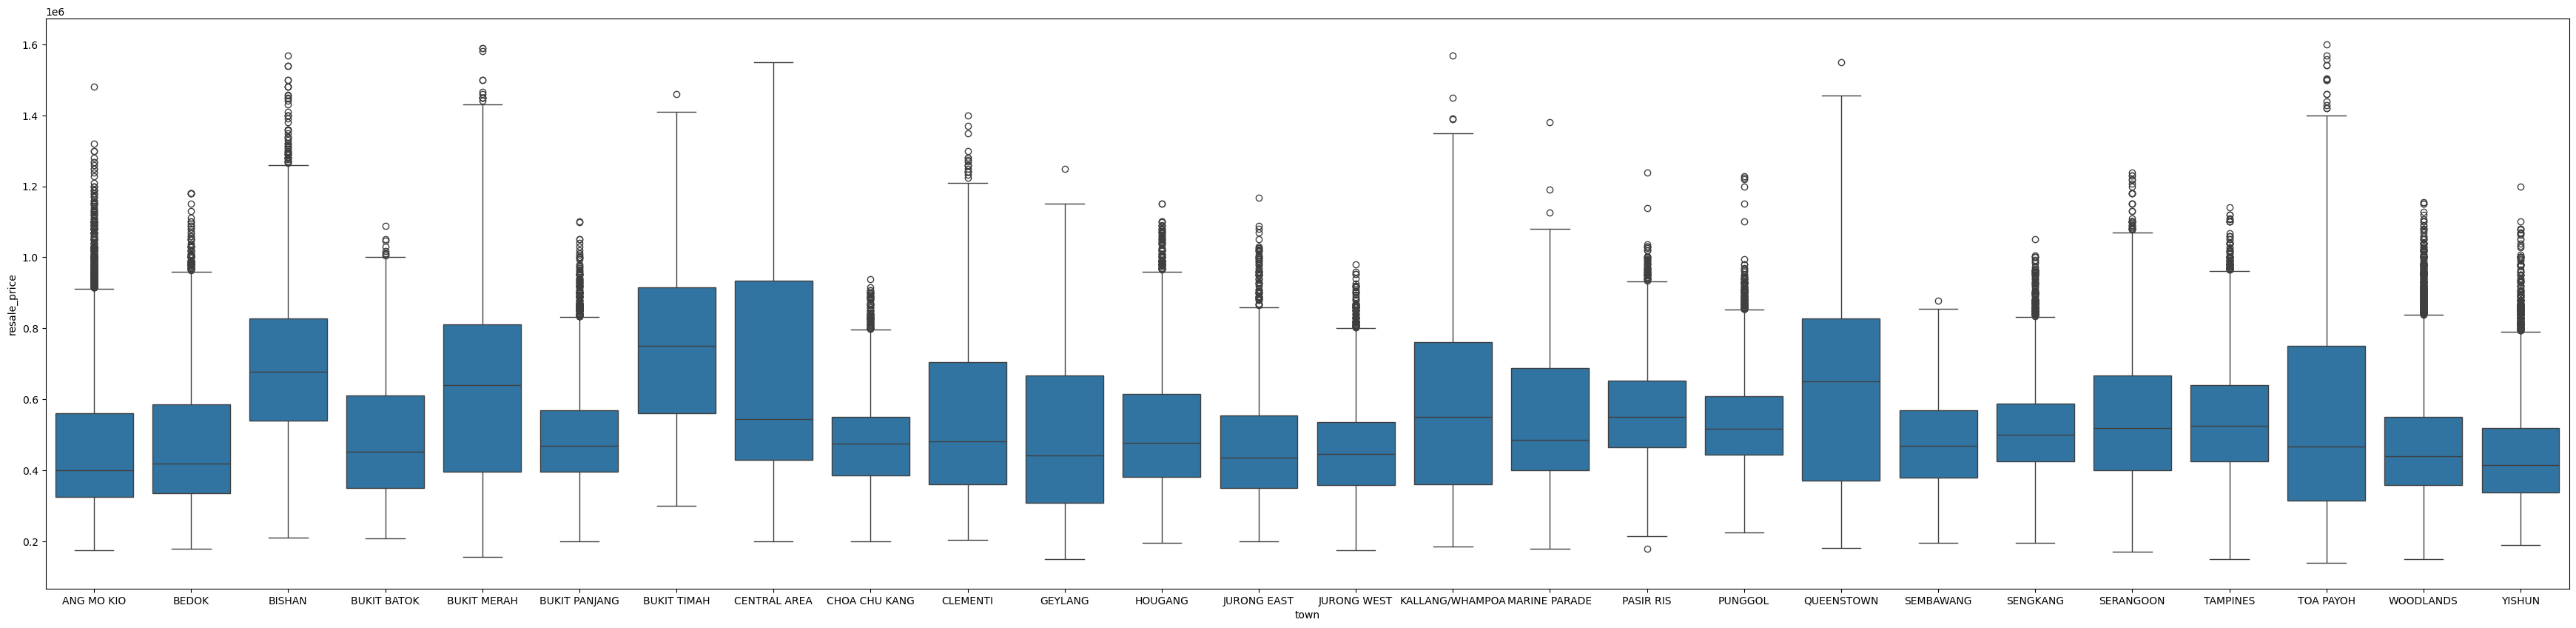

In [31]:
f = plt.figure(figsize = (44,10))
sb.boxplot(x = "town", y = "resale_price", data = data)

### Resale Price Distribution by Town (Boxplot)

The boxplot above shows the distribution of resale prices across different HDB towns.

- **Bukit Timah**, **Central Area**, and **Bishan** exhibit the highest median and upper-range resale prices, indicating their status as premium or centrally located towns.
- **Yishun**, **Woodlands**, **Jurong West**, and **Sembawang** have lower median prices, reflecting their affordability and location further from the city center.
- The wide interquartile ranges and presence of outliers in towns like **Queenstown** and **Bukit Merah** suggest a diverse mix of flat types and price points.

This town-level view reinforces the importance of location in determining resale value and highlights disparities in housing accessibility across different regions in Singapore.

In [234]:
# Group by town and calculate average resale price
town_price_rank = data.groupby('town')['resale_price'].mean().sort_values(ascending=False).reset_index()

# Add ranking column (1 = highest average resale price)
town_price_rank['rank'] = town_price_rank['resale_price'].rank(ascending=False, method='min').astype(int)

# Reorder columns
town_price_rank = town_price_rank[['rank', 'town', 'resale_price']]

# Sort by rank
town_price_rank = town_price_rank.sort_values('rank')

# Display the table
print(town_price_rank.to_string(index=False))

 rank            town  resale_price
    1     BUKIT TIMAH 756560.639760
    2          BISHAN 694205.445807
    3    CENTRAL AREA 674815.768936
    4     BUKIT MERAH 624018.007557
    5      QUEENSTOWN 623360.144900
    6 KALLANG/WHAMPOA 576848.212156
    7       PASIR RIS 569254.475315
    8       SERANGOON 550581.837976
    9   MARINE PARADE 549869.763188
   10       TOA PAYOH 544426.183054
   11        TAMPINES 543834.217051
   12        CLEMENTI 540466.860759
   13         PUNGGOL 529980.320370
   14        SENGKANG 512902.102622
   15         HOUGANG 507137.768926
   16         GEYLANG 495051.336627
   17   BUKIT PANJANG 489187.623030
   18     BUKIT BATOK 485968.749454
   19       SEMBAWANG 481461.713506
   20   CHOA CHU KANG 477213.940936
   21           BEDOK 468708.430888
   22      ANG MO KIO 466736.686510
   23       WOODLANDS 464982.976306
   24     JURONG EAST 463073.626243
   25     JURONG WEST 451418.495139
   26          YISHUN 438062.890234


### Average Resale Price Ranking by Town

Based on mean resale prices:

1. **Bukit Timah**, **Bishan**, and **Central Area** rank highest in average resale price.
2. **Jurong West**, **Woodlands**, and **Yishun** are among the most affordable towns.
3. The results align with expectations that central and mature towns with better amenities or connectivity tend to command higher prices.

This analysis helps highlight the influence of location on HDB resale prices and can be valuable for both buyers and policymakers when evaluating pricing fairness or affordability by region.

However, it's important to note that average resale prices may be influenced by differences in flat size across towns.  
To account for this, a better comparison would be to analyze **resale price per square meter** in each town, which standardizes price relative to floor area and allows for a more accurate assessment of value.








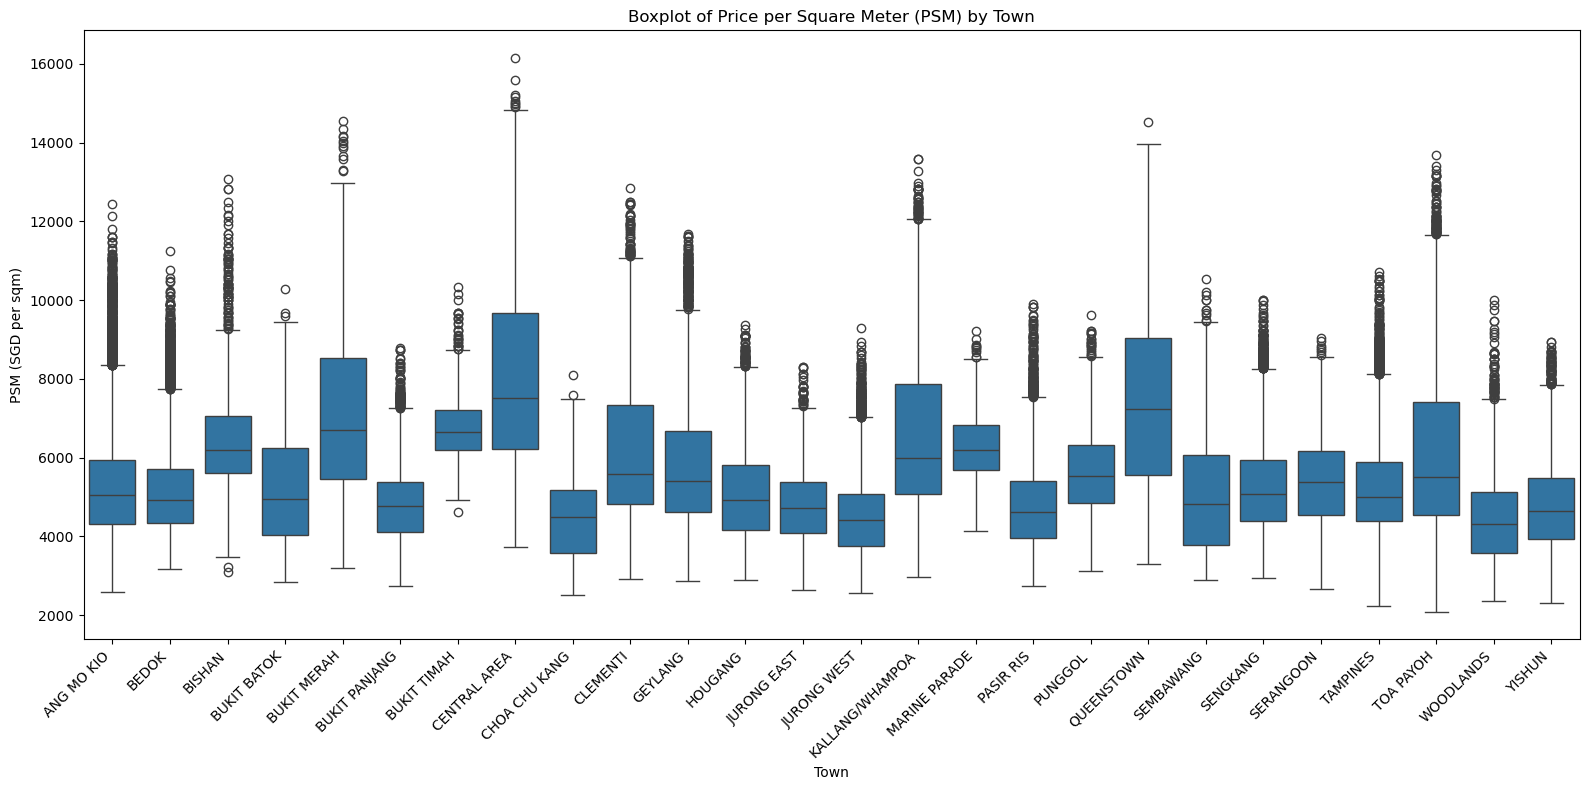

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.boxplot(data=data, x='town', y='psm')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Town')
plt.ylabel('PSM (SGD per sqm)')
plt.title('Boxplot of Price per Square Meter (PSM) by Town')
plt.tight_layout()
plt.show()

#### Price per Square Meter (PSM) by Town

This boxplot shows the distribution of resale prices normalized by flat size (PSM) across towns.

- Towns like **Central Area**, **Queenstown**, and **Bukit Merah** have the **highest PSM values**, reflecting premium locations with smaller but more expensive flats.
- **Jurong West**, **Yishun**, and **Woodlands** continue to appear on the lower end of the PSM spectrum, confirming their relative affordability even after adjusting for floor area.

Using PSM provides a **fairer basis for comparing flat values** across towns, as it accounts for differences in flat size and reveals more accurate trends in relative housing costs.

In [40]:
# Group by town and calculate average PSM
town_psm_rank = data.groupby('town')['psm'].mean().sort_values(ascending=False).reset_index()

# Add ranking column (1 = highest PSM)
town_psm_rank['rank'] = town_psm_rank['psm'].rank(ascending=False, method='min').astype(int)

# Reorder columns
town_psm_rank = town_psm_rank[['rank', 'town', 'psm']]

# Sort by rank
town_psm_rank = town_psm_rank.sort_values('rank')

# Display the table
print(town_psm_rank.to_string(index=False))


 rank            town         psm
    1    CENTRAL AREA 8042.292302
    2      QUEENSTOWN 7387.332802
    3     BUKIT MERAH 7086.130988
    4     BUKIT TIMAH 6846.914282
    5 KALLANG/WHAMPOA 6567.601937
    6          BISHAN 6418.298120
    7   MARINE PARADE 6264.622625
    8        CLEMENTI 6189.463720
    9       TOA PAYOH 6121.375663
   10         GEYLANG 5821.782181
   11         PUNGGOL 5596.796196
   12       SERANGOON 5426.903523
   13      ANG MO KIO 5387.869232
   14        TAMPINES 5283.206884
   15        SENGKANG 5232.087635
   16     BUKIT BATOK 5186.659999
   17           BEDOK 5177.330556
   18         HOUGANG 5096.989609
   19       SEMBAWANG 5006.163743
   20   BUKIT PANJANG 4809.958060
   21       PASIR RIS 4791.754977
   22     JURONG EAST 4764.204826
   23          YISHUN 4763.961999
   24     JURONG WEST 4493.727795
   25   CHOA CHU KANG 4459.268974
   26       WOODLANDS 4443.690743


### Ranking of Towns by Average Price per Square Meter (PSM)

- **Central Area**, **Queenstown**, and **Bukit Merah** have the highest average PSM, indicating the most expensive areas per unit space.
- **Woodlands**, **Choa Chu Kang**, and **Jurong West** are the most affordable in terms of PSM.
- While some towns like **Bukit Timah** and **Bishan** were also high in total price, their PSM rankings are slightly lower, likely due to larger average flat sizes.

This confirms that PSM is a more meaningful measure for comparing actual cost efficiency of housing across towns.

## 3.6 Resale Price by Flat Type

<Axes: xlabel='flat_type', ylabel='resale_price'>

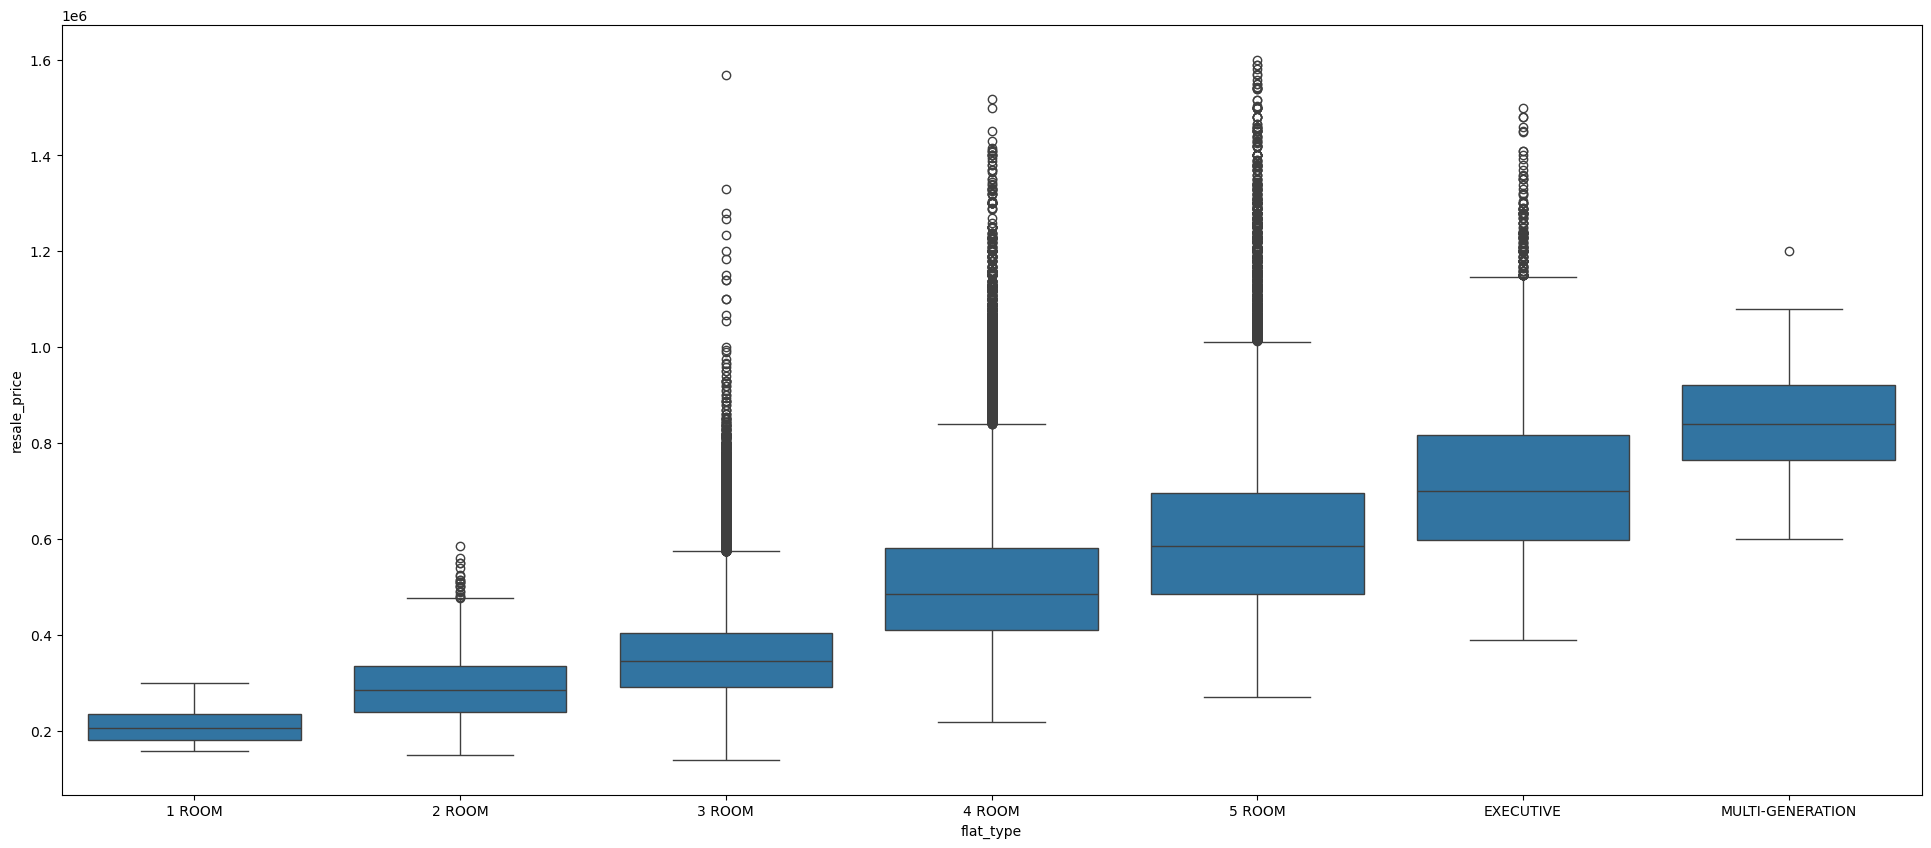

In [45]:
order = sorted(data['flat_type'].unique())
f = plt.figure(figsize = (24,10))
sb.boxplot(x = "flat_type", y = "resale_price", data = data, order = order)

#### Resale Price by Flat Type

The boxplot shows a clear upward trend in resale price with increasing flat size:

- **1-room and 2-room flats** have the lowest resale prices.
- **4-room and 5-room flats** make up the majority of mid-range transactions.
- **Executive and Multi-Generation flats** command the highest prices, with greater variability and outliers.

Larger flat types naturally fetch higher prices, reflecting their greater floor area and appeal to larger households.


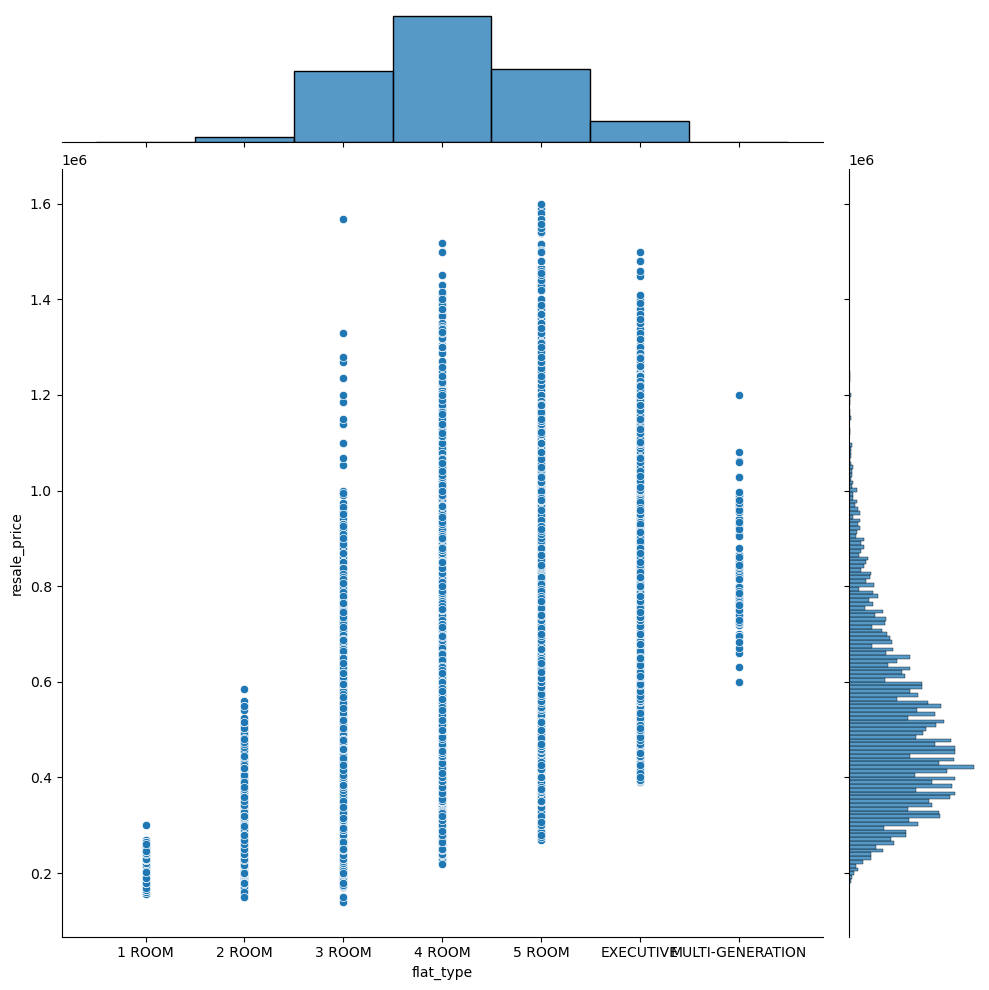

In [48]:
order = sorted(data['flat_type'].unique())


data['flat_type'] = pd.Categorical(data['flat_type'], categories=order, ordered=True)


ft_plus_resaleprice = pd.concat([data["flat_type"], data["resale_price"]] , axis = 1).reindex(data["flat_type"].index)
ft_plus_resaleprice
sb.jointplot(data = ft_plus_resaleprice, x = 'flat_type', y = 'resale_price', height = 10)

#### Scatter Plot of Resale Price by Flat Type

This scatter plot reinforces the trend observed in the boxplot:

- Resale price **increases consistently** with flat type, from 1-room to multi-generation.
- The majority of transactions are concentrated around **4-room and 5-room flats**, as shown by the histogram on top.
- Executive and multi-generation flats show **greater spread** and more high-value transactions.

This visualization confirms that flat type is a strong determinant of resale price, and that most resale activity centers around mid-sized flats.


## 3.7 Resale Price by Storey Range

<Axes: xlabel='storey_range', ylabel='resale_price'>

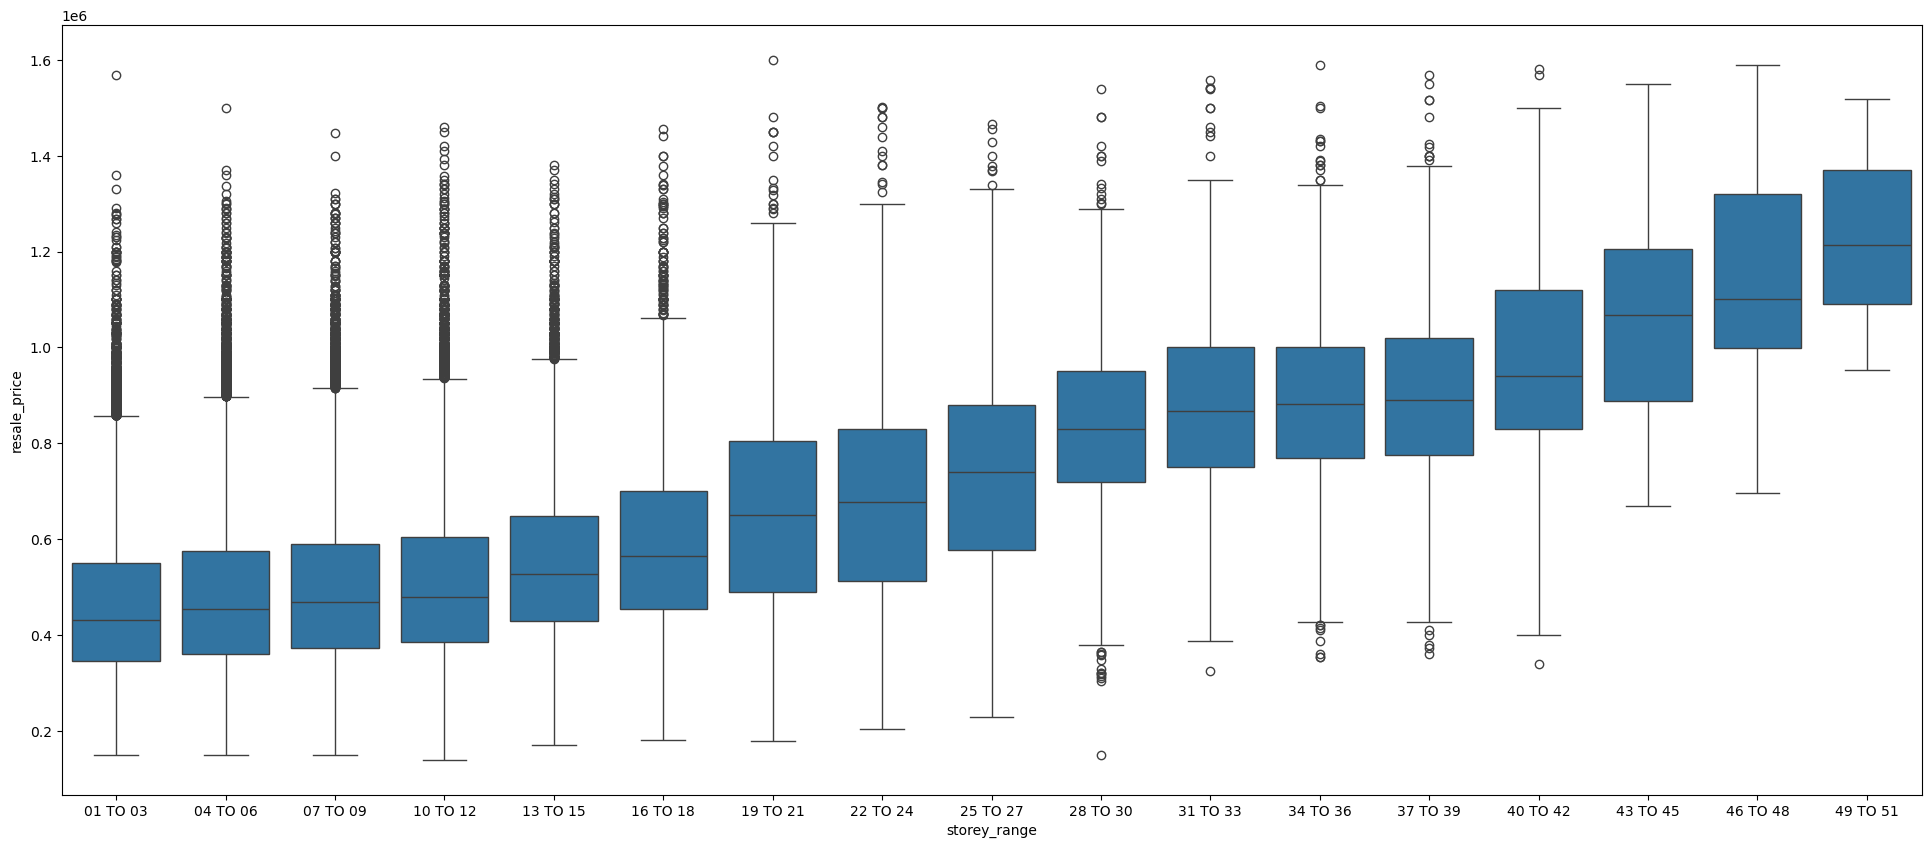

In [55]:
order = sorted(data['storey_range'].unique())
f = plt.figure(figsize = (24,10))
sb.boxplot(x = "storey_range", y = "resale_price", data = data, order = order)

#### Resale Price by Storey Range

The boxplot shows how resale price varies with the storey range of HDB flats.

- A **clear upward trend** is observed — flats on higher floors generally command **higher prices**.
- This pattern could be due to better views and newer developments having higher floors
- Lower-floor flats (e.g., 01 to 06) tend to have **lower median prices** and less price variation.

Storey range appears to be a relevant factor influencing resale value, especially in newer high-rise estates.


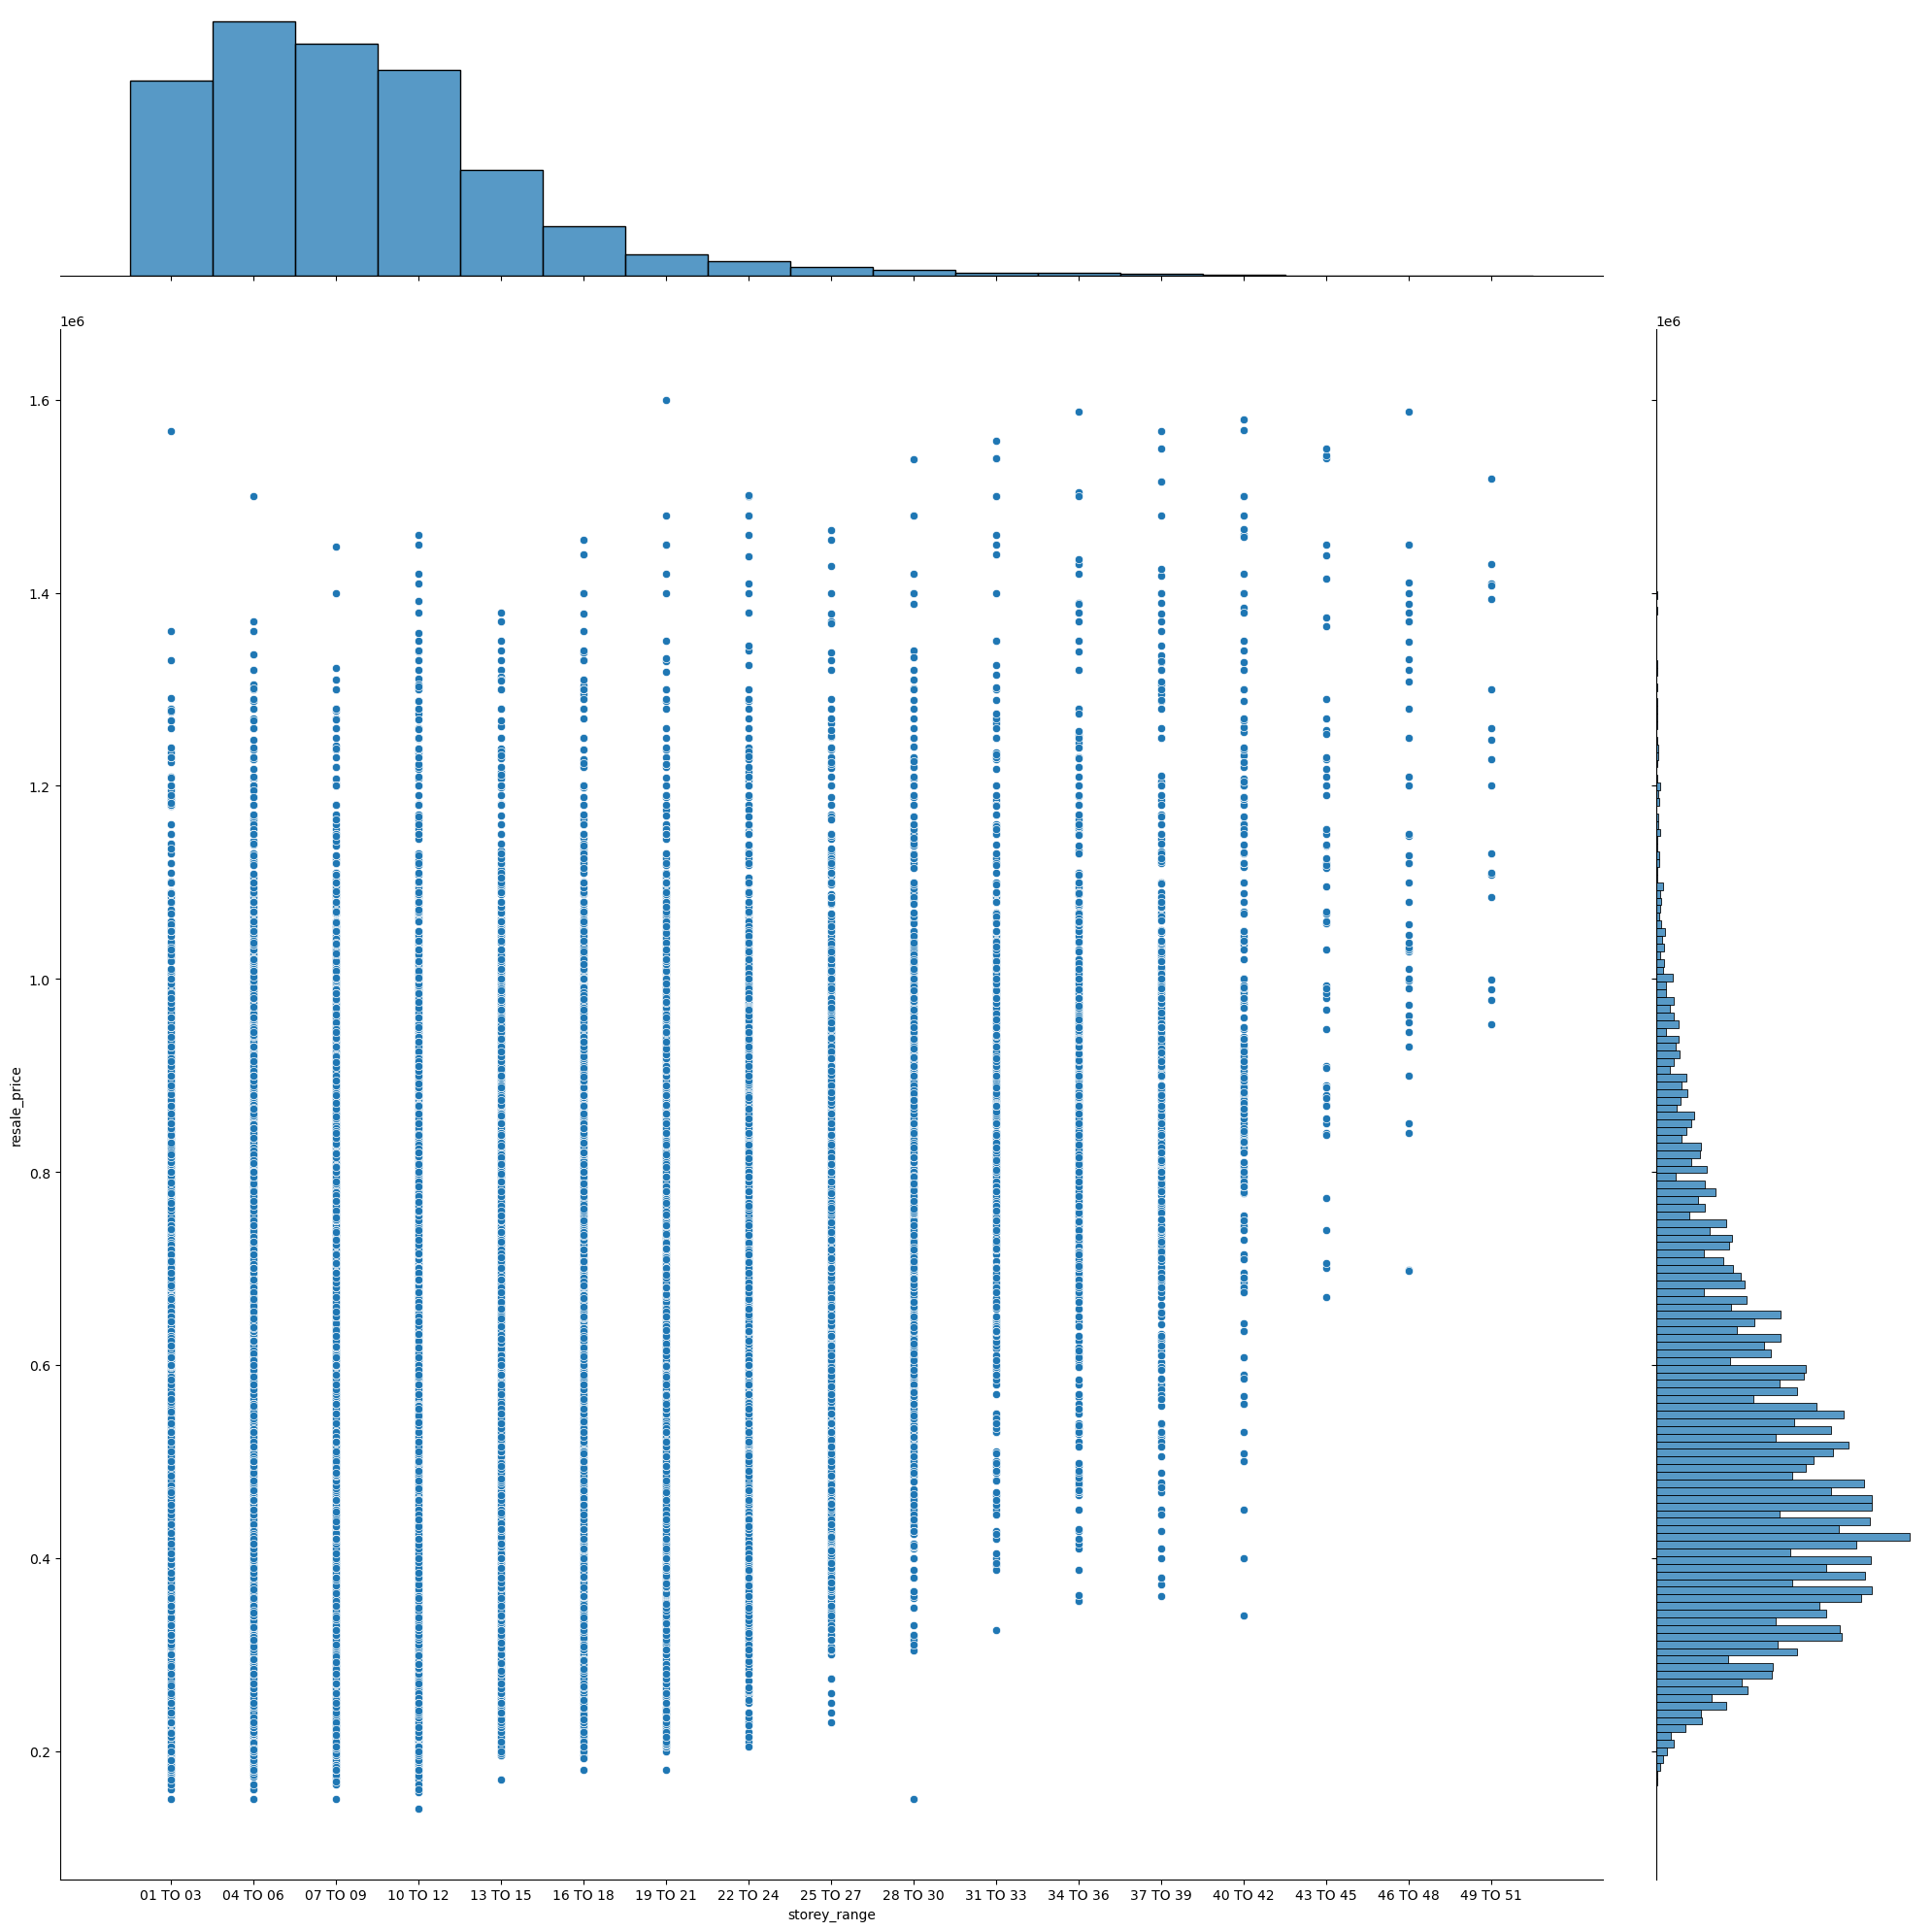

In [58]:
order = sorted(data['storey_range'].unique())


data['storey_range'] = pd.Categorical(data['storey_range'], categories=order, ordered=True)

storey_plus_resaleprice = pd.concat([data["storey_range"], data["resale_price"]] , axis = 1).reindex(data["storey_range"].index)
storey_plus_resaleprice
sb.jointplot(data = storey_plus_resaleprice, x = 'storey_range', y = 'resale_price', height = 20)

#### Scatter Plot of Resale Price by Storey Range

This scatter plot confirms the trend observed in the boxplot:

- **Higher-floor flats** (e.g., 30th storey and above) generally have **higher resale prices**, with more frequent high-value transactions.
- The **majority of resale transactions** still occur in the **lower to mid-level ranges** (01–24), as shown by the upper histogram.

Overall, storey range plays a significant role in determining flat value, and higher floors tend to attract a pricing premium.


## 3.8 Resale Price by Floor Area (sqm)


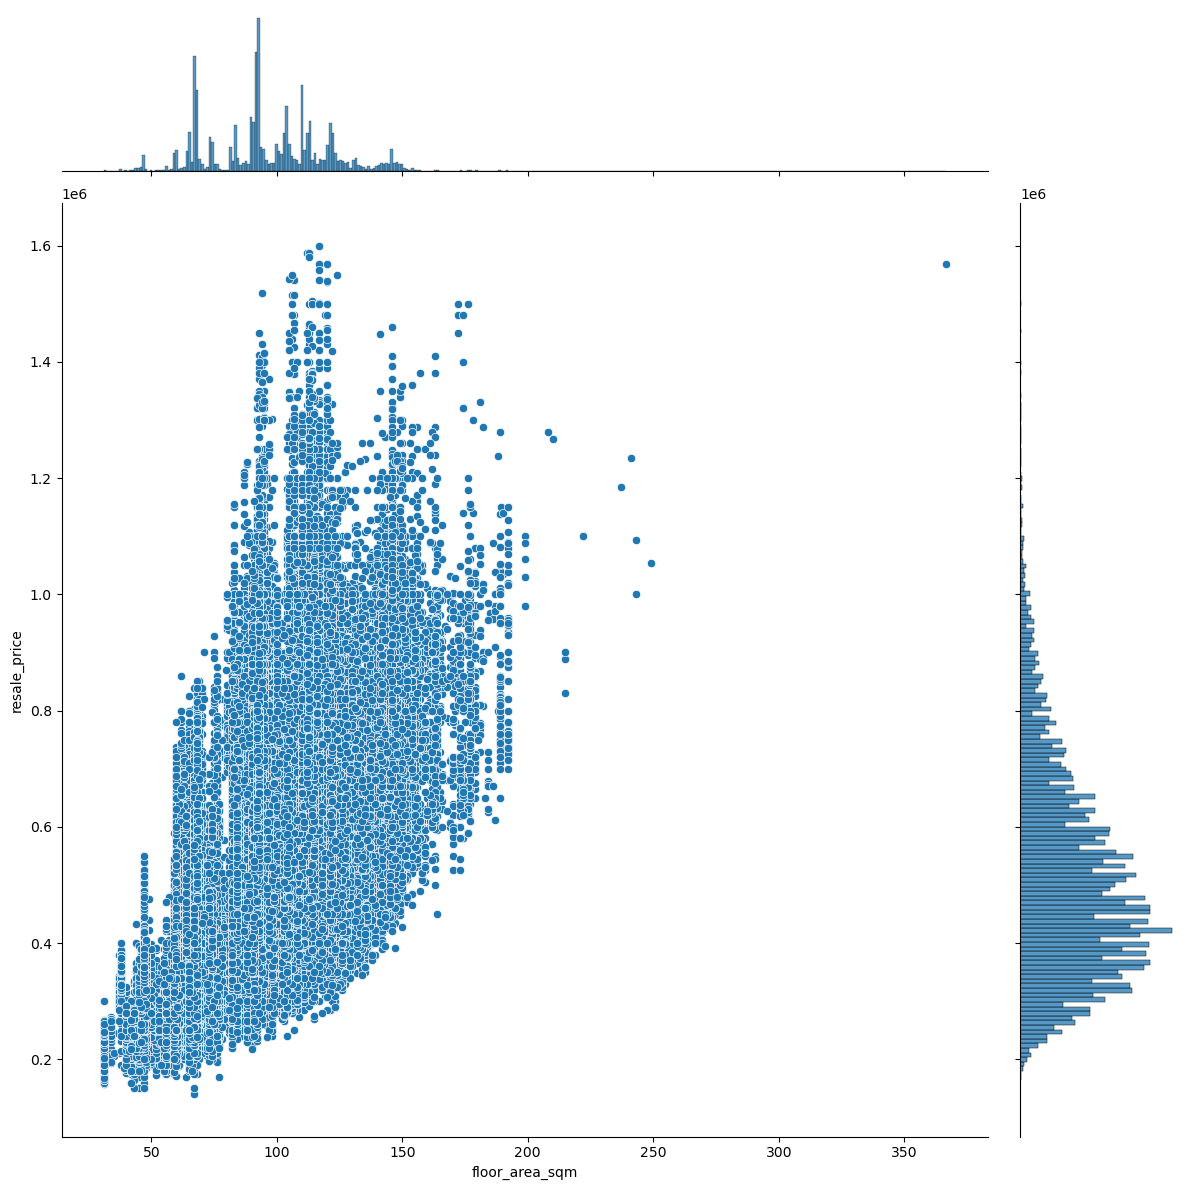

In [63]:
fa_plus_resaleprice = pd.concat([data["floor_area_sqm"], data["resale_price"]], axis = 1).reindex(data["floor_area_sqm"].index)
fa_plus_resaleprice
sb.jointplot(data = fa_plus_resaleprice, x = 'floor_area_sqm', y = 'resale_price', height = 12)

#### Scatter Plot of Resale Price vs. Floor Area

This scatter plot shows a strong **positive relationship** between floor area and resale price:

- Larger flats generally command **higher resale prices**, though with increasing variance as size increases.
- The majority of flats fall within the **60–130 sqm range**, where the relationship is more tightly clustered.
- Very large units (above 150 sqm) show more price dispersion, likely reflecting luxury or niche flat types.

This confirms floor area as one of the **strongest predictors** of resale price in the dataset.


## 3.9 Resale Price by Flat Model

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'Improved'),
  Text(1, 0, 'New Generation'),
  Text(2, 0, 'DBSS'),
  Text(3, 0, 'Standard'),
  Text(4, 0, 'Apartment'),
  Text(5, 0, 'Simplified'),
  Text(6, 0, 'Model A'),
  Text(7, 0, 'Premium Apartment'),
  Text(8, 0, 'Adjoined flat'),
  Text(9, 0, 'Model A-Maisonette'),
  Text(10, 0, 'Maisonette'),
  Text(11, 0, 'Type S1'),
  Text(12, 0, 'Type S2'),
  Text(13, 0, 'Model A2'),
  Text(14, 0, 'Terrace'),
  Text(15, 0, 'Improved-Maisonette'),
  Text(16, 0, 'Premium Maisonette'),
  Text(17, 0, 'Multi Generation'),
  Text(18, 0, 'Premium Apartment Loft'),
  Text(19, 0, '2-room'),
  Text(20, 0, '3Gen')])

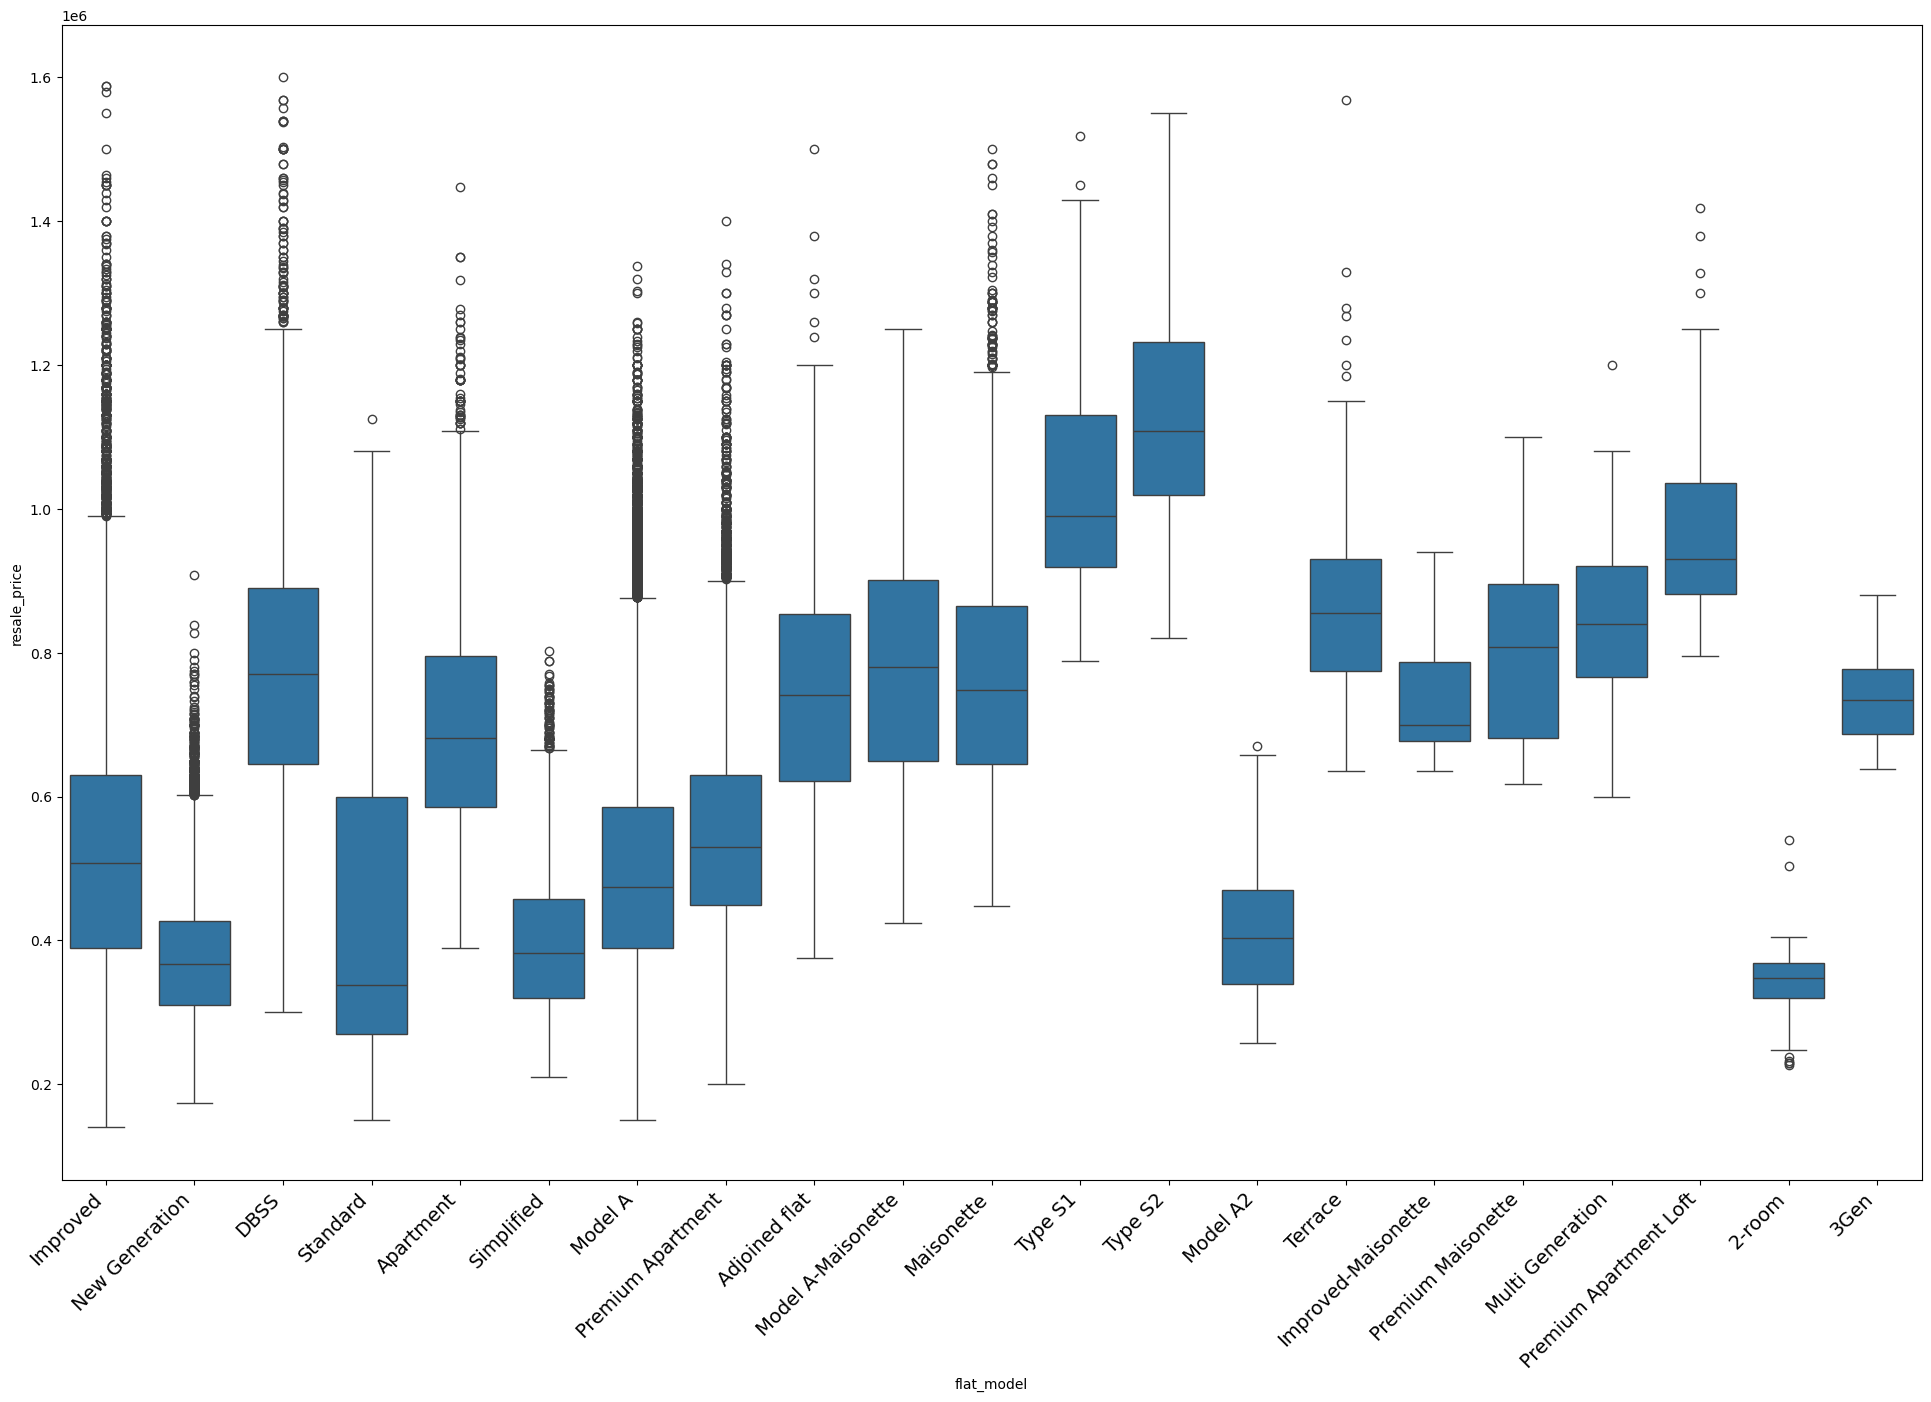

In [67]:
f = plt.figure(figsize = (24,15))
sb.boxplot(x = "flat_model", y = "resale_price", data = data)
plt.xticks(rotation=45, ha="right", fontsize=14)

#### Resale Price by Flat Model

The boxplot reveals significant variation in resale prices across different flat models:

- **Maisonette**, **Type S1/S2**, and **Premium Apartment Loft** models tend to have the **highest resale prices**, likely due to their larger sizes and premium layouts.
- More common models such as **Improved**, **New Generation**, and **Simplified** show mid-range pricing.
- **2-room**, **3Gen**, and **Model A2** models lie on the lower end of the price spectrum.

This suggests that flat model type is another important variable to consider in predicting resale price, particularly for distinguishing between premium and standard housing options.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'Improved'),
  Text(1, 0, 'New Generation'),
  Text(2, 0, 'DBSS'),
  Text(3, 0, 'Standard'),
  Text(4, 0, 'Apartment'),
  Text(5, 0, 'Simplified'),
  Text(6, 0, 'Model A'),
  Text(7, 0, 'Premium Apartment'),
  Text(8, 0, 'Adjoined flat'),
  Text(9, 0, 'Model A-Maisonette'),
  Text(10, 0, 'Maisonette'),
  Text(11, 0, 'Type S1'),
  Text(12, 0, 'Type S2'),
  Text(13, 0, 'Model A2'),
  Text(14, 0, 'Terrace'),
  Text(15, 0, 'Improved-Maisonette'),
  Text(16, 0, 'Premium Maisonette'),
  Text(17, 0, 'Multi Generation'),
  Text(18, 0, 'Premium Apartment Loft'),
  Text(19, 0, '2-room'),
  Text(20, 0, '3Gen')])

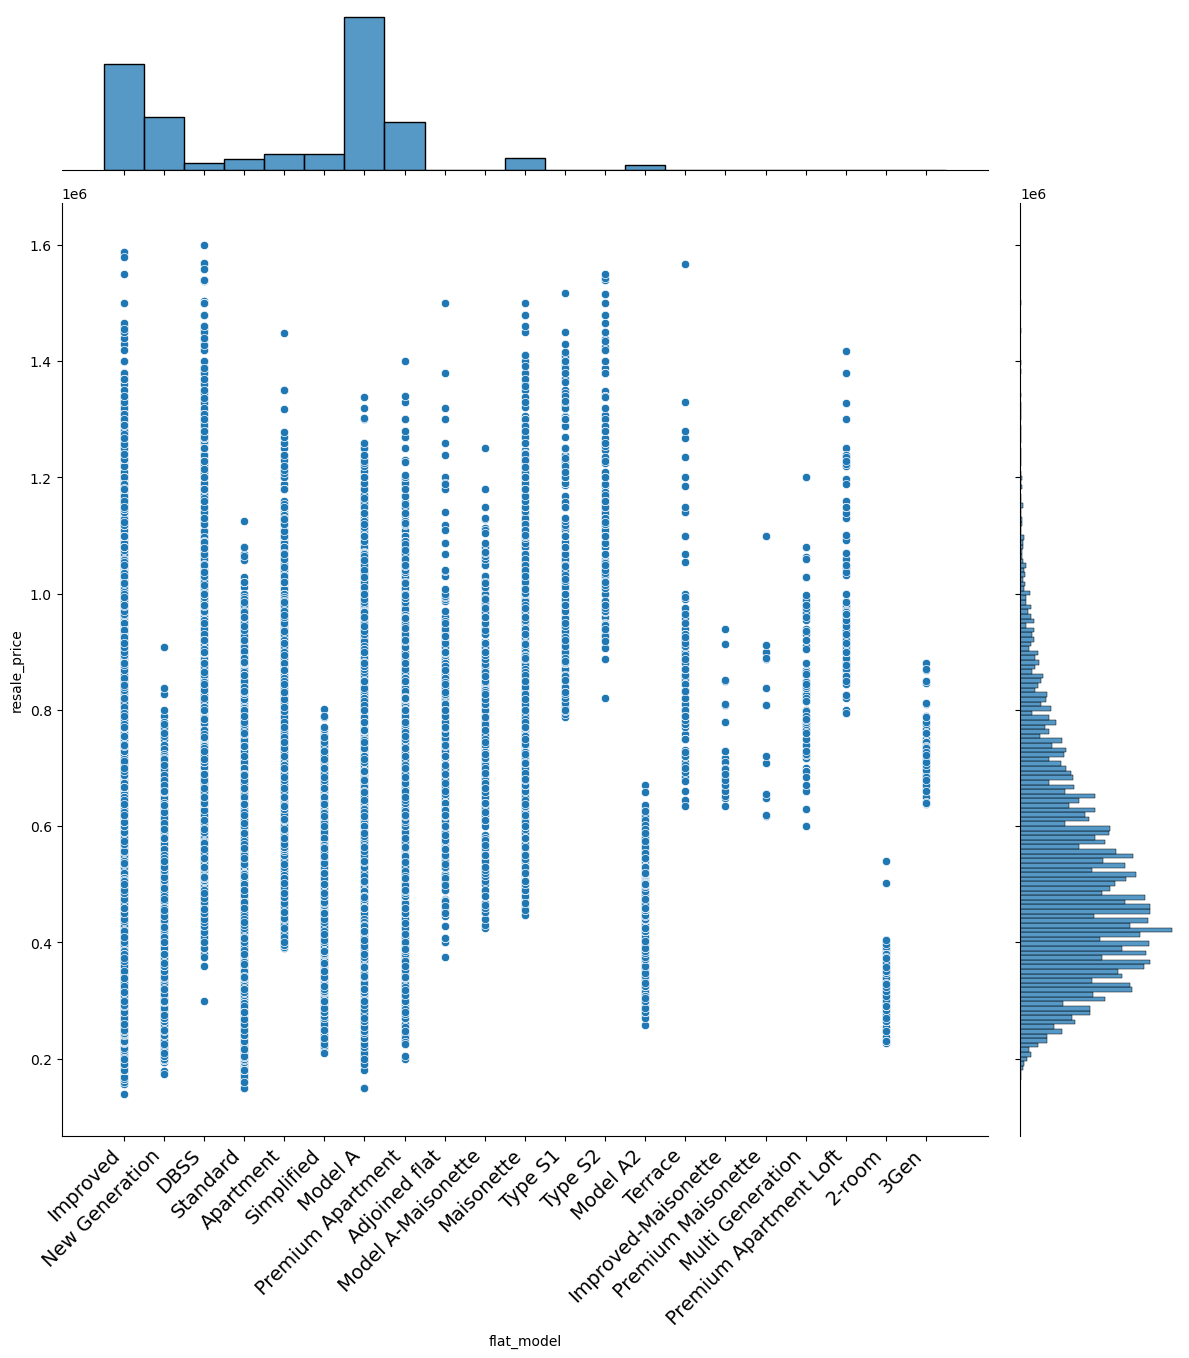

In [69]:
fm_plus_resaleprice = pd.concat([data["flat_model"], data["resale_price"]], axis = 1).reindex(data["flat_model"].index)
fm_plus_resaleprice
sb.jointplot(data = fm_plus_resaleprice, x = 'flat_model', y = 'resale_price', height = 12)
plt.xticks(rotation=45, ha="right", fontsize=14)

#### Scatter Plot of Resale Price by Flat Model

This scatter plot further illustrates resale price variation across different flat models:

- Models like **Maisonette**, **Type S1/S2**, and **Premium Apartment Loft** are among the **most expensive**, with resale prices reaching above $1.5 million.
- Models such as **Improved**, **New Generation**, and **Model A** form the bulk of transactions and occupy the mid-price tier.
- **2-room** and **3Gen** flats appear at the **lower end** of the resale price spectrum.

The distribution reflects the diversity in design and size across flat models, reinforcing their importance in price prediction modeling.


## 3.10 Resale Price by Remaining Years Left in Lease

In [73]:
# find the minimum value of remaining years left in lease
min_value = data['remaining_lease_years'].min()
print(min_value)

40.083333333333336


<Axes: xlabel='lease_groups', ylabel='resale_price'>

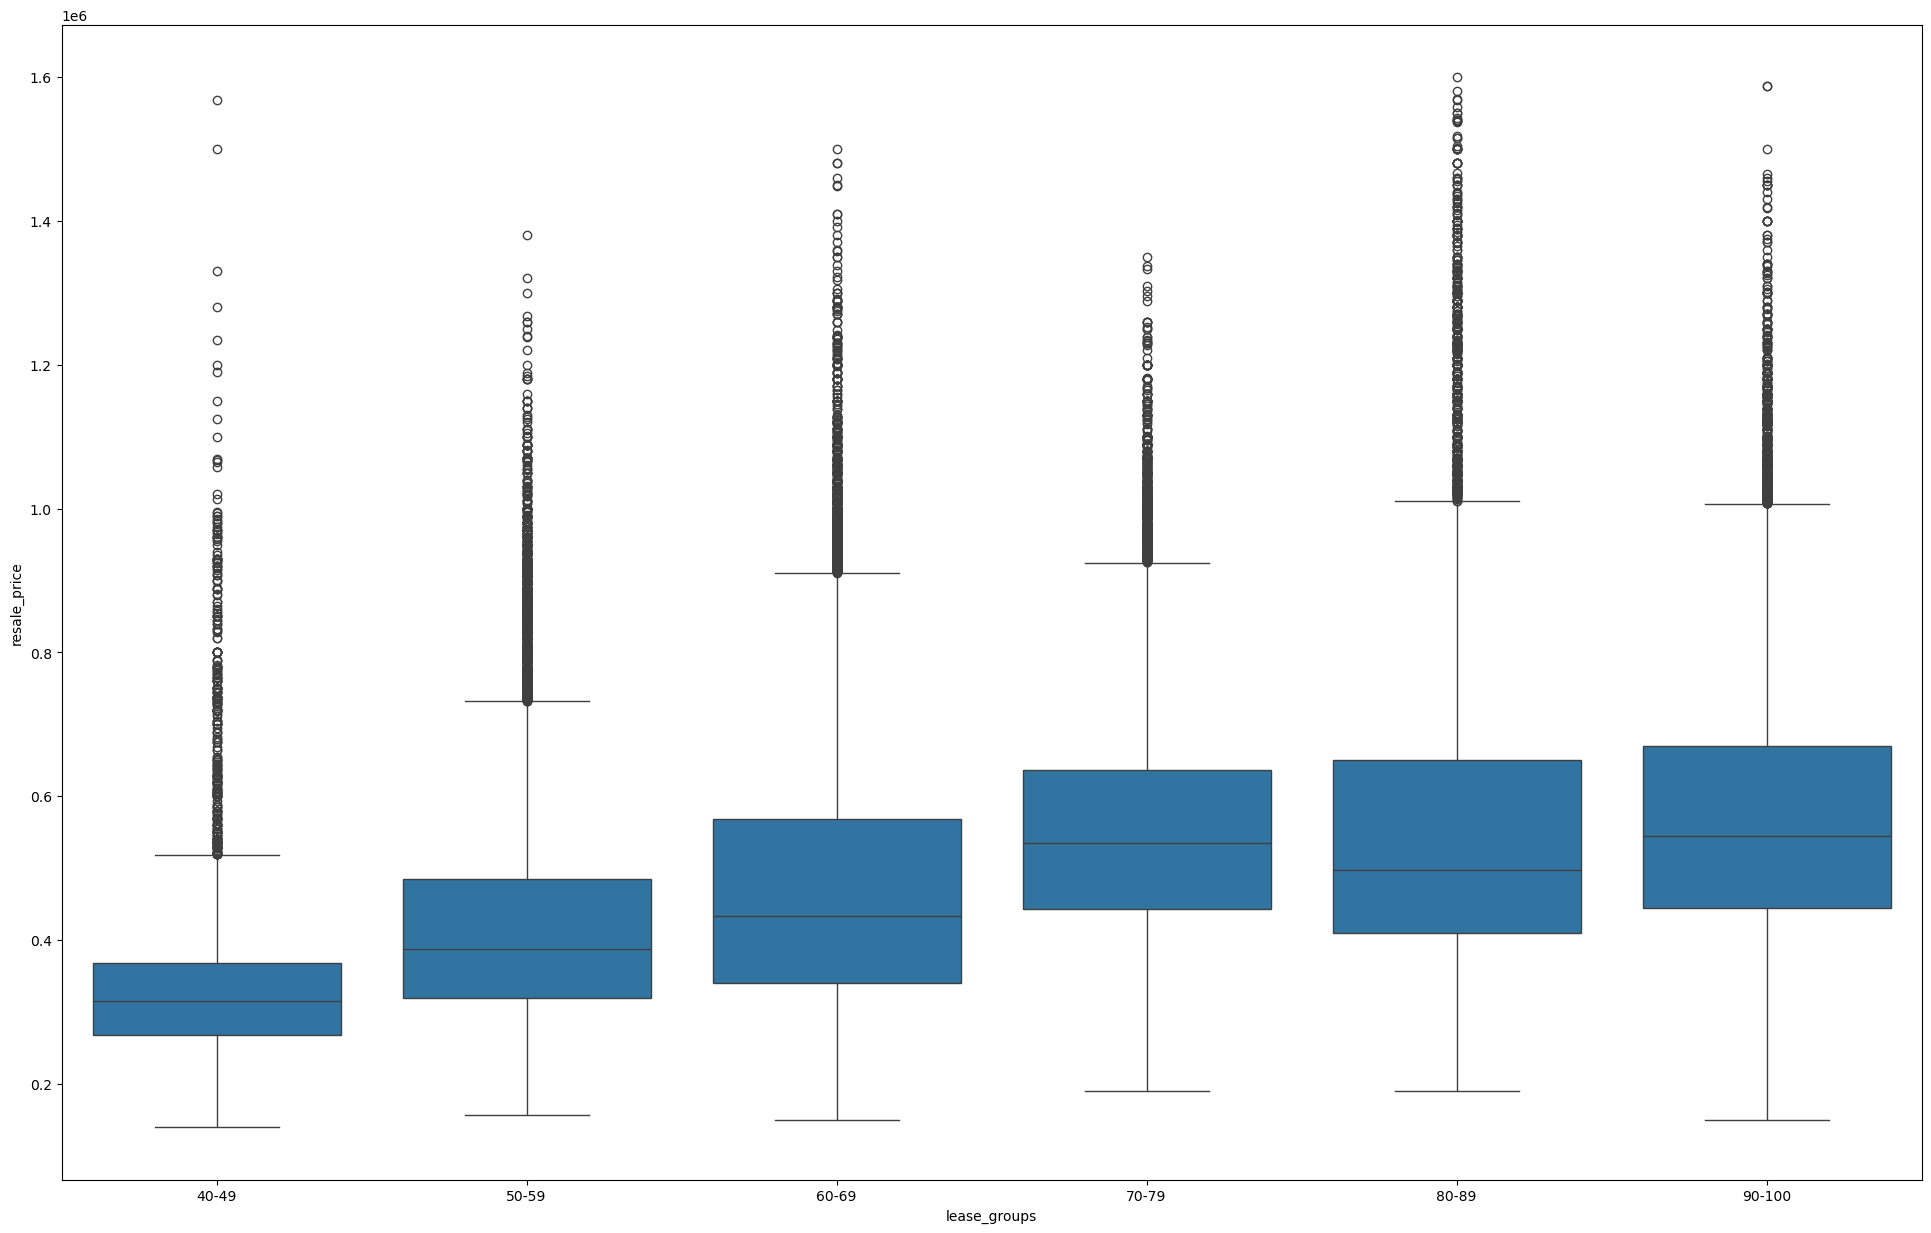

In [74]:
bins = [40,50,60,70,80,90,100]  # adjust bins as needed based on your data
labels = ['40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
data['lease_groups'] = pd.cut(data['remaining_lease_years'], bins=bins, labels=labels, right=False)

f = plt.figure(figsize = (24,15))
sb.boxplot(x = "lease_groups", y = "resale_price", data = data)

/var/folders/th/hhm7jwtd2t9g83v7l2pkm3f80000gp/T/ipykernel_2181/298284494.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = data.groupby("lease_groups")["resale_price"].median().reindex(labels)


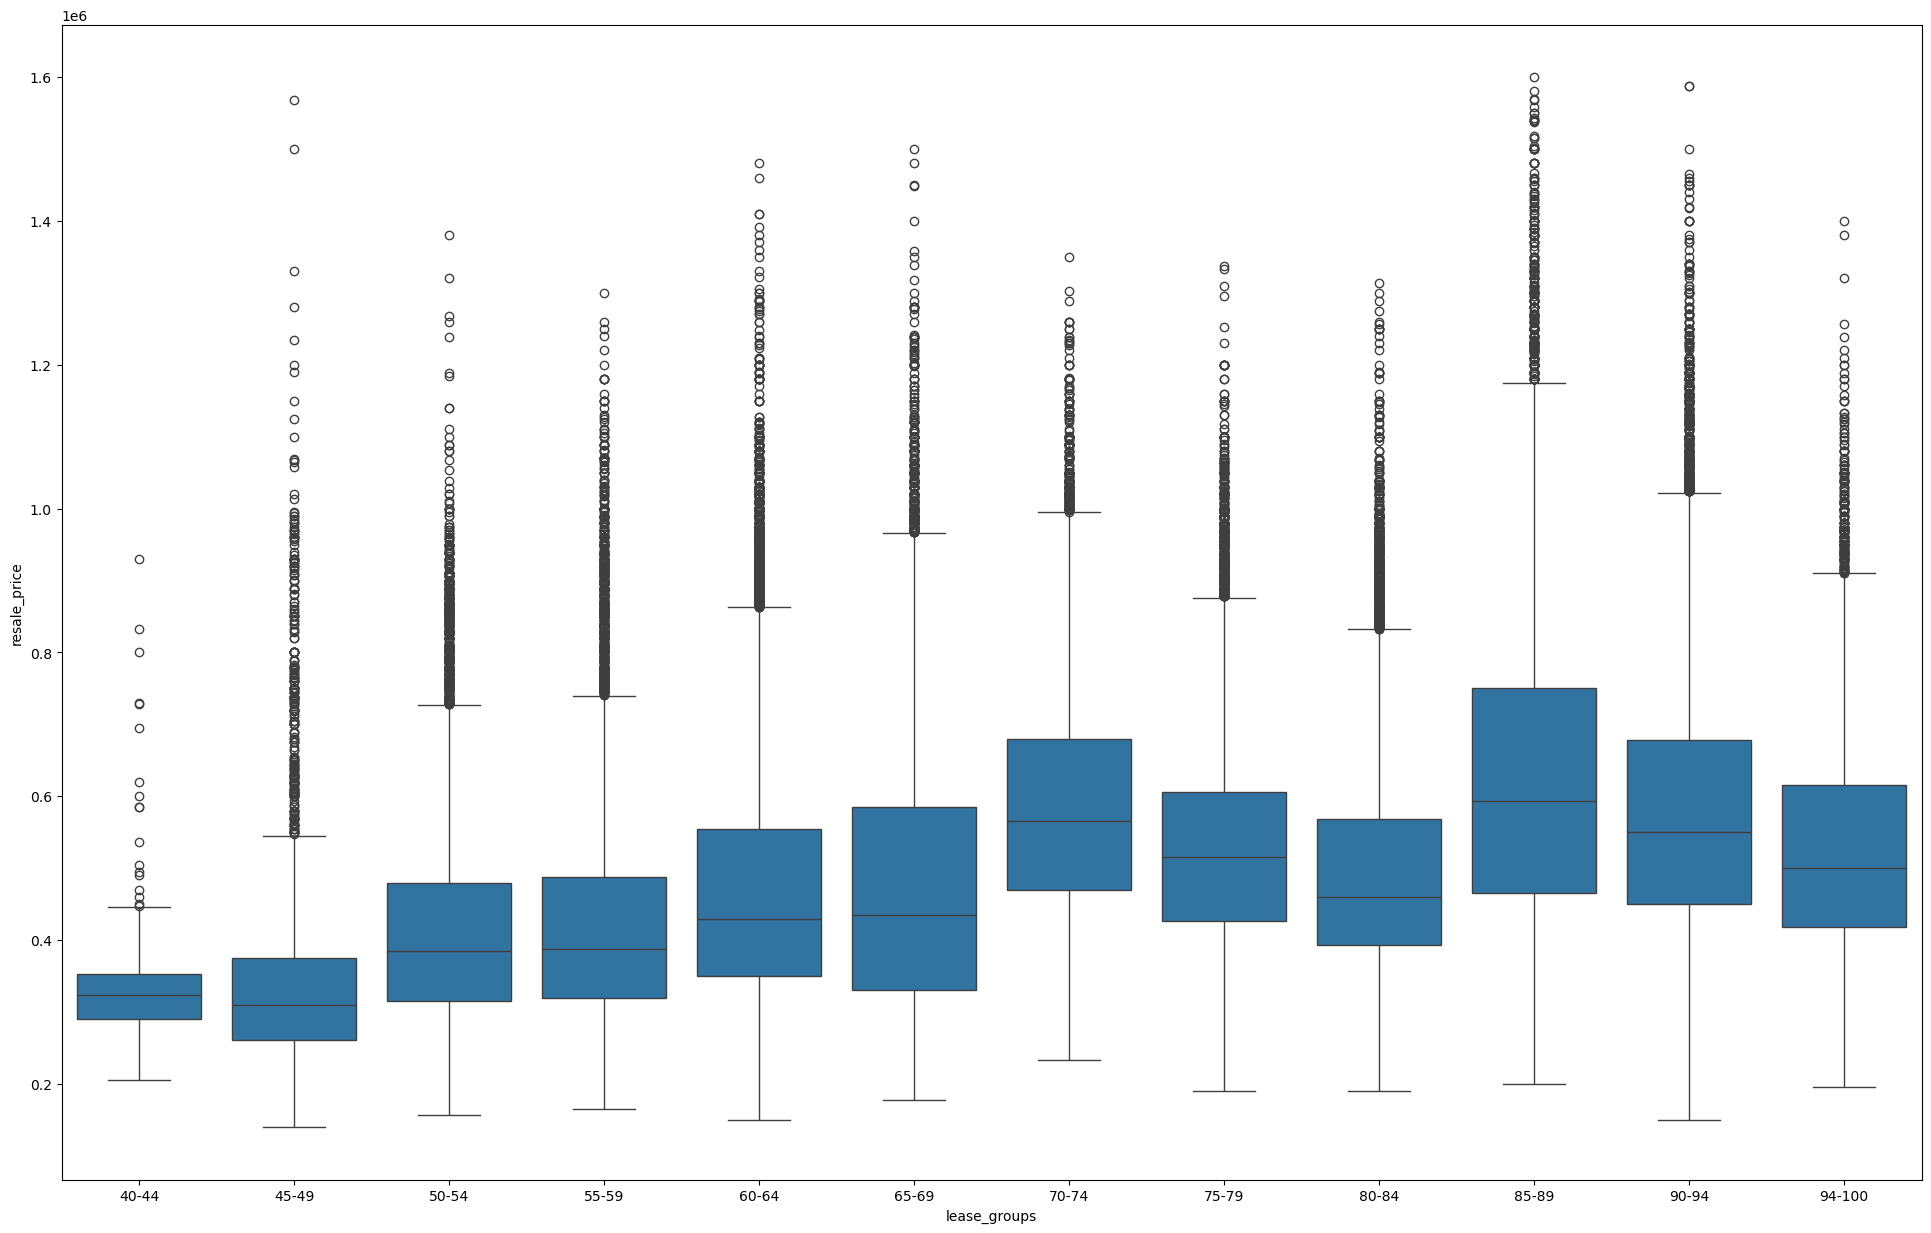

In [75]:
bins = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]  # adjust bins as needed based on your data
labels = ['40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '94-100']
data['lease_groups'] = pd.cut(data['remaining_lease_years'], bins=bins, labels=labels, right=False)

f = plt.figure(figsize = (24,15))
sb.boxplot(x = "lease_groups", y = "resale_price", data = data)

# Calculate the median resale price for each lease group
group_medians = data.groupby("lease_groups")["resale_price"].median().reindex(labels)

# Determine the x-axis positions for each lease group (they are plotted in order)
positions = np.arange(len(group_medians))

plt.show()


#### Resale Price by Remaining Lease Years

This boxplot illustrates the relationship between remaining lease and resale price:

- **Flats with more remaining lease (85–100 years)** generally have **higher resale prices**, showing strong demand for newer or recently renewed flats.
- Prices tend to **decrease as lease years drop**, with more pronounced decline below 70 years.
- The spread (variance) also increases for flats with very long leases, indicating the presence of larger or premium units.

This supports the common understanding that **remaining lease is a critical factor** influencing a buyer's willingness to pay, making it an essential feature in price prediction models.


(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 [Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90'),
  Text(100.0, 0, '100'),
  Text(110.0, 0, '110')])

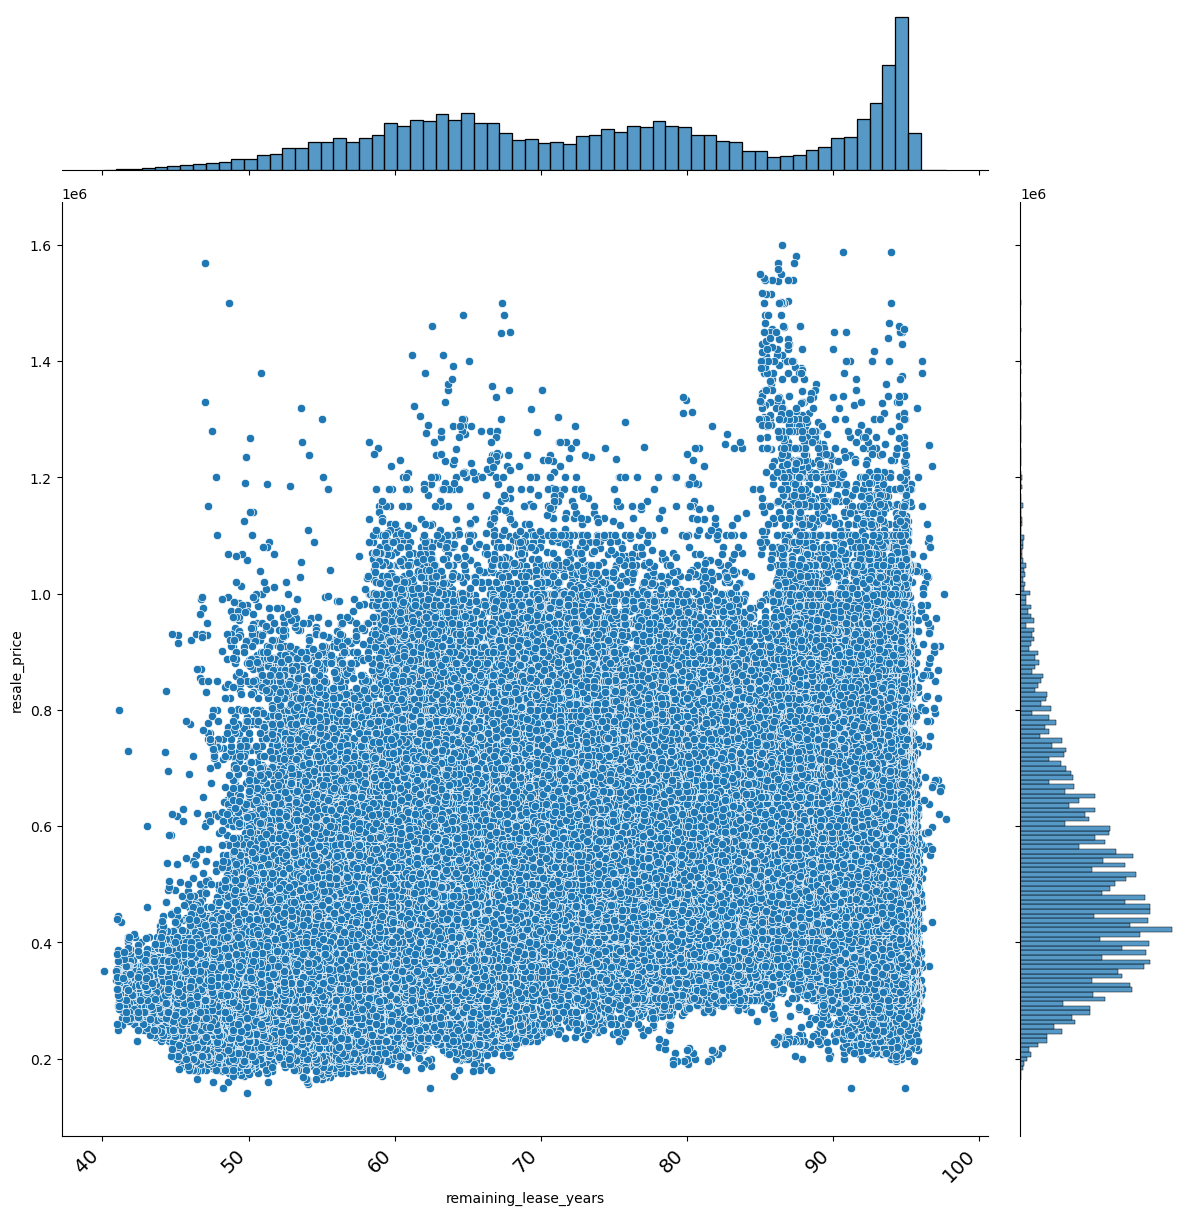

In [78]:
lease_plus_resaleprice = pd.concat([data["remaining_lease_years"], data["resale_price"]], axis = 1).reindex(data["remaining_lease_years"].index)
lease_plus_resaleprice
sb.jointplot(data = lease_plus_resaleprice, x = 'remaining_lease_years', y = 'resale_price', height = 12)
plt.xticks(rotation=45, ha="right", fontsize=14)

#### Scatter Plot: Resale Price vs Remaining Lease Years

This scatter plot further reinforces the relationship between remaining lease and resale price:

- **Positive Correlation**: Flats with more remaining lease generally command higher resale prices.
- **Dense Clusters**: Most transactions fall within the 60–99 years lease range, forming dense price bands between \$400k–\$700k.
- **High-Lease Outliers**: Some flats with long leases exceed \$1M, likely premium or large flats in prime areas.

This visualization supports using **remaining lease** as a strong predictor in regression models and provides insight into how lease decay affects HDB market value.


## 3.11 Finding Correlation

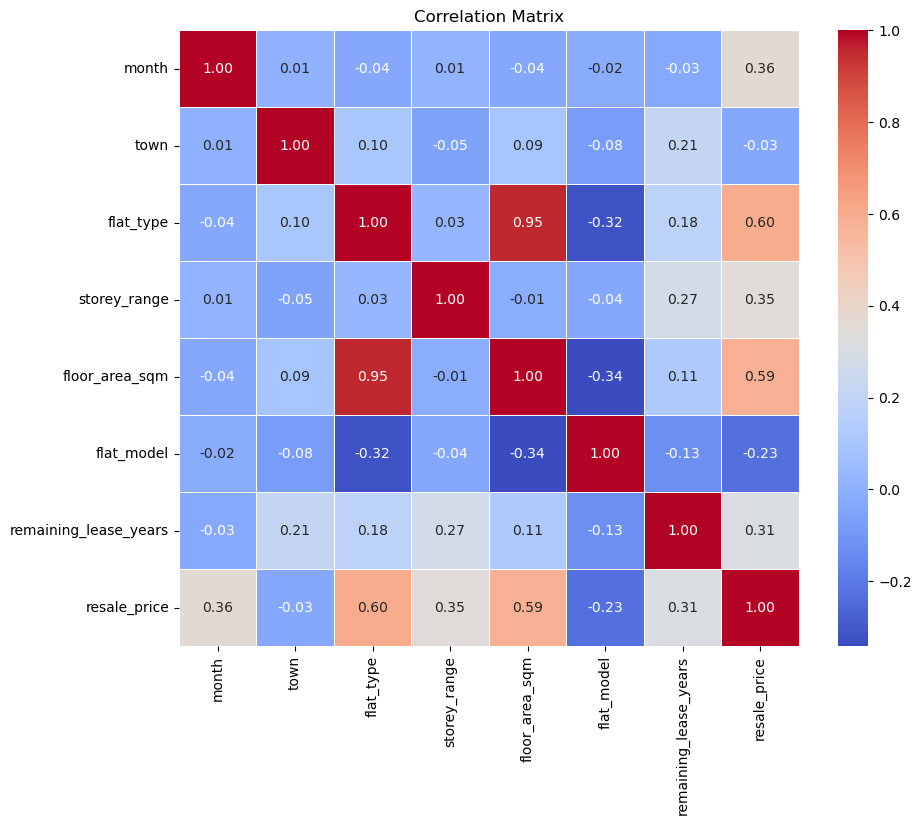

In [84]:


# List of columns of interest
cols = ["month", "town", "flat_type", "storey_range", "floor_area_sqm", "flat_model", "remaining_lease_years", "resale_price"]

# Create a copy of your data for correlation analysis
corr_data = data[cols].copy()

# Convert categorical columns to numeric codes (if they're not already numeric)
categorical_columns = ["month", "town", "flat_type", "storey_range", "flat_model"]
for col in categorical_columns:
    if corr_data[col].dtype == 'object' or corr_data[col].dtype.name == 'category':
        corr_data[col] = corr_data[col].astype('category').cat.codes

# Compute the correlation matrix
corr_matrix = corr_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



### Correlation Matrix Analysis

This correlation matrix helps identify relationships between features and their impact on resale price:

- **Strongest Positive Correlations with Resale Price**:
  - `flat_type` (**0.60**) and `floor_area_sqm` (**0.59**) are highly correlated with resale price, indicating that larger and more premium flat types command higher prices.
  - `storey_range` (**0.35**) and `remaining_lease_years` (**0.31**) also show moderate correlation, supporting earlier EDA findings.

- **Weak or Negligible Correlations**:
  - `month` shows a modest correlation (**0.36**), possibly due to overall rising price trends over time.
  - `town` and `flat_model` show very weak or even negative correlations, suggesting location and model alone may not strongly predict price.

**Insight**: These correlations guide feature selection for regression or tree-based models, highlighting the most influential variables affecting resale pricing.


# 4 Uni-variate Linear Regression

We utilise univariate linear regression to **examine the relationship** between the **variables** (predictor) and the **resale price** (response). It helps us identify which variables have the strongest linear relationships with resale price before moving to more complex models.

- Used a **75/25 train-test split**
- Categorical features (town, storey, flat type) were converted via **one‑hot encoding**.


### 4.1 Predictor Feature: remaining_lease_years


In [90]:
price = pd.DataFrame(data["resale_price"])
yrs = pd.DataFrame(data["remaining_lease_years"])


Intercept of Regression 	: b =  213735.1894158881
Coefficients of Regression 	: a =  [4001.62147308]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.09867421973560608
Root Mean Squared Error (MSE) 	: 170626.08049260982

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.09651990981648151
Root Mean Squared Error (RMSE) 	: 170217.31058027665



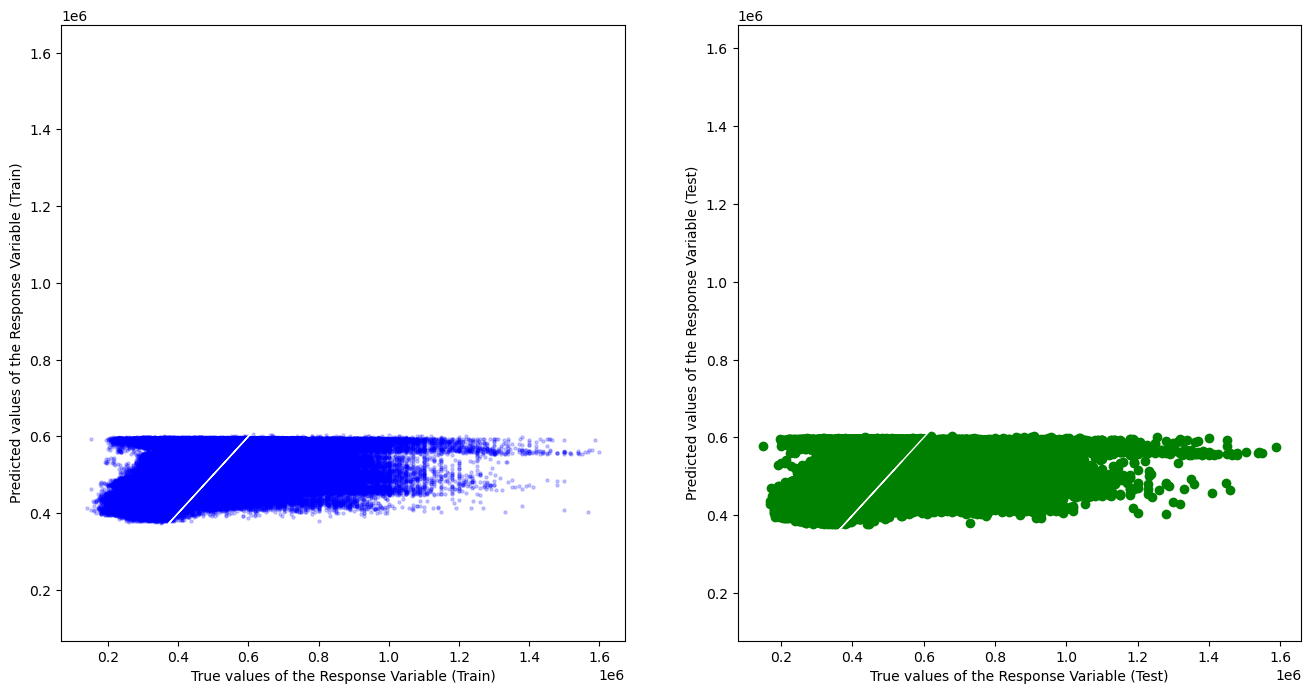

In [329]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train_years, X_test_years, Y_train_years, Y_test_years = train_test_split(yrs, price, test_size = 0.25, random_state = 42)

linreg = LinearRegression()
linreg.fit(X_train_years, Y_train_years)

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

Y_train_years_pred = linreg.predict(X_train_years)
Y_test_years_pred = linreg.predict(X_test_years)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train_years, Y_train_years))
print("Root Mean Squared Error (MSE) \t:", np.sqrt(mean_squared_error(Y_train_years, Y_train_years_pred)))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test_years, Y_test_years))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(Y_test_years, Y_test_years_pred)))
print()


f, axes = plt.subplots(1, 2, figsize=(16, 8))


axes[0].scatter(Y_train_years, Y_train_years_pred, alpha = 0.2, s = 5, color = "blue")
axes[0].plot(Y_train_years, Y_train_years, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(Y_test_years, Y_test_years_pred, color = "green")
axes[1].plot(Y_test_years, Y_test_years, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


### 4.2 Predictor Feature: floor_area_sqm

Intercept of Regression 	: b =  [88179.5949147]
Coefficients of Regression 	: a =  [[4368.60811938]]

Goodness of Fit of model 	Train Dataset
Explained Variance (R^2) 	: 0.3410137037289168
Root Mean Squared Error (RMSE) 	: 145895.7731101697

Goodness of Fit of model 	Test Dataset
Explained Variance (R^2) 	: 0.34616025904006287
Root Mean Squared Error (RMSE) 	: 144803.84305481025



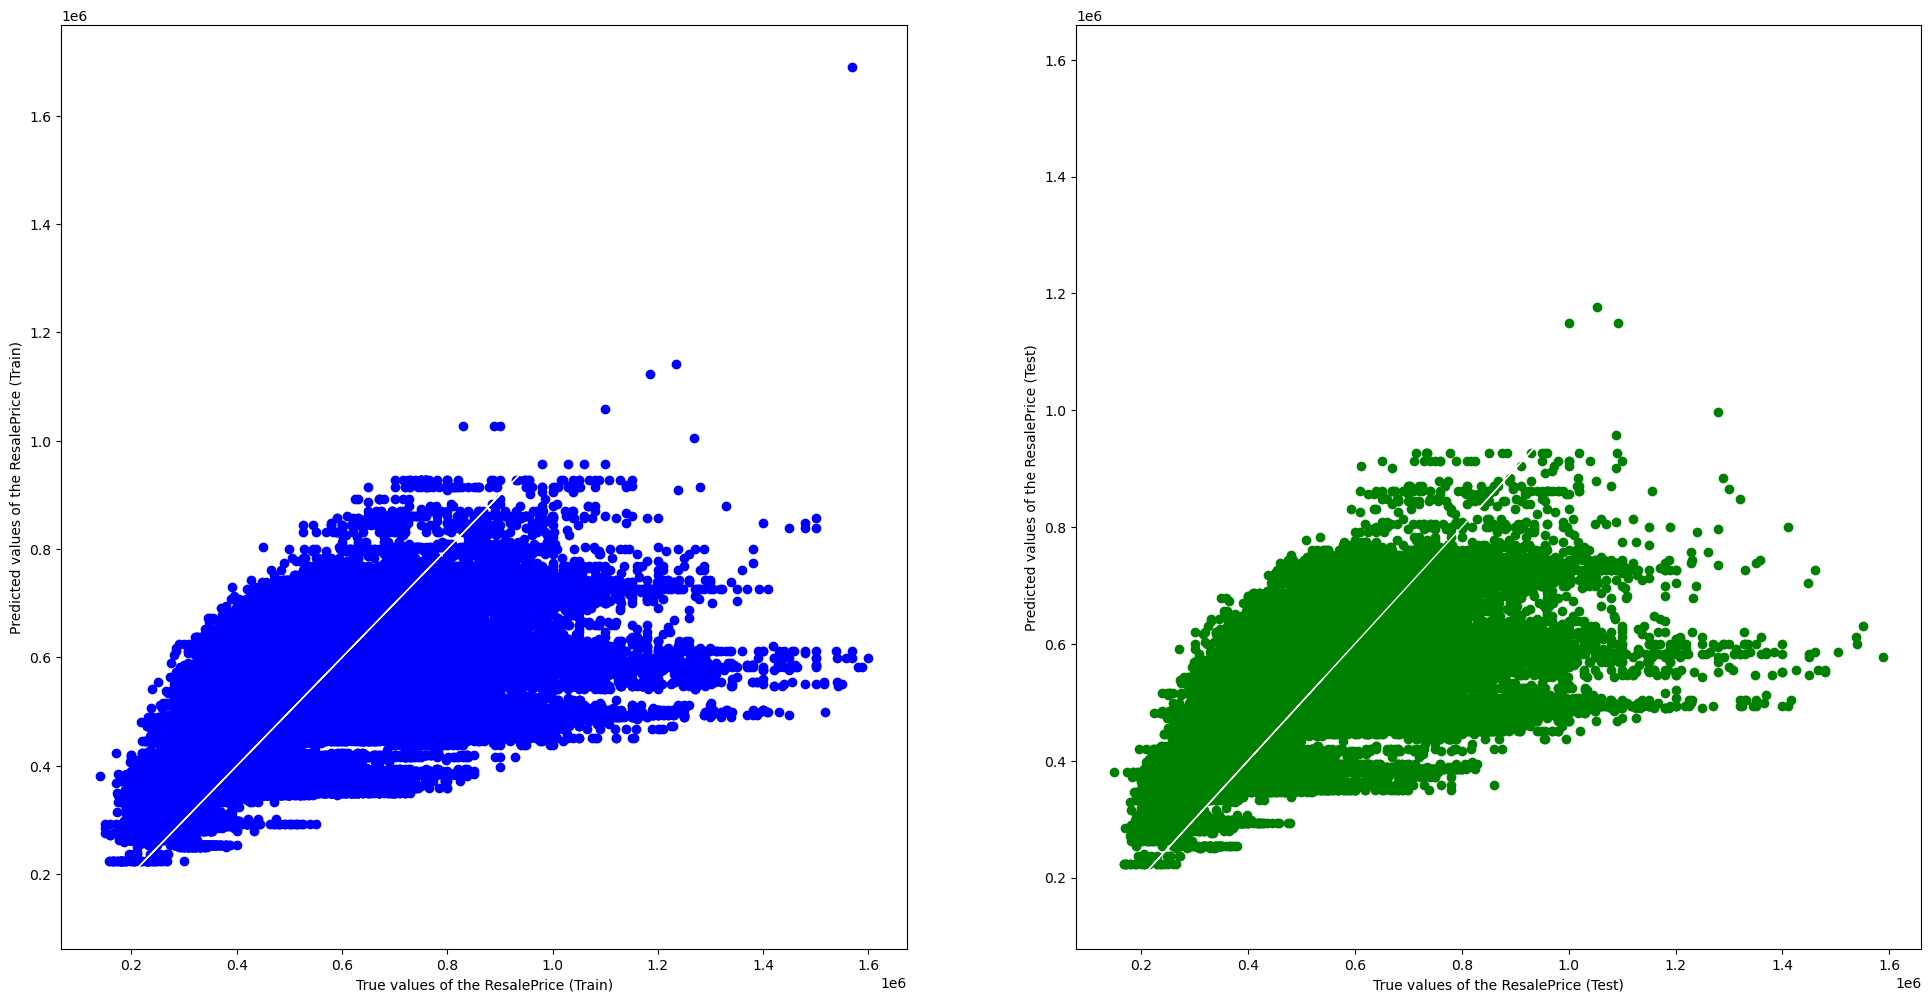

In [335]:
resaleprice = pd.DataFrame(data['resale_price'])   # Response
floorarea = pd.DataFrame(data['floor_area_sqm'])         # Predictor

# Split the Dataset into Train and Test
X_train_floor, X_test_floor, y_train_floor, y_test_floor = train_test_split(floorarea, resaleprice, test_size = 0.25, random_state =42)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train_floor, y_train_floor)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Total values corresponding to HP
y_train_floor_pred = linreg.predict(X_train_floor)
y_test_floor_pred = linreg.predict(X_test_floor)


print("Goodness of Fit of model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train_floor, y_train_floor))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train_floor, y_train_floor_pred)))
print()

print("Goodness of Fit of model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test_floor, y_test_floor))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test_floor, y_test_floor_pred)))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train_floor, y_train_floor_pred, color = "blue")
axes[0].plot(y_train_floor, y_train_floor, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the ResalePrice (Train)")
axes[0].set_ylabel("Predicted values of the ResalePrice (Train)")
axes[1].scatter(y_test_floor, y_test_floor_pred, color = "green")
axes[1].plot(y_test_floor, y_test_floor, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the ResalePrice (Test)")
axes[1].set_ylabel("Predicted values of the ResalePrice (Test)")
plt.show()


### 4.3 Predictor Feature: storey_range

Intercept of Regression 	: b =  186047341583084.22
Coefficients of Regression 	: a = 
 storey_range_01 TO 03   -1.860473e+14
storey_range_04 TO 06   -1.860473e+14
storey_range_07 TO 09   -1.860473e+14
storey_range_10 TO 12   -1.860473e+14
storey_range_13 TO 15   -1.860473e+14
storey_range_16 TO 18   -1.860473e+14
storey_range_19 TO 21   -1.860473e+14
storey_range_22 TO 24   -1.860473e+14
storey_range_25 TO 27   -1.860473e+14
storey_range_28 TO 30   -1.860473e+14
storey_range_31 TO 33   -1.860473e+14
storey_range_34 TO 36   -1.860473e+14
storey_range_37 TO 39   -1.860473e+14
storey_range_40 TO 42   -1.860473e+14
storey_range_43 TO 45   -1.860473e+14
storey_range_46 TO 48   -1.860473e+14
storey_range_49 TO 51   -1.860473e+14
dtype: float64

Goodness of Fit of model 	Train Dataset
Explained Variance (R²) 	: 0.13535325785691277
Root Mean Squared Error (RMSE) 	: 167118.24748966802

Goodness of Fit of model 	Test Dataset
Explained Variance (R²) 	: 0.1373880993740212
Root Mean Squared Error (

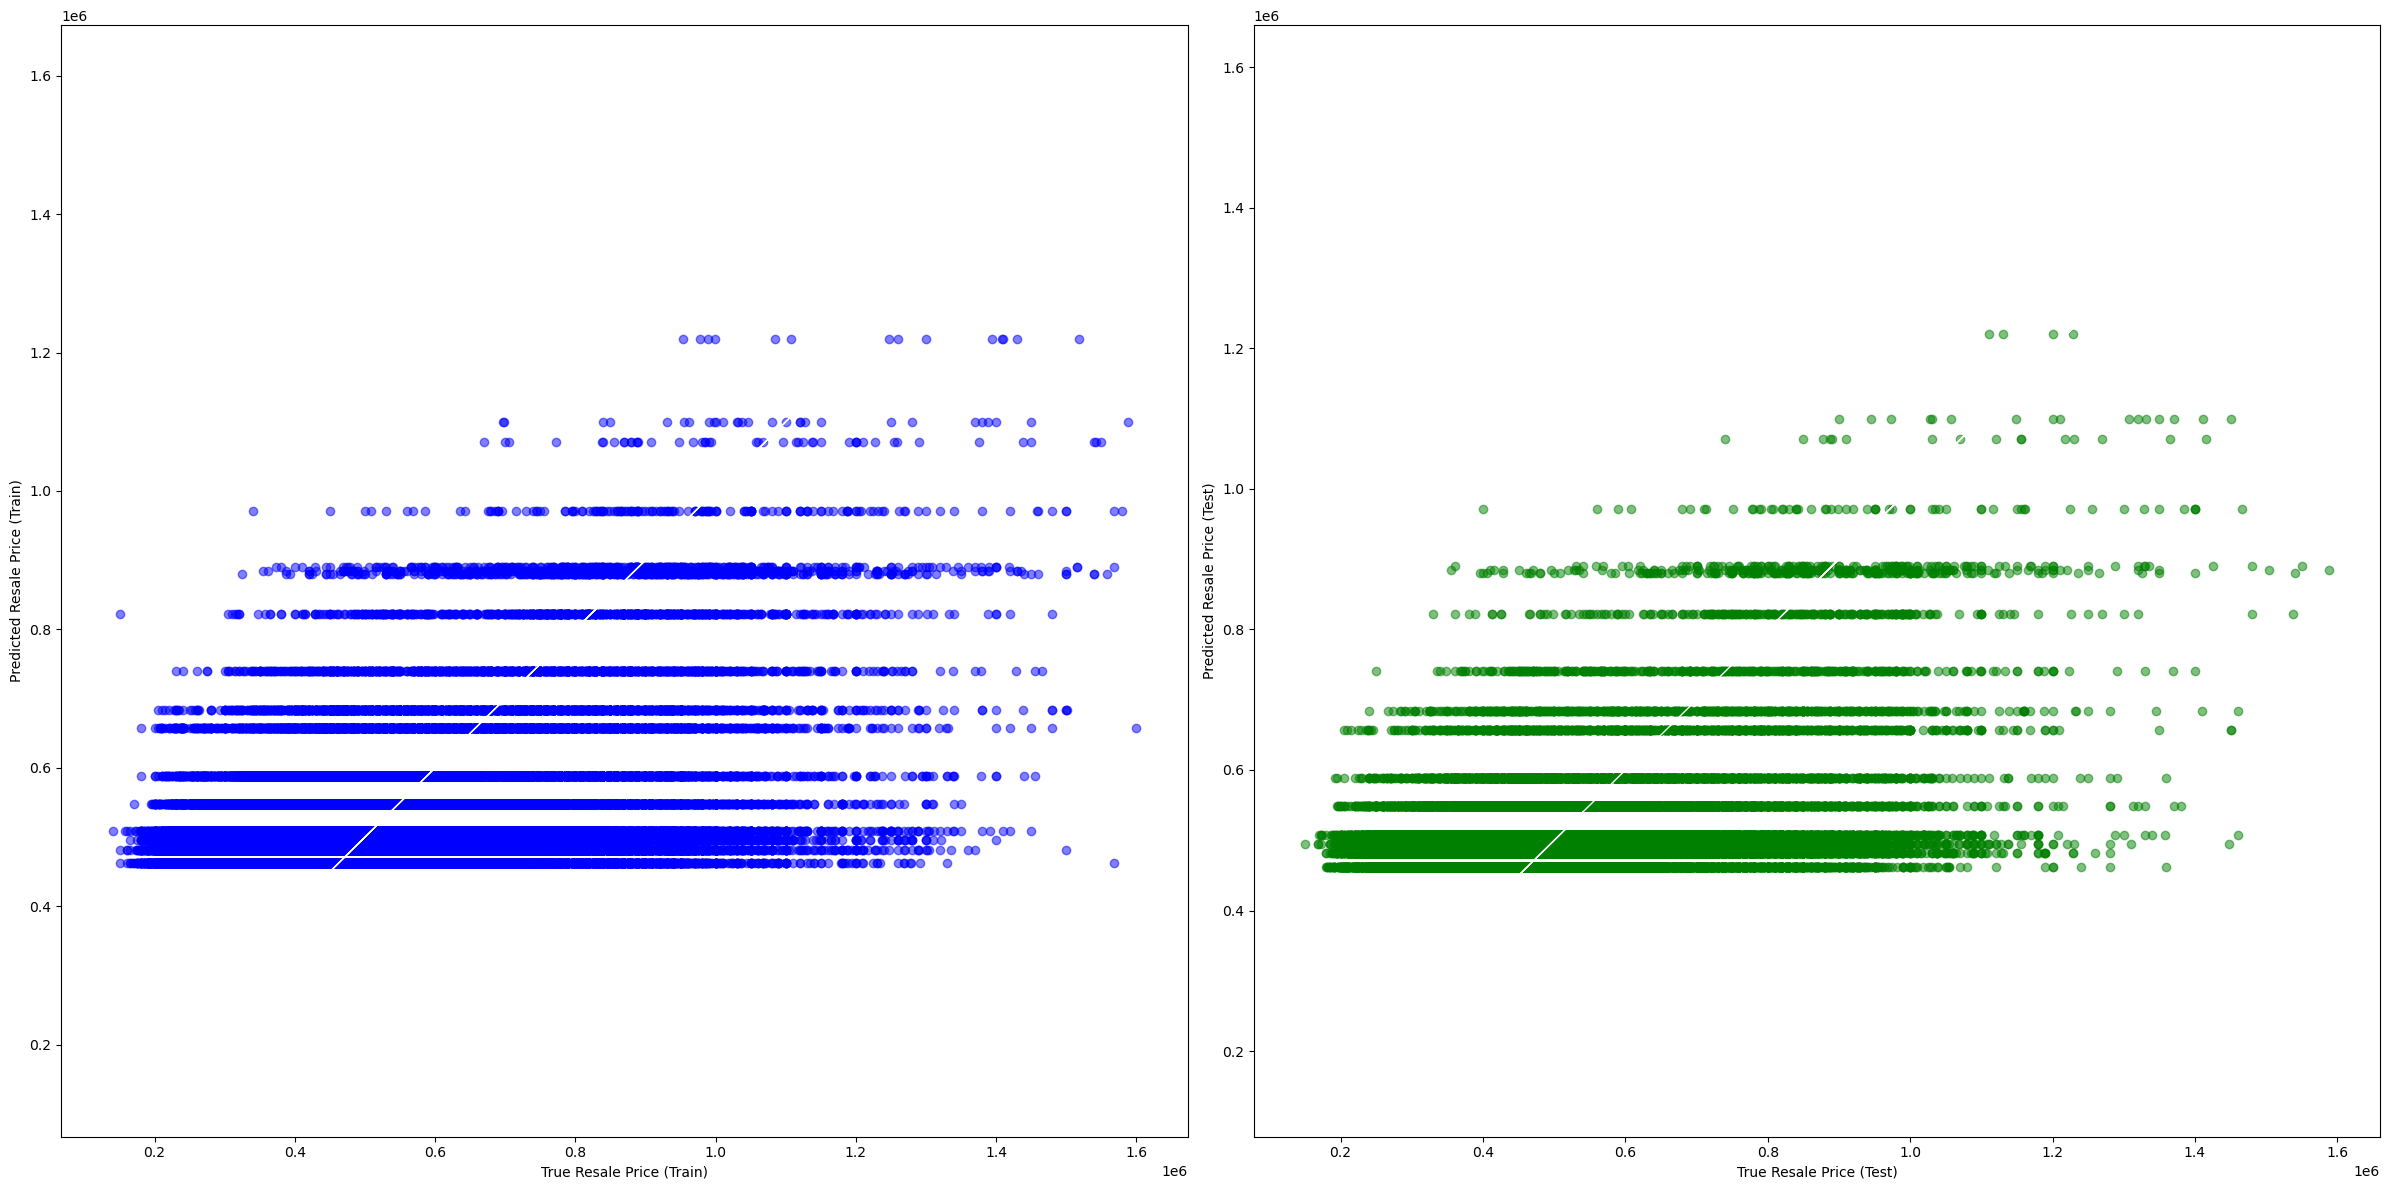

In [333]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# One-Hot encode storey_range
sr_cat = data[['storey_range']]
ohe.fit(sr_cat)
sr_cat_ohe = pd.DataFrame(ohe.transform(sr_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(sr_cat.columns))

X_train_storey, X_test_storey, y_train_storey, y_test_storey = train_test_split(sr_cat_ohe, price, test_size = 0.25, random_state=42)

# Linear Regression model
storey_model = LinearRegression()
storey_model.fit(X_train_storey, y_train_storey)

# Coefficients
print("Intercept of Regression \t: b = ", storey_model.intercept_)
print("Coefficients of Regression \t: a = \n", pd.Series(storey_model.coef_[0], index=X_train_storey.columns))
print()

# Predictions
y_train_storey_pred = storey_model.predict(X_train_storey)
y_test_storey_pred = storey_model.predict(X_test_storey)

print("Goodness of Fit of model \tTrain Dataset")
print("Explained Variance (R²) \t:", storey_model.score(X_train_storey, y_train_storey))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train_storey, y_train_storey_pred)))
print()

print("Goodness of Fit of model \tTest Dataset")
print("Explained Variance (R²) \t:", storey_model.score(X_test_storey, y_test_storey))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test_storey, y_test_storey_pred)))
print()

# Plot Predictions vs True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].scatter(y_train_storey, y_train_storey_pred, color="blue", alpha=0.5)
axes[0].plot(y_train_storey, y_train_storey, 'w-', linewidth=1)
axes[0].set_xlabel("True Resale Price (Train)")
axes[0].set_ylabel("Predicted Resale Price (Train)")

axes[1].scatter(y_test_storey, y_test_storey_pred, color="green", alpha=0.5)
axes[1].plot(y_test_storey, y_test_storey, 'w-', linewidth=1)
axes[1].set_xlabel("True Resale Price (Test)")
axes[1].set_ylabel("Predicted Resale Price (Test)")

plt.tight_layout()
plt.show()


### 4.4 Predictor Feature: flat_type

Intercept of Regression 	: b =  260514827122005.34
Coefficients of Regression 	: a =  [-2.60514827e+14 -2.60514827e+14 -2.60514827e+14 -2.60514827e+14
 -2.60514827e+14 -2.60514826e+14 -2.60514826e+14]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.36184510469252396
Root Mean Squared Error (RMSE) 	: 143571.27940032273

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3686097554285708
Root Mean Squared Error (RMSE) 	: 142296.2204470233



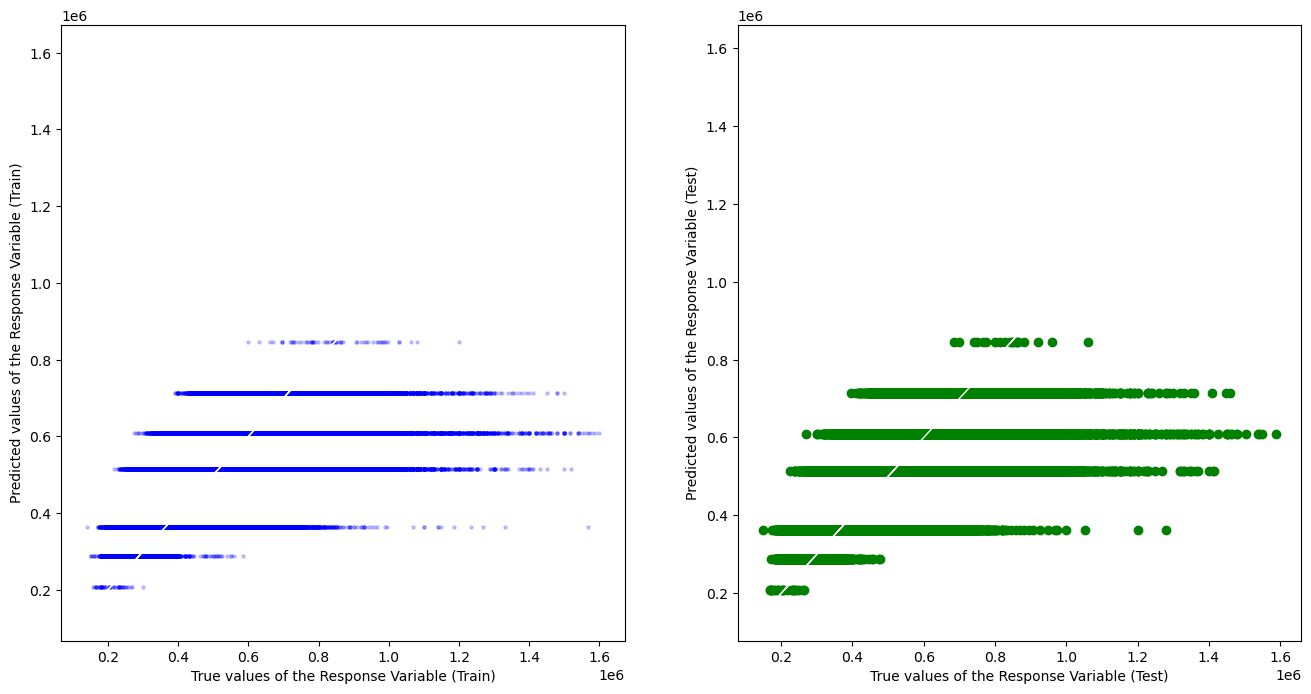

In [321]:
#One-Hot Encode flat type

flat_type_cat = data[['flat_type']]
ohe.fit(flat_type_cat)
flat_type_cat_ohe = pd.DataFrame(ohe.transform(flat_type_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(flat_type_cat.columns))

X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(flat_type_cat_ohe, price, test_size = 0.25, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train_ft, y_train_ft)

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

y_train_ft_pred = linreg.predict(X_train_ft)
y_test_ft_pred = linreg.predict(X_test_ft)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train_ft, y_train_ft))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train_ft, y_train_ft_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test_ft, y_test_ft))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test_ft, y_test_ft_pred)))
print()


f, axes = plt.subplots(1, 2, figsize=(16, 8))


axes[0].scatter(y_train_ft, y_train_ft_pred, alpha = 0.2, s = 5, color = "blue")
axes[0].plot(y_train_ft, y_train_ft, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test_ft, y_test_ft_pred, color = "green")
axes[1].plot(y_test_ft, y_test_ft, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


### 4.5 Predictor Feature: Town

Intercept of Regression 	: b =  -318128937125997.5
Coefficients of Regression 	: a =  [3.18128938e+14 3.18128938e+14 3.18128938e+14 3.18128938e+14
 3.18128938e+14 3.18128938e+14 3.18128938e+14 3.18128938e+14
 3.18128938e+14 3.18128938e+14 3.18128938e+14 3.18128938e+14
 3.18128938e+14 3.18128938e+14 3.18128938e+14 3.18128938e+14
 3.18128938e+14 3.18128938e+14 3.18128938e+14 3.18128938e+14
 3.18128938e+14 3.18128938e+14 3.18128938e+14 3.18128938e+14
 3.18128938e+14 3.18128938e+14]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.10230689153276218
Root Mean Squared Error (RMSE) 	: 170281.89065604398

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.1031450431965385
Root Mean Squared Error (RMSE) 	: 169592.0686047823



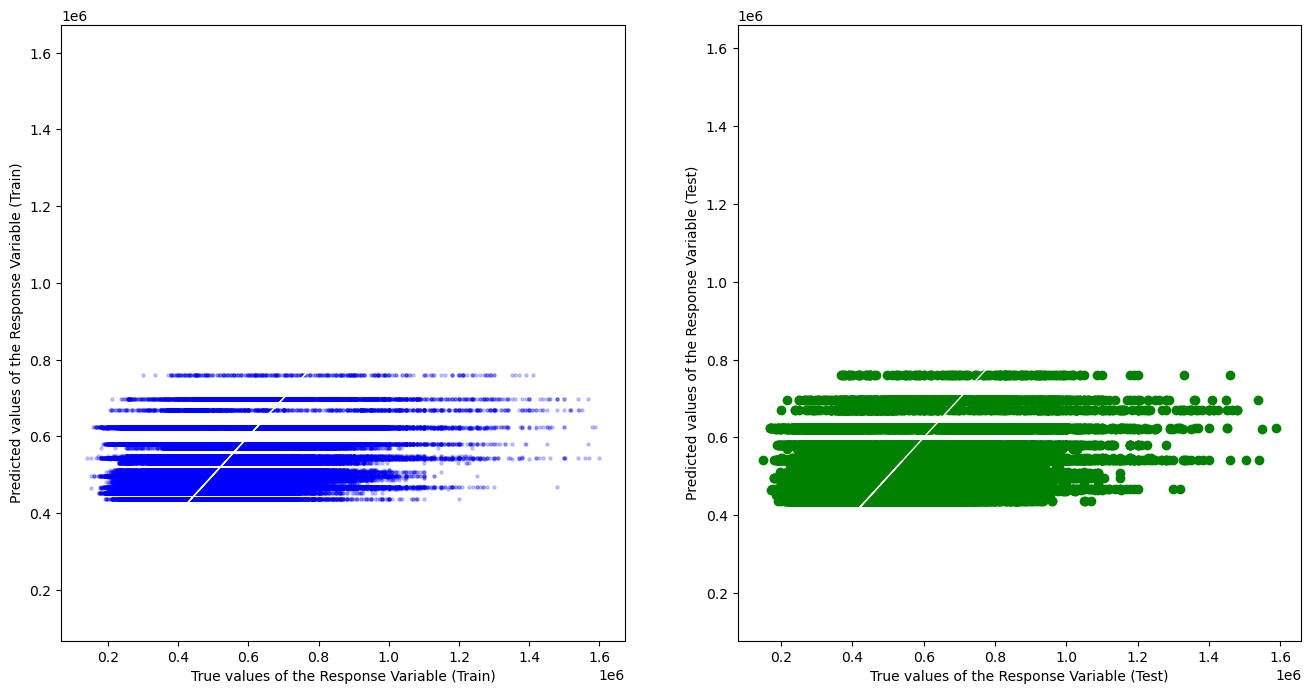

In [315]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: One-hot encode the 'town' column
town_cat = data[['town']]
ohe.fit(town_cat)
town_cat_ohe = pd.DataFrame(ohe.transform(town_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(town_cat.columns))

# Step 2: Define the target variable (resale price)
price = data['resale_price']

# Step 3: Train-test split
X_train_town, X_test_town, y_train_town, y_test_town = train_test_split(town_cat_ohe, price, test_size=0.25, random_state=42)

# Step 4: Fit Linear Regression
linreg_town = LinearRegression()
linreg_town.fit(X_train_town, y_train_town)

# Step 5: Print intercept and coefficients
print('Intercept of Regression \t: b = ', linreg_town.intercept_)
print('Coefficients of Regression \t: a = ', linreg_town.coef_)
print()

# Step 6: Predict resale price
y_train_pred = linreg_town.predict(X_train_town)
y_test_pred = linreg_town.predict(X_test_town)

# Step 7: Evaluate model performance
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg_town.score(X_train_town, y_train_town))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train_town, y_train_pred)))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg_town.score(X_test_town, y_test_town))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test_town, y_test_pred)))
print()

# Step 8: Plot predicted vs true resale prices
f, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(y_train_town, y_train_pred, alpha=0.2, s=5, color="blue")
axes[0].plot(y_train_town, y_train_town, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].scatter(y_test_town, y_test_pred, color="green")
axes[1].plot(y_test_town, y_test_town, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

plt.show()

# 4.6 Multi-variate linear regression

After examining each feature individually, we combined all five predictors into a **Multivariate Linear Regression** model to capture their joint effect on HDB resale price.

### Predictors: floor_area_sqm, remaining_lease_years, storey_range, flat_type, town

### Response Variable: resale_price

Intercept of Regression 	: b =  [2.51656472e+15]
Coefficients of Regression 	: a =  [[ 3.87265842e+03  4.72764661e+03 -4.69549846e+13 -4.69549846e+13
  -4.69549846e+13 -4.69549846e+13 -4.69549845e+13 -4.69549845e+13
  -4.69549845e+13 -4.69549845e+13 -4.69549844e+13 -4.69549844e+13
  -4.69549844e+13 -4.69549844e+13 -4.69549844e+13 -4.69549843e+13
  -4.69549842e+13 -4.69549842e+13 -4.69549841e+13 -2.51109740e+15
  -2.51109740e+15 -2.51109740e+15 -2.51109740e+15 -2.51109740e+15
  -2.51109740e+15 -2.51109740e+15  4.14876677e+13  4.14876677e+13
   4.14876678e+13  4.14876676e+13  4.14876678e+13  4.14876675e+13
   4.14876679e+13  4.14876678e+13  4.14876675e+13  4.14876677e+13
   4.14876677e+13  4.14876676e+13  4.14876676e+13  4.14876675e+13
   4.14876678e+13  4.14876678e+13  4.14876676e+13  4.14876676e+13
   4.14876678e+13  4.14876675e+13  4.14876675e+13  4.14876677e+13
   4.14876676e+13  4.14876677e+13  4.14876675e+13  4.14876676e+13]]

                    Predictors  Coefficients
0         

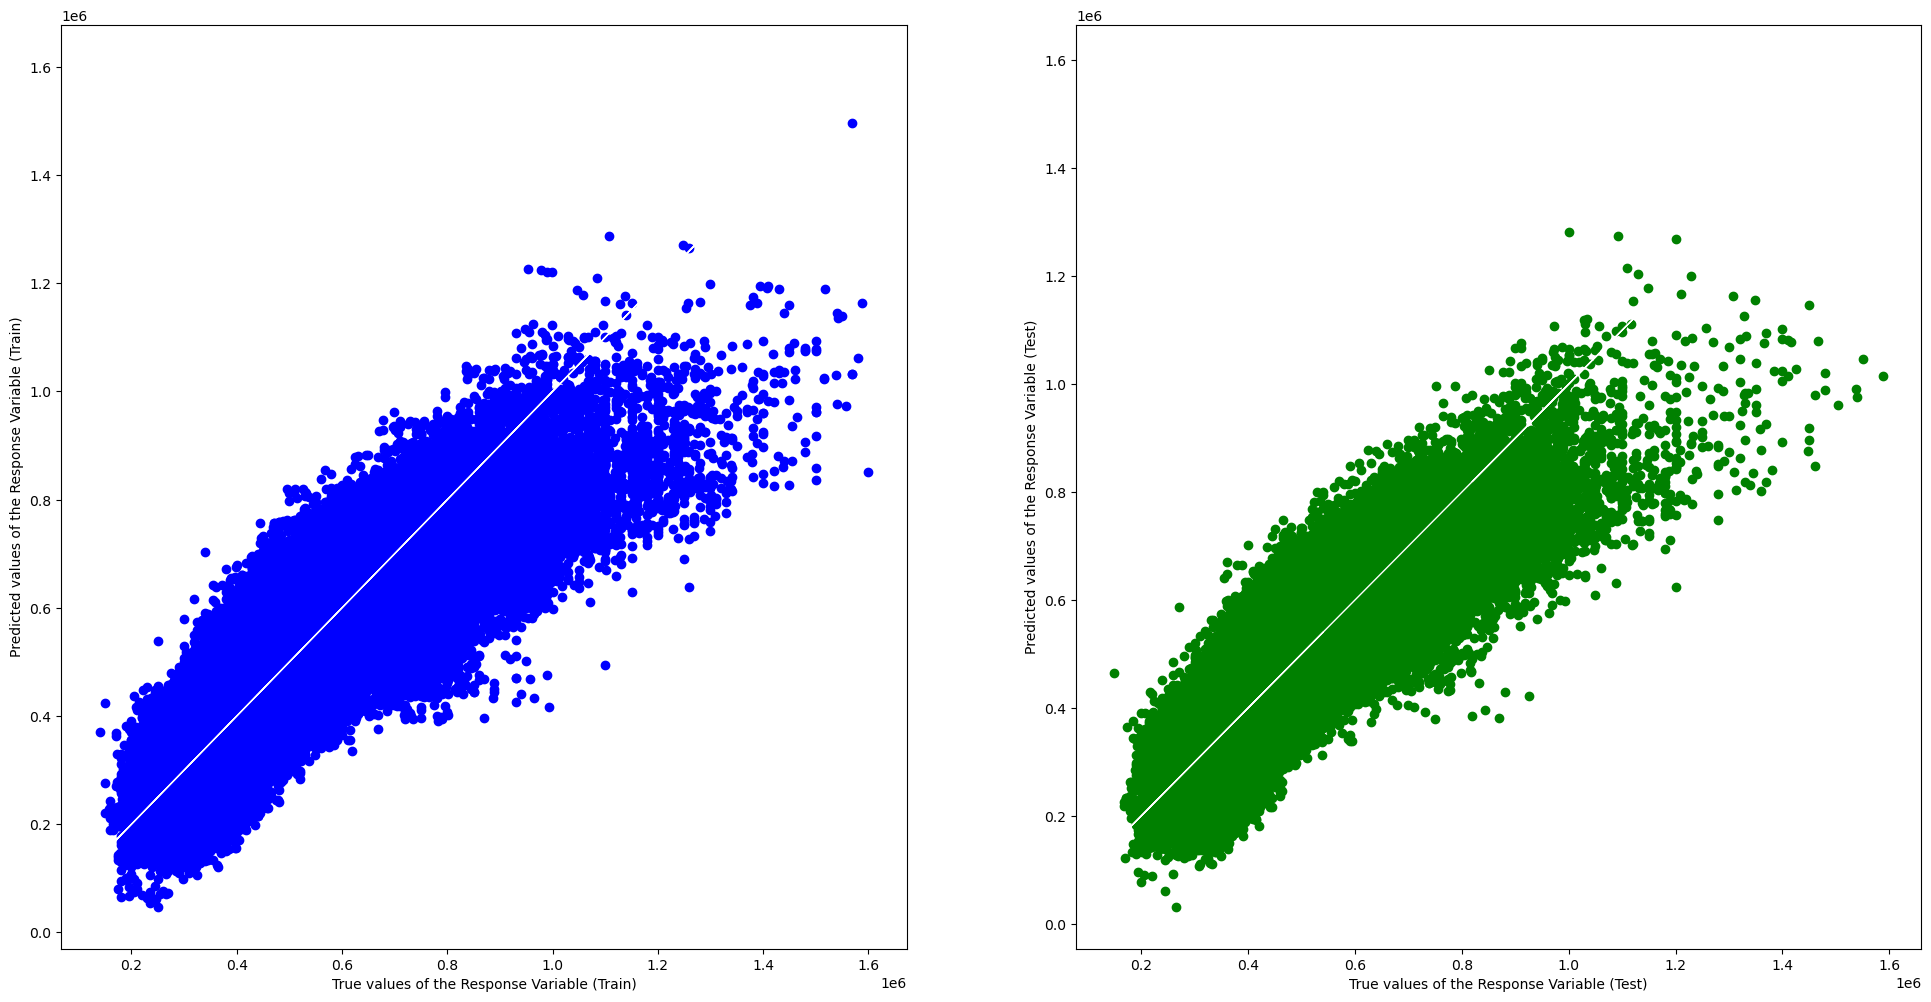

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6819661339147194
Root Mean Squared Error (RMSE) 	: 101354.07216340605

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6842400008377726
Root Mean Squared Error (RMSE) 	: 100628.96069128852



In [325]:
predictors = data[["floor_area_sqm", "remaining_lease_years"]]


y = pd.DataFrame(data["resale_price"])
X = pd.concat([predictors, sr_cat_ohe, flat_type_cat_ohe, town_cat_ohe], axis=1)

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

# 4.7 Random Forest Regressor
### Overview

The Random Forest Regressor is a supervised machine learning algorithm that utilizes multiple decision trees to make predictions. It works by constructing multiple decision trees during training and outputting the average of their predictions for regression problems. Each decision tree in the forest is built using a random subset of the data and features, making the model more robust and less prone to overfitting compared to a single decision tree.

### How Random Forest Works

1. Multiple Decision Trees: Random Forest builds several decision trees. Each tree is trained using a random subset of the data (bootstrap sampling) and random features.
   
2. Training Process:
   - Random Forest uses bagging (Bootstrap Aggregating) to train multiple decision trees on different subsets of the data.
   - Each decision tree in the forest is trained independently.
   - After training, the model averages the value from all the individual trees to make the final prediction.
     

3. Out-of-Bag (OOB) Error: Random Forest also provides an out-of-bag error estimate. This is a built-in validation mechanism that helps to estimate the generalization error of the model without needing a separate validation set.

### Why We Used Random Forest Regressor

1. Handling Complex Relationships: The relationship between the features (such as floor area, remaining lease years, flat type, and town) and the target (resale price) is likely non-linear and complex. Random Forest is ideal for handling such complex relationships as it can learn non-linear patterns.

2. Robustness: By combining multiple trees, random Forest is less prone to overfitting compared to individual decision trees, making it robust to noise in the data.

3. Feature Importance: Random Forest provides the ability to evaluate feature importance, which allows us to identify which features (e.g., floor_area_sqm, storey_range, flat_type, etc.) are most influential in predicting the resale price. This is helpful in understanding the factors that affect HDB resale prices and for improving model performance by focusing on important features.

4. Handling Mixed Data Types: The dataset includes both numerical data (such as floor area and lease years) and categorical data (such as flat_type, storey_range and town). Random Forest can handle both types of data without requiring complex preprocessing like scaling or encoding for numerical features, and it can handle categorical variables by using decision tree splits.

5. Built-in Cross-Validation: Random Forest has built-in mechanisms for cross-validation (via Out-Of-Bag estimates), reducing the need for additional validation steps and improving efficiency.

Random Forest Performance Metrics
TRAIN:
Explained Variance (R²): 0.9674
Root Mean Square Error (RMSE) : 32446.77075873653
TEST:
Explained Variance (R²): 0.8807
Root Mean Square Error (RMSE): 61864.11633055143


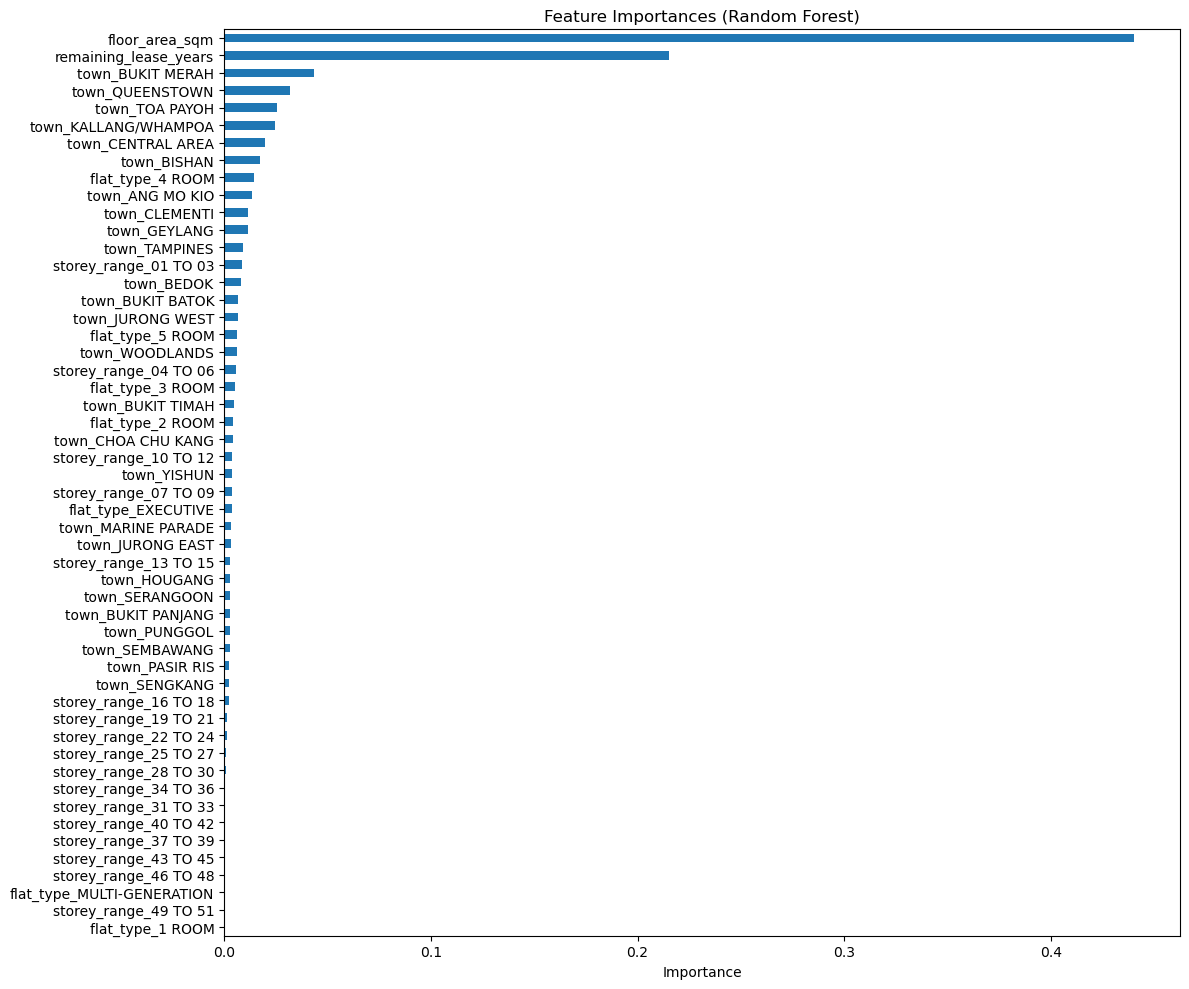

['storey_encoder.pkl']

In [307]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import joblib


# Numerical data
X_num = data[['floor_area_sqm', 'remaining_lease_years']]

# One-hot encode categorical data ('storey_range', 'flat_type' and 'town')
storey_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
flat_type_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
town_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


storey_encoded = storey_encoder.fit_transform(data[['storey_range']])
storey_columns = storey_encoder.get_feature_names_out(['storey_range'])
X_storey = pd.DataFrame(storey_encoded, columns=storey_columns, index=data.index)


flat_type_encoded = flat_type_encoder.fit_transform(data[['flat_type']])
flat_type_columns = flat_type_encoder.get_feature_names_out(['flat_type'])
X_flat_type = pd.DataFrame(flat_type_encoded, columns=flat_type_columns, index=data.index)


town_encoded = town_encoder.fit_transform(data[['town']])
town_columns = town_encoder.get_feature_names_out(['town'])
X_town = pd.DataFrame(town_encoded, columns=town_columns, index=data.index)

# Combine numerical and categorical data
X_all = pd.concat([X_num, X_storey, X_flat_type, X_town], axis=1)

# Target variable (resale_price)
y = data["resale_price"]

# Step 2: 75/25 Training/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = 0.25, random_state=42)

# Align columns in the test set to ensure they match training columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Step 3: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=40, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Predict resale price for training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Step 5: Print model performance metrics
print("Random Forest Performance Metrics")
print("TRAIN:")
print("Explained Variance (R²):", round(r2_score(y_train, y_train_pred), 4))
print("Root Mean Square Error (RMSE) :", np.sqrt(round(mean_squared_error(y_train, y_train_pred), 2)))
print("TEST:")
print("Explained Variance (R²):", round(r2_score(y_test, y_test_pred), 4))
print("Root Mean Square Error (RMSE):", np.sqrt(round(mean_squared_error(y_test, y_test_pred), 2)))

# Step 6: Feature Importance Plot
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(12, 10))
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Step 7: Save model and encoders for future prediction
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(X_train.columns.tolist(), "rf_model_columns.pkl")
joblib.dump(flat_type_encoder, "flat_type_encoder.pkl")
joblib.dump(town_encoder, "town_encoder.pkl")
joblib.dump(storey_encoder, "storey_encoder.pkl")

# Model Comparison: Multivariate Linear Regression vs Random Forest Regressor

## 1. Multivariate Linear Regression Results
### Training Dataset / Test Dataset
- Explained Variance (R²): 0.682 
- Mean Squared Error (RMSE): 101,354

### Test Dataset
- Explained Variance (R²): 0.684
- Mean Squared Error (RMSE): 100,628

## 2. Random Forest Regressor Results
### Training Dataset
- Explained Variance (R²): 0.967
- Mean Squared Error (RMSE): 32,446

### Test Dataset
- Explained Variance (R²): 0.880
- Mean Squared Error (RMSE): 61,864

---

## Key Insights

### 1. R² Comparison
- Multivariate Linear Regression: The R² values for the training set is 0.682 and 0.684 for the test set, indicating that the model is explaining about 68% of the variance in the resale price. The model seems to struggle with complex non-linear relationships.
  
- Random Forest Regressor: The R² value for the training set is 0.967 and 0.881 for the test set, suggesting that the model is able to explain 96.7% of the variance in the training data and 88.0% of the variance in the test data 

The Random Forest model is significantly better at capturing the variance compared to linear regression

### 2. Root Mean Squared Error (RMSE) Comparison
- Multivariate Linear Regression: The MSE on both datasets is relatively high, at around 100,000 for both the training and test datasets.

- Random Forest Regressor: The MSE for the training set is 32,000, which is 70% lower than the linear regression model. However, the test set MSE is 62,000, which is about 40% lower, a significant improvement over the linear regression model.

  Insight: The Random Forest model has a lower RMSE, especially in the training set, indicating that it is making more accurate predictions overall compared to the linear regression model.

### 3. Feature Importance


The bar chart represents the feature importance calculated using the Random Forest Regressor model, showing which features contribute most to the prediction of HDB resale prices.

#### Observations
   - floor_area_sqm: The most important feature with the highest importance value. This indicates that the size of the flat is the strongest determinant of the resale price.
   - remaining_lease_years: The second most important feature, showing that the remaining lease years significantly affect the price.
   - town (specific towns): Various towns like QUEENSTOWN, BUKIT MERAH, and TOA PAYOH appear prominently in the chart. This suggests that location plays a crucial role in determining the resale price, with some towns being more desirable and valuable than others.
   - storey_range and flat_type are relatively less important in determining the resale price.



## Conclusion
- Random Forest Regressor performs better than Multivariate Linear Regression in both R² and RMSE. The Random Forest model captures more complexity in the data, leading to more accurate predictions for resale price.
- While the Random Forest model does show some overfitting (slightly lower R² on the test data), its ability to handle complex relationships in the data makes it the preferred choice for this task.
- Linear regression, although providing reasonable performance, is not as good at capturing the complexities of the dataset and may not provide as accurate predictions.

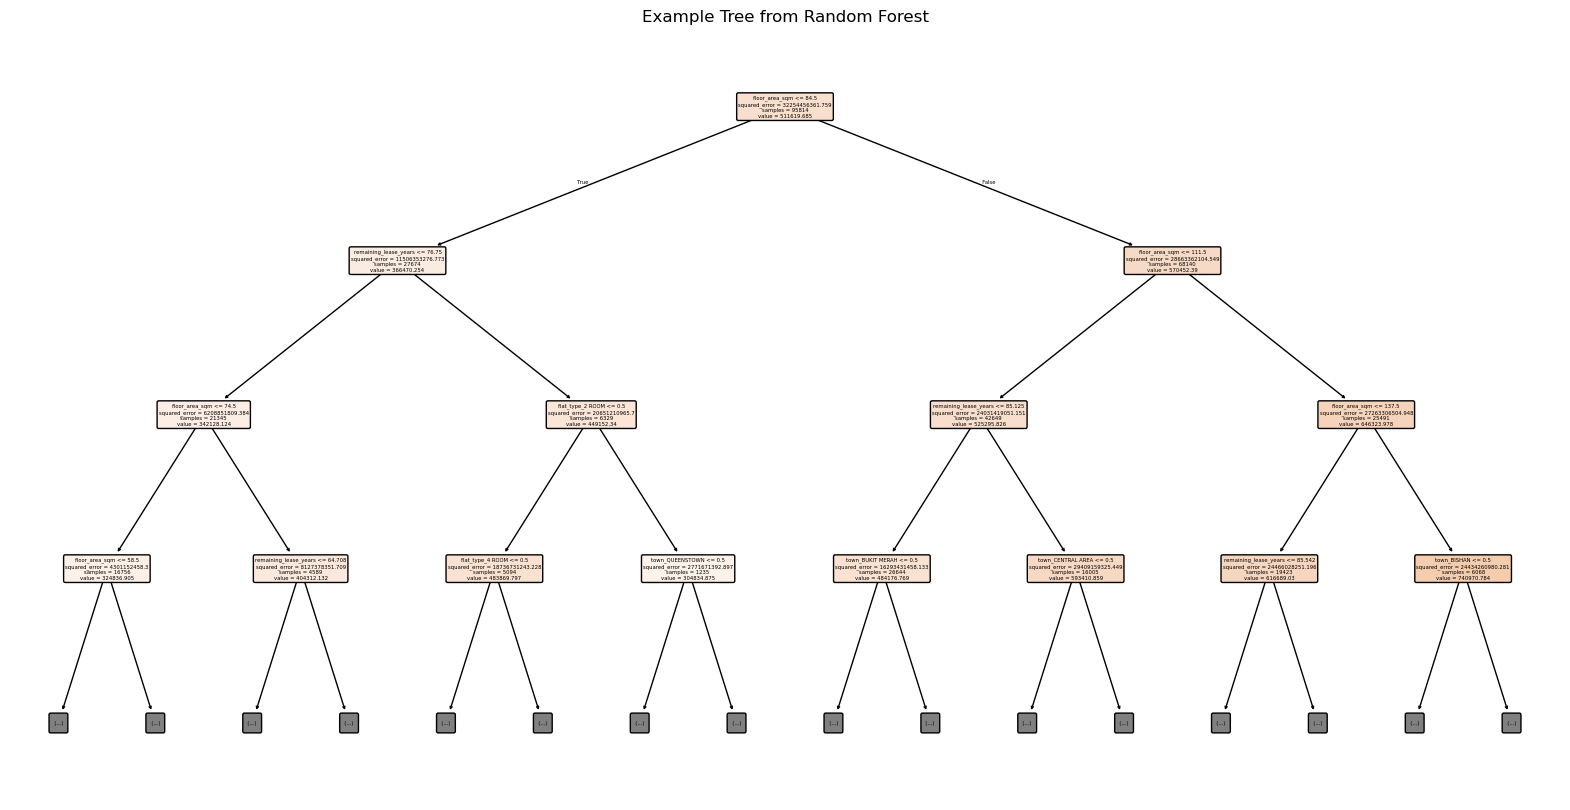

In [136]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=X_train.columns,
          max_depth=3,
          filled=True,
          rounded=True)
plt.title("Example Tree from Random Forest")
plt.show()

# 5 Find Predicted Resale Price And Its Fair Range
### Use the random forest regressor to predict resale price of a flat along with a range of fair values using the features:
    - floor area
    - remaining lease years
    - storey range
    - flat type
    - town

In [360]:
def predict_resale_price(floor_area_sqm, remaining_lease_years, storey_range, flat_type, town):
    """
    Predict HDB resale price using trained Random Forest model.
    """
    try:
        # Load model and encoders
        rf_model = joblib.load('rf_model.pkl')
        model_columns = joblib.load('rf_model_columns.pkl')
        flat_type_encoder = joblib.load('flat_type_encoder.pkl')
        town_encoder = joblib.load('town_encoder.pkl')
        storey_encoder = joblib.load('storey_encoder.pkl')
        
        # Step 1: Create input DataFrame
        input_df = pd.DataFrame([{
            'floor_area_sqm': floor_area_sqm,
            'remaining_lease_years': remaining_lease_years
        }])
        
     
        storey_range_array = storey_encoder.transform(pd.DataFrame({'storey_range': [storey_range]}))
        storey_range_encoded = pd.DataFrame(storey_range_array,
                                         columns=storey_encoder.get_feature_names_out(['storey_range']),
                                         index=input_df.index)
      
        flat_type_array = flat_type_encoder.transform(pd.DataFrame({'flat_type': [flat_type]}))
        flat_type_encoded = pd.DataFrame(flat_type_array,
                                         columns=flat_type_encoder.get_feature_names_out(['flat_type']),
                                         index=input_df.index)
    
        town_array = town_encoder.transform(pd.DataFrame({'town': [town]}))
        town_encoded = pd.DataFrame(town_array,
                                    columns=town_encoder.get_feature_names_out(['town']),
                                    index=input_df.index)
        

        input_features = pd.concat([
            input_df[['floor_area_sqm', 'remaining_lease_years']],
            storey_range_encoded,
            flat_type_encoded,
            town_encoded
        ], axis=1)
        
   
        input_features = input_features.reindex(columns=model_columns, fill_value=0)
        
        # Predict resale price
        predicted_price = rf_model.predict(input_features)[0]
        return round(predicted_price, 2)
    
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None


    all_tree_preds = [tree.predict(input_features.values)[0] for tree in rf_model.estimators_]
        
        
    predicted_price = round(np.mean(all_tree_preds), 2)
    
    lower_bound = round(np.percentile(all_tree_preds, 25), 2)
    upper_bound = round(np.percentile(all_tree_preds, 75), 2)

# Example usage
print("Central Area:", predict_resale_price(107, 84, '22 TO 24', '3 ROOM', 'CENTRAL AREA'))
print("Yishun:", predict_resale_price(64, 60, '06 TO 10', '2 ROOM', 'YISHUN'))
print("Sengkang:", predict_resale_price(141, 74, '06 TO 10', '5 ROOM', 'SENGKANG'))
print("Serangoon:", predict_resale_price(105, 58, '16 TO 18', '3 ROOM', 'SERANGOON'))


Central Area: 756760.0
Yishun: 404869.99
Sengkang: 769417.71
Serangoon: 724178.04


## 5.1 Evaluate fairness

- determine if the actual price paid for a flat is fair by evaluating if the actual price is within the predicted fair range

In [187]:
def evaluate_price_fairness(floor_area_sqm, remaining_lease_years, storey_range, flat_type, town, actual_price):
    """
    Predict resale price range and evaluate if actual price is fair.
    
    Returns:
    - Dictionary with predicted price, fair range, and fairness verdict
    """
    try:
        # Get the predicted range
        result = predict_resale_range(
            floor_area_sqm=floor_area_sqm,
            remaining_lease_years=remaining_lease_years,
            storey_range=storey_range,
            flat_type=flat_type,
            town=town
        )
        
        # Determine if actual price is within fair range
        lower_bound, upper_bound = result['price_range']
        is_fair = lower_bound <= actual_price <= upper_bound
        
        return {
            'actual_price': f"${actual_price:,.2f}",
            'predicted_price': f"${result['predicted_price']:,.2f}",
            'fair_price_range': f"${lower_bound:,.2f} – ${upper_bound:,.2f}",
            'is_fair': is_fair,
            'verdict': "FAIR" if is_fair else "UNFAIR",
            'price_difference': f"${actual_price - result['predicted_price']:,.2f}",
            'price_diff_pct': f"{(actual_price - result['predicted_price'])/result['predicted_price']*100:.1f}%"
        }
        
    except Exception as e:
        return {
            'error': str(e),
            'message': "Failed to evaluate price fairness"
        }

# Example usage
result = evaluate_price_fairness(
    floor_area_sqm=85,
    remaining_lease_years=75,
    storey_range='06 TO 10',
    flat_type='4 ROOM',
    town='PASIR RIS',
    actual_price=450000  
)


print(f"Actual Price: {result['actual_price']}")
print(f"Predicted Price: {result['predicted_price']}")
print(f"Fair Price Range: {result['fair_price_range']}")
print(f"Price Difference: {result['price_difference']} ({result['price_diff_pct']})")
print(f"\nVerdict: {result['verdict']}")
print("- The price is", 
      "within" if result['is_fair'] else "OUTSIDE", 
      "the fair range")


Actual Price: $450,000.00
Predicted Price: $527,841.20
Fair Price Range: $473,000.00 – $590,000.00
Price Difference: $-77,841.20 (-14.7%)

Verdict: UNFAIR
- The price is OUTSIDE the fair range


## 5.2 Analysis of fairness of resale_price for the entire dataset

- This section evaluates the fairness of HDB resale price prices by calculating the absolute and percentage difference between the actual and predicted prices. 

- We define multiple fairness thresholds such as ±10% and ±15% of the predicted price and errors within 1 standard deviation before converting into binary indicators (fair or not fair). 

- The fairness score is calculated as a weighted combination of these thresholds, with weights assigned based on their importance. A score of 1 would mean the actual resale price of the flat is extremely fair while a score of 0 would mean that the actual resale price is extremely unfair.

- The flats are then classified into categories such as Very Fair, Fair and Unfair. 

In [217]:
# Step 1: Get predicted price from your Random Forest Regressor
data['predicted_price'] = rf_model.predict(X_all)

# Step 2: Compute difference metrics
data['price_diff'] = data['resale_price'] - data['predicted_price']
data['price_diff_pct'] = (data['price_diff'] / data['predicted_price']) * 100  # Percentage difference

# Step 3: Define multiple fairness thresholds
data['price_fair_10pct'] = data['price_diff_pct'].abs() <= 10  # ±10% threshold
data['price_fair_15pct'] = data['price_diff_pct'].abs() <= 15  # ±15% threshold
data['price_fair_1std'] = data['price_diff'].abs() <= data['price_diff'].std()  # Within 1 standard deviation

# Step 4: Convert to binary indicators
for col in ['price_fair_10pct', 'price_fair_15pct', 'price_fair_1std']:
    data[col] = data[col].astype(int)

# Step 5: Add price range indicators based on percentiles
lower_bound = np.percentile(data['price_diff'], 25)
upper_bound = np.percentile(data['price_diff'], 75)
data['price_in_iqr'] = ((data['price_diff'] >= lower_bound) & 
                        (data['price_diff'] <= upper_bound)).astype(int)

# Step 6: Create comprehensive fairness score (weighted combination)
data['fairness_score'] = (
    0.4 * data['price_fair_10pct'] + 
    0.3 * data['price_fair_1std'] + 
    0.3 * data['price_in_iqr']
)

# Step 7: Categorize price fairness
conditions = [
    (data['fairness_score'] >= 0.9),
    (data['fairness_score'] >= 0.7),
    (data['fairness_score'] >= 0.5),
    (data['fairness_score'] < 0.5)
]
choices = ['Very Fair', 'Fair', 'Marginally Fair', 'Unfair']
data['price_fairness_category'] = np.select(conditions, choices)

# Print summary statistics
print("\nPrice Fairness Summary:")
print(f"- Mean absolute difference between predicted and actual resale price: ${data['price_diff'].abs().mean():,.2f}")
print(f"- Median percentage difference: {data['price_diff_pct'].abs().median():.1f}%")
print("\nFairness Distribution (%):")
print(data['price_fairness_category'].value_counts(normalize=True) * 100)


Price Fairness Summary:
- Mean absolute difference between predicted and actual resale price: $27,000.26
- Median percentage difference: 3.3%

Fairness Distribution (%):
price_fairness_category
Very Fair    49.999753
Fair         28.664173
Unfair       21.336074
Name: proportion, dtype: float64


In [193]:
print(round(data.groupby('town')['price_diff_pct'].mean(), 5))




town
ANG MO KIO         0.03392
BEDOK             -0.14564
BISHAN            -0.00764
BUKIT BATOK       -0.03364
BUKIT MERAH       -0.02110
BUKIT PANJANG      0.11160
BUKIT TIMAH        0.67504
CENTRAL AREA      -0.05375
CHOA CHU KANG     -0.29309
CLEMENTI           0.00639
GEYLANG            0.04115
HOUGANG           -0.18015
JURONG EAST       -0.19444
JURONG WEST       -0.16382
KALLANG/WHAMPOA   -0.00012
MARINE PARADE      0.55748
PASIR RIS         -0.21130
PUNGGOL            0.05216
QUEENSTOWN        -0.00194
SEMBAWANG         -0.07044
SENGKANG          -0.10165
SERANGOON          0.11158
TAMPINES          -0.09379
TOA PAYOH         -0.07662
WOODLANDS         -0.18386
YISHUN             0.02619
Name: price_diff_pct, dtype: float64


## Interpretation of Price Difference Percentages by Town
- The table above shows the average percentage difference between the predicted resale prices and the actual resale prices for various towns in Singapore. These values reflect how much the predicted resale price deviates from the actual price, and the sign (positive or negative) indicates whether the model's predictions were overestimates or underestimates.

- **BUKIT TIMAH and MARINE PARADE** has the highest positive difference with a 0.68% and 0.56% overestimation. This suggests that the actual cost of flats in these regions are higher than predicted

- **CLEMENTI**, for example, has a very small positive value of 0.006%, indicating the model's prediction is almost identical to the actual resale price.


- This suggests that while the model's predictions for Bukit Timah and Marine Parade are relatively accurate, there is still a small bias towards overpricing the flats in this area. For example, if the predicted price of a flat in Bukit Timah is $500,000, the model is underestimating the actual price by around 3400 dollars

- The underestimation may be due to **external factors** inflating the price of resale flats in that particular town, for example, proximity to good schools. 

# 6 Random Forest Classifier

This section explains how the **Random Forest Classifier** is used to predict whether a property price is considered **fair** or **unfair** based on the **fairness score**.

## **How It Works**
1. **Bootstrap Aggregation (Bagging)**  
   - From the original dataset, create multiple **bootstrap samples** (random subsets with replacement).  
   - Train a separate **decision tree** on each sample.  

2. **Random Feature Selection**  
   - At each node split, each tree considers only a **random subset of features**.  
   - This decorrelates the trees and makes the ensemble more robust.

3. **Voting**  
   - To classify a new instance, each tree casts a **“vote”** for a class (fair or unfair).  
   - The forest’s final prediction is the **majority vote** across all trees.

### Why We Used It
- **Ability to handle mixed data types**: Works seamlessly with numerical (floor area, lease years) and categorical (town, flat type) features.  
- **Captures non‑linear relationships**: Goes beyond linear boundaries to model complex interactions.  
- **Resilience to overfitting**: By averaging many decorrelated trees, it generalizes better than individual trees.


### **1. Data Preparation**
- The dataset is first prepared by **modifying the `fairness_score` column**. We apply a threshold where a score of **0.5 or higher** is considered **'fair'** (encoded as 1), and a score **below 0.5** is considered **'unfair'** (encoded as 0).
  
### **2. Data Splitting**
- We split the data into training and test sets before training the model



Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.61      0.47     10796
           1       0.88      0.73      0.80     39804

    accuracy                           0.71     50600
   macro avg       0.63      0.67      0.64     50600
weighted avg       0.77      0.71      0.73     50600


ROC AUC Score: 0.7442
Average Precision: 0.9060


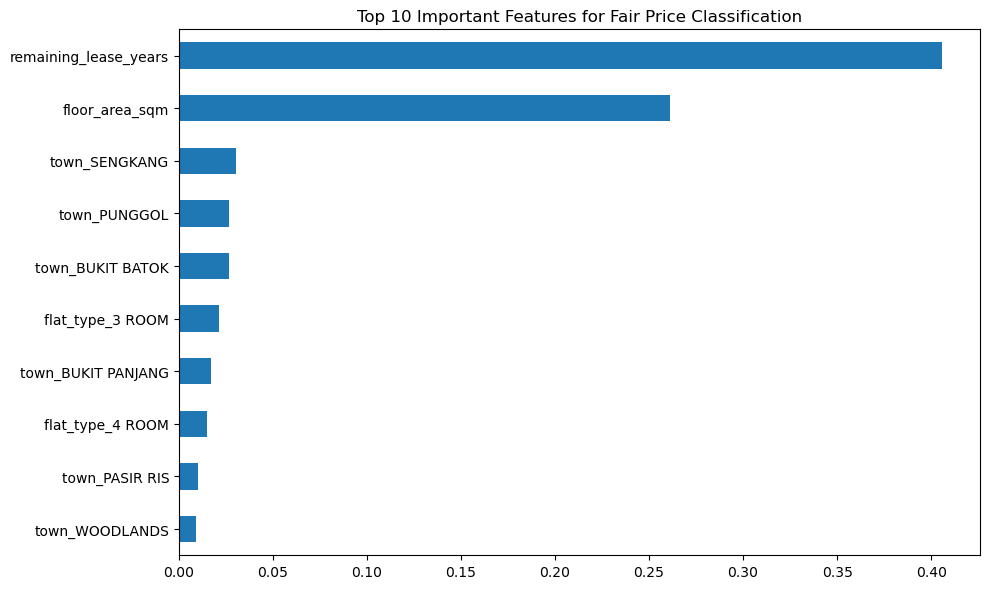

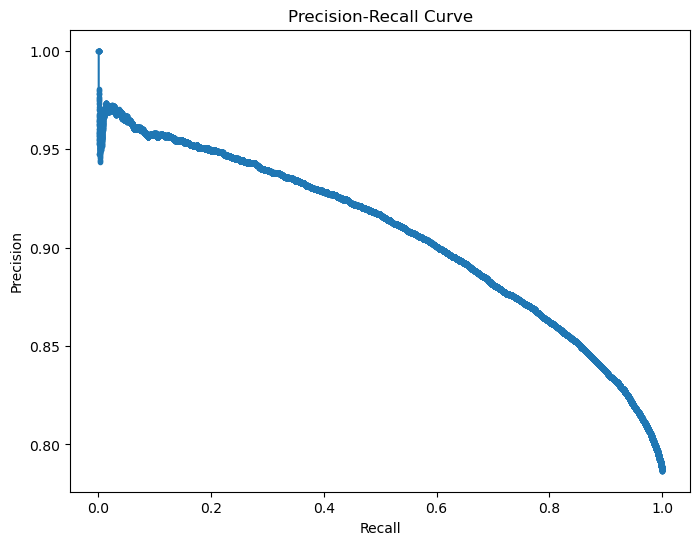


Optimal Probability Threshold: 0.263


['price_fairness_classifier.pkl']

In [279]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Prepare data - using your existing fairness definition
X_cls = X_all.copy()         # Features
# Modify the 'fairness_score' column to label values as 'FAIR' or 'UNFAIR'
data['fairness_label'] = data['fairness_score'].apply(lambda x: 1 if x >= 0.5 else 0)
le = LabelEncoder()
data['fairness_label'] = le.fit_transform(data['fairness_label'])

y_cls = data['fairness_label']   # Target (1 = fair, 0 = not fair)

# Split data with stratification to maintain class balance
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, 
    test_size=0.25, 
    random_state=42,
    stratify=y_cls  # Important for imbalanced classes
)

# Initialize and train classifier with balanced class weights
clf = RandomForestClassifier(
    n_estimators=250,        
    random_state=42,
    class_weight='balanced',  # Handles class imbalance
    max_depth=20,            
    min_samples_leaf=6,     
    n_jobs=-1              
)
clf.fit(X_train_cls, y_train_cls)

# Predictions (both classes and probabilities)
y_pred_cls = clf.predict(X_test_cls)
y_pred_proba = clf.predict_proba(X_test_cls)[:, 1]  # Probability of class 1 (fair)

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_cls))
print(f"\nROC AUC Score: {roc_auc_score(y_test_cls, y_pred_proba):.4f}")
print(f"Average Precision: {average_precision_score(y_test_cls, y_pred_proba):.4f}")

# Feature Importance
importances = pd.Series(clf.feature_importances_, index=X_train_cls.columns)
top_features = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh')
plt.title('Top 10 Important Features for Fair Price Classification')
plt.tight_layout()
plt.show()

# Precision-Recall Curve (better than ROC for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test_cls, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Optimal Threshold Finder (based on F1-score)
from sklearn.metrics import f1_score
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test_cls, y_pred_proba >= t) for t in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Probability Threshold: {optimal_threshold:.3f}")

# Save model for later use
import joblib
joblib.dump(clf, 'price_fairness_classifier.pkl')

## 6.1 **Model Evaluation**

### **1. Evaluation metrics**
  - **Precision**: $\frac{True Positives}{True Positives  +  False Positives}$
    
      
    
  - **Recall**: $\frac{True Positives}{True Positives  +  False Neagtives}$
     
    
  - **F1 score**: 2 * $\frac{Precision  *  Recall}{Precision  +  Recall}$
      - F1 score of **0.80** shows that there is a relatively good balance between precision and recall for "fair" resale prices
        
  - **ROC AUC Score**: Measures the model's ability to distinguish between the classes. A higher score indicates a better model.
    - A score of **0.74** shows that the performance of the model is acceptable.
      
  - **Average Precision**: Shows the percentage of correct "fair" predictions out of all "fair" predictions made.

### **2. Feature Importance**
- The top 10 most important features are displayed to understand which variables contribute most to determining whether a price is fair. Features like **`remaining_lease_years`** and **`floor_area_sqm`** are the most important. 

### **3. Precision-Recall Curve**
- The **Precision-Recall Curve** shows the trade-off between precision (correctly identifying 'fair' properties) and recall (capturing all 'fair' properties).


### **4. Optimal Threshold for Classification**
- The optimal threshold of 0.263 indicates that flats with a predicted probability of being fair above 26.3% are classified as fair. This threshold balances precision and recall to maximize the model’s ability to classify flats correctly.


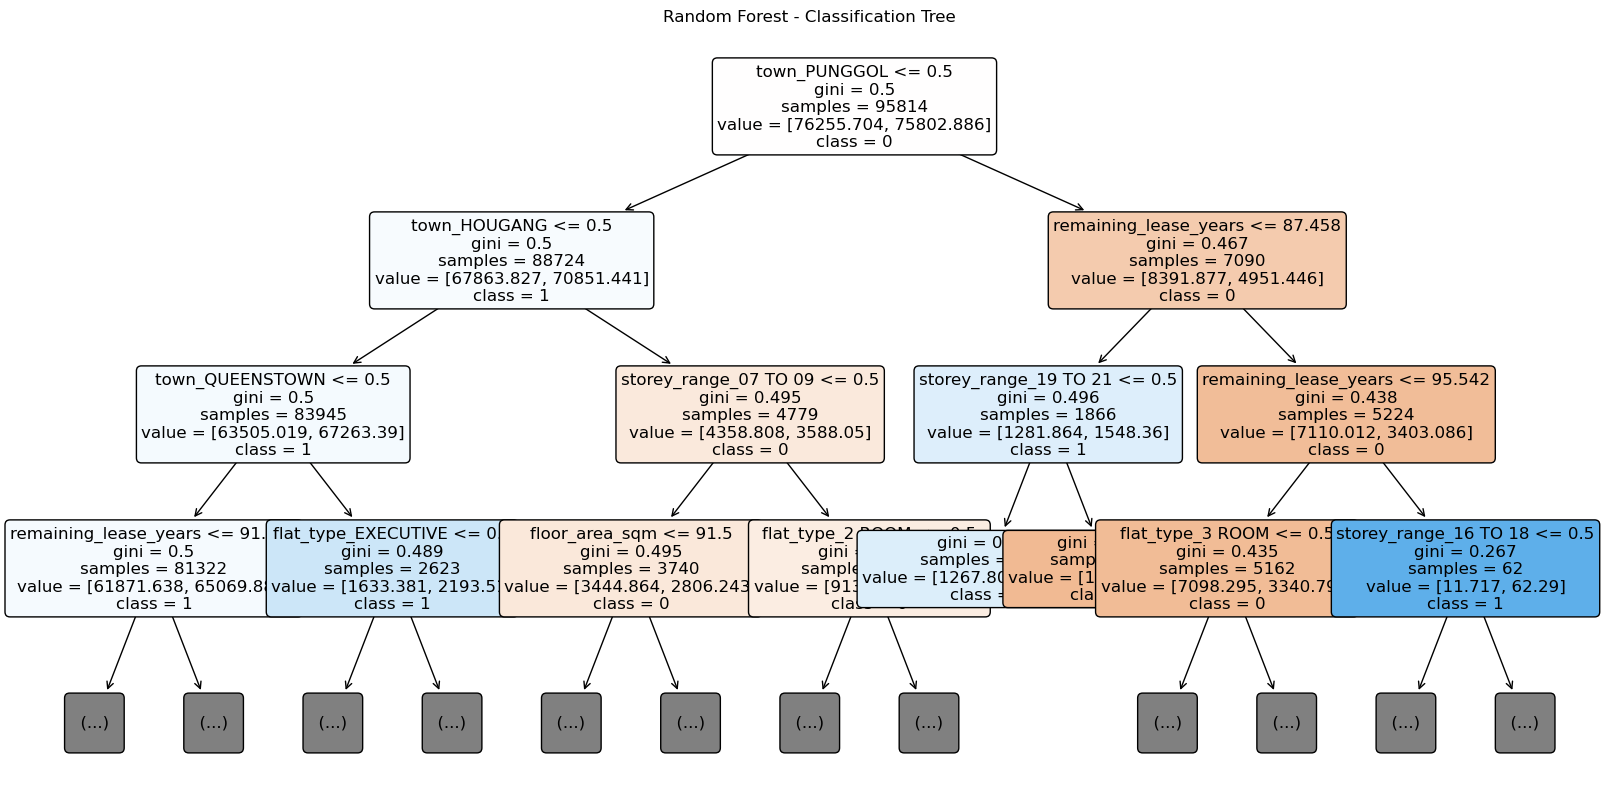

In [352]:
class_names = [str(label) for label in le.classes_]

# Visualize one of the trees from the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(
    clf.estimators_[0],  
    feature_names=X_train_cls.columns,  
    class_names=class_names,
    max_depth = 3,
    filled=True,  
    rounded=True,  
    fontsize=12  
)
plt.title("Random Forest - Classification Tree")
plt.show()
